### WA Cities - CSV to JSON

In [1]:
# General dependencies
import pandas as pd
import datetime as dt

# Mapping dependencies
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

# APIs dependencies
import json
import requests
from pprint import pprint
from resources.api_keys import owm_api_key as owm_key

url_hstr = 'https://api.openweathermap.org/data/2.5/uvi/history?'
units = 'metric'

### CSV to JSON

In [2]:
# Dataframe
city_data_df = pd.read_csv('resources/wa_cities.csv')

# Output to jsom file
city_data_df.to_json('analysis/wa_cities.json')

# Display
city_data_df

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Albany,-35.0228,117.8814,Australia,AU,Western Australia,NaN,34205,29373
1,Augusta,-34.3120,115.1590,Australia,AU,Western Australia,NaN,1109,1109
2,Australind,-33.2792,115.7150,Australia,AU,Western Australia,NaN,14539,14539
3,Bakers Hill,-31.7510,116.4550,Australia,AU,Western Australia,NaN,1118,1118
4,Bentley,-32.0010,115.9240,Australia,AU,Western Australia,NaN,8782,8782
...,...,...,...,...,...,...,...,...,...
78,Wundowie,-31.7667,116.3830,Australia,AU,Western Australia,NaN,1352,1352
79,Yallingup,-33.6397,115.0263,Australia,AU,Western Australia,NaN,1029,1029
80,Yanchep,-31.5500,115.6340,Australia,AU,Western Australia,NaN,8868,8868
81,York,-31.8883,116.7686,Australia,AU,Western Australia,NaN,2548,2535


### Verify positions

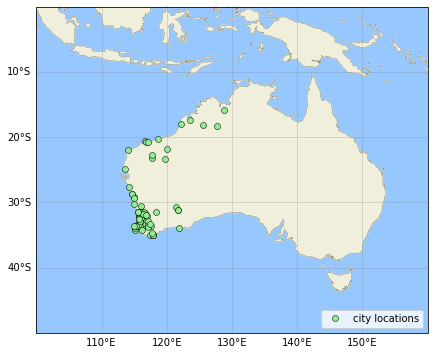

In [3]:
# Display sample cities on a map to verify locations

# Data
x_axis = city_data_df['lng']
y_axis = city_data_df['lat']

# Cartopy base map - https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/geoaxes.html
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,6))
#ax.set_global()  # show maximum extent supported by this projection
ax.set_extent([100, 160, -50, 0], crs=ccrs.PlateCarree())
ax.set_facecolor((150/255, 200/255, 255/255))  # background colour of plot
ax.coastlines(lw=0.2)  # lightly define coastlines
ax.add_feature(cartopy.feature.LAND)  # mask over background with land shape

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False

# Plot city locations
ax.plot(x_axis, y_axis, 'bo', ms=6, mfc='lightgreen', mec='black', mew=0.5, label='city locations')
ax.legend(loc='lower right');


### Collect Historical Data

In [4]:
# Generate grid with timestamps
    
# Empty list to grid locations
grid_list = []

dte_stt = int(dt.datetime.strptime('2020-01-01 12:00:00 UTC', '%Y-%m-%d %H:%M:%S %Z').timestamp())
dte_cnt = 365

for dte in range(dte_stt, dte_stt + dte_cnt*(86400), 86400):
    for latlon in city_data_df.iterrows():

        grid_list.append([latlon[1]['city'], round(latlon[1]['lat'],3), round(latlon[1]['lng'],3), dte])


print(len(grid_list))
# print(grid_list)

# Partial query URL
qery_url_hstr = f'{url_hstr}&appid={owm_key}'

# Empty variables to hold response
hstr_data_city = {}
hstr_data_city['date'] = []
hstr_data_city['city'] = []
hstr_data_city['latitude'] = []
hstr_data_city['longitude'] = []
hstr_data_city['uv-index'] = []
cntr = 0
# uv index - historical data
# Loop through the grid and perform a request for data on each
# Call function 'grid_pnts' to provide coordinates
for locn in grid_list:  
    
    cntr += 1
    print(f'{cntr} ... {locn} ...')
    
    # If location in OWM database then collect data
    try:
        # request uv index data for location
        response = requests.get(qery_url_hstr + '&lat=' + str(locn[1]) + '&lon=' + str(locn[2])  + '&start=' + str(locn[3]) + '&end=' + str(locn[3] + 86400*dte_cnt)).json()
        
        # append to json string
        hstr_data_city['date'].append(dt.datetime.utcfromtimestamp(response[0]['date']).strftime('%Y-%m-%d %H:%M'))
        hstr_data_city['city'].append(locn[0])
        hstr_data_city['latitude'].append(response[0]['lat'])
        hstr_data_city['longitude'].append(response[0]['lon'])
        hstr_data_city['uv-index'].append(response[0]['value'])

        
    # If location not in OWM database then report to log and skip to next location
    except:
        print(f'  {locn} not found ...skipping...')

# write json to file
with open('analysis/hstr_data_city.json', 'w') as outfile:
    json.dump(hstr_data_city, outfile)        

# print to terminal
pprint(hstr_data_city)
print(f'  Finished data collection')

30295
1 ... ['Albany', -35.023, 117.881, 1577851200] ...
2 ... ['Augusta', -34.312, 115.159, 1577851200] ...
3 ... ['Australind', -33.279, 115.715, 1577851200] ...
4 ... ['Bakers Hill', -31.751, 116.455, 1577851200] ...
5 ... ['Bentley', -32.001, 115.924, 1577851200] ...
6 ... ['Beverley', -32.109, 116.926, 1577851200] ...
7 ... ['Bindoon', -31.38, 116.097, 1577851200] ...
8 ... ['Binningup', -33.149, 115.689, 1577851200] ...
9 ... ['Boddington', -32.802, 116.471, 1577851200] ...
10 ... ['Boyanup', -33.486, 115.73, 1577851200] ...
11 ... ['Bridgetown', -33.958, 116.138, 1577851200] ...
12 ... ['Broome', -17.962, 122.236, 1577851200] ...
13 ... ['Bullsbrook', -31.663, 116.03, 1577851200] ...
14 ... ['Bunbury', -33.333, 115.633, 1577851200] ...
15 ... ['Busselton', -33.648, 115.346, 1577851200] ...
16 ... ['Cannington', -32.017, 115.95, 1577851200] ...
17 ... ['Capel', -33.557, 115.57, 1577851200] ...
18 ... ['Carnarvon', -24.867, 113.661, 1577851200] ...
19 ... ['Chidlow', -31.857, 116.

150 ... ['Port Hedland', -20.31, 118.601, 1577937600] ...
151 ... ['Quindalup', -33.667, 115.145, 1577937600] ...
152 ... ['Ravenswood', -32.583, 115.833, 1577937600] ...
153 ... ['Serpentine', -32.365, 115.981, 1577937600] ...
154 ... ['Tom Price', -22.694, 117.795, 1577937600] ...
155 ... ['Toodyay', -31.55, 116.45, 1577937600] ...
156 ... ['Two Rocks', -31.495, 115.588, 1577937600] ...
157 ... ['Vasse', -33.69, 115.3, 1577937600] ...
158 ... ['Wagin', -33.317, 117.35, 1577937600] ...
159 ... ['Waroona', -32.867, 115.917, 1577937600] ...
160 ... ['Wickham', -20.675, 117.14, 1577937600] ...
161 ... ['Wooroloo', -31.803, 116.314, 1577937600] ...
162 ... ['Wundowie', -31.767, 116.383, 1577937600] ...
163 ... ['Yallingup', -33.64, 115.026, 1577937600] ...
164 ... ['Yanchep', -31.55, 115.634, 1577937600] ...
165 ... ['York', -31.888, 116.769, 1577937600] ...
166 ... ['Yunderup', -32.583, 115.8, 1577937600] ...
167 ... ['Albany', -35.023, 117.881, 1578024000] ...
168 ... ['Augusta', -34.31

299 ... ['Lower Chittering', -31.556, 116.087, 1578110400] ...
300 ... ['Lower King', -34.958, 117.938, 1578110400] ...
301 ... ['Mandurah', -32.529, 115.723, 1578110400] ...
302 ... ['Manjimup', -34.241, 116.146, 1578110400] ...
303 ... ['Margaret River', -33.955, 115.075, 1578110400] ...
304 ... ['Merredin', -31.482, 118.279, 1578110400] ...
305 ... ['Moora', -30.638, 116.01, 1578110400] ...
306 ... ['Mount Barker', -34.63, 117.667, 1578110400] ...
307 ... ['Mundijong', -32.284, 115.973, 1578110400] ...
308 ... ['Narrogin', -32.936, 117.178, 1578110400] ...
309 ... ['Newman', -23.354, 119.732, 1578110400] ...
310 ... ['Northam', -31.653, 116.666, 1578110400] ...
311 ... ['Nullagine', -21.888, 120.107, 1578110400] ...
312 ... ['Paraburdoo', -23.201, 117.671, 1578110400] ...
313 ... ['Perth', -31.952, 115.859, 1578110400] ...
314 ... ['Pinjarra', -32.63, 115.871, 1578110400] ...
315 ... ['Port Denison', -29.283, 114.917, 1578110400] ...
316 ... ['Port Hedland', -20.31, 118.601, 1578110

448 ... ['Geraldton', -28.774, 114.609, 1578283200] ...
449 ... ['Halls Creek', -18.23, 127.67, 1578283200] ...
450 ... ['Harvey', -33.08, 115.89, 1578283200] ...
451 ... ['Jarrahdale', -32.339, 116.062, 1578283200] ...
452 ... ['Jurien Bay', -30.297, 115.042, 1578283200] ...
453 ... ['Kalbarri', -27.71, 114.16, 1578283200] ...
454 ... ['Kalgoorlie', -30.749, 121.466, 1578283200] ...
455 ... ['Kambalda', -31.2, 121.67, 1578283200] ...
456 ... ['Kambalda West', -31.211, 121.713, 1578283200] ...
457 ... ['Karratha', -20.736, 116.846, 1578283200] ...
458 ... ['Katanning', -33.691, 117.555, 1578283200] ...
459 ... ['Kojonup', -33.84, 117.15, 1578283200] ...
460 ... ['Kununurra', -15.774, 128.739, 1578283200] ...
461 ... ['Kwinana', -32.239, 115.77, 1578283200] ...
462 ... ['Leschenault', -33.245, 115.735, 1578283200] ...
463 ... ['Lesmurdie', -31.994, 116.05, 1578283200] ...
464 ... ['Little Grove', -35.07, 117.87, 1578283200] ...
465 ... ['Lower Chittering', -31.556, 116.087, 1578283200] 

597 ... ['Cannington', -32.017, 115.95, 1578456000] ...
598 ... ['Capel', -33.557, 115.57, 1578456000] ...
599 ... ['Carnarvon', -24.867, 113.661, 1578456000] ...
600 ... ['Chidlow', -31.857, 116.272, 1578456000] ...
601 ... ['Collie', -33.363, 116.156, 1578456000] ...
602 ... ['Cowaramup', -33.85, 115.11, 1578456000] ...
603 ... ['Dampier', -20.66, 116.71, 1578456000] ...
604 ... ['Denmark', -34.96, 117.353, 1578456000] ...
605 ... ['Derby', -17.306, 123.634, 1578456000] ...
606 ... ['Dongara', -29.251, 114.934, 1578456000] ...
607 ... ['Donnybrook', -33.58, 115.82, 1578456000] ...
608 ... ['Drummond Cove', -28.673, 114.613, 1578456000] ...
609 ... ['Dunsborough', -33.617, 115.1, 1578456000] ...
610 ... ['Esperance', -33.861, 121.892, 1578456000] ...
611 ... ['Exmouth', -21.933, 114.128, 1578456000] ...
612 ... ['Fitzroy Crossing', -18.194, 125.567, 1578456000] ...
613 ... ['Fremantle', -32.057, 115.744, 1578456000] ...
614 ... ['Geraldton', -28.774, 114.609, 1578456000] ...
615 ... [

746 ... ['York', -31.888, 116.769, 1578542400] ...
747 ... ['Yunderup', -32.583, 115.8, 1578542400] ...
748 ... ['Albany', -35.023, 117.881, 1578628800] ...
749 ... ['Augusta', -34.312, 115.159, 1578628800] ...
750 ... ['Australind', -33.279, 115.715, 1578628800] ...
751 ... ['Bakers Hill', -31.751, 116.455, 1578628800] ...
752 ... ['Bentley', -32.001, 115.924, 1578628800] ...
753 ... ['Beverley', -32.109, 116.926, 1578628800] ...
754 ... ['Bindoon', -31.38, 116.097, 1578628800] ...
755 ... ['Binningup', -33.149, 115.689, 1578628800] ...
756 ... ['Boddington', -32.802, 116.471, 1578628800] ...
757 ... ['Boyanup', -33.486, 115.73, 1578628800] ...
758 ... ['Bridgetown', -33.958, 116.138, 1578628800] ...
759 ... ['Broome', -17.962, 122.236, 1578628800] ...
760 ... ['Bullsbrook', -31.663, 116.03, 1578628800] ...
761 ... ['Bunbury', -33.333, 115.633, 1578628800] ...
762 ... ['Busselton', -33.648, 115.346, 1578628800] ...
763 ... ['Cannington', -32.017, 115.95, 1578628800] ...
764 ... ['Cape

895 ... ['Pinjarra', -32.63, 115.871, 1578715200] ...
896 ... ['Port Denison', -29.283, 114.917, 1578715200] ...
897 ... ['Port Hedland', -20.31, 118.601, 1578715200] ...
898 ... ['Quindalup', -33.667, 115.145, 1578715200] ...
899 ... ['Ravenswood', -32.583, 115.833, 1578715200] ...
900 ... ['Serpentine', -32.365, 115.981, 1578715200] ...
901 ... ['Tom Price', -22.694, 117.795, 1578715200] ...
902 ... ['Toodyay', -31.55, 116.45, 1578715200] ...
903 ... ['Two Rocks', -31.495, 115.588, 1578715200] ...
904 ... ['Vasse', -33.69, 115.3, 1578715200] ...
905 ... ['Wagin', -33.317, 117.35, 1578715200] ...
906 ... ['Waroona', -32.867, 115.917, 1578715200] ...
907 ... ['Wickham', -20.675, 117.14, 1578715200] ...
908 ... ['Wooroloo', -31.803, 116.314, 1578715200] ...
909 ... ['Wundowie', -31.767, 116.383, 1578715200] ...
910 ... ['Yallingup', -33.64, 115.026, 1578715200] ...
911 ... ['Yanchep', -31.55, 115.634, 1578715200] ...
912 ... ['York', -31.888, 116.769, 1578715200] ...
913 ... ['Yunderup'

1044 ... ['Lesmurdie', -31.994, 116.05, 1578888000] ...
1045 ... ['Little Grove', -35.07, 117.87, 1578888000] ...
1046 ... ['Lower Chittering', -31.556, 116.087, 1578888000] ...
1047 ... ['Lower King', -34.958, 117.938, 1578888000] ...
1048 ... ['Mandurah', -32.529, 115.723, 1578888000] ...
1049 ... ['Manjimup', -34.241, 116.146, 1578888000] ...
1050 ... ['Margaret River', -33.955, 115.075, 1578888000] ...
1051 ... ['Merredin', -31.482, 118.279, 1578888000] ...
1052 ... ['Moora', -30.638, 116.01, 1578888000] ...
1053 ... ['Mount Barker', -34.63, 117.667, 1578888000] ...
1054 ... ['Mundijong', -32.284, 115.973, 1578888000] ...
1055 ... ['Narrogin', -32.936, 117.178, 1578888000] ...
1056 ... ['Newman', -23.354, 119.732, 1578888000] ...
1057 ... ['Northam', -31.653, 116.666, 1578888000] ...
1058 ... ['Nullagine', -21.888, 120.107, 1578888000] ...
1059 ... ['Paraburdoo', -23.201, 117.671, 1578888000] ...
1060 ... ['Perth', -31.952, 115.859, 1578888000] ...
1061 ... ['Pinjarra', -32.63, 115

1191 ... ['Esperance', -33.861, 121.892, 1579060800] ...
1192 ... ['Exmouth', -21.933, 114.128, 1579060800] ...
1193 ... ['Fitzroy Crossing', -18.194, 125.567, 1579060800] ...
1194 ... ['Fremantle', -32.057, 115.744, 1579060800] ...
1195 ... ['Geraldton', -28.774, 114.609, 1579060800] ...
1196 ... ['Halls Creek', -18.23, 127.67, 1579060800] ...
1197 ... ['Harvey', -33.08, 115.89, 1579060800] ...
1198 ... ['Jarrahdale', -32.339, 116.062, 1579060800] ...
1199 ... ['Jurien Bay', -30.297, 115.042, 1579060800] ...
1200 ... ['Kalbarri', -27.71, 114.16, 1579060800] ...
1201 ... ['Kalgoorlie', -30.749, 121.466, 1579060800] ...
1202 ... ['Kambalda', -31.2, 121.67, 1579060800] ...
1203 ... ['Kambalda West', -31.211, 121.713, 1579060800] ...
1204 ... ['Karratha', -20.736, 116.846, 1579060800] ...
1205 ... ['Katanning', -33.691, 117.555, 1579060800] ...
1206 ... ['Kojonup', -33.84, 117.15, 1579060800] ...
1207 ... ['Kununurra', -15.774, 128.739, 1579060800] ...
1208 ... ['Kwinana', -32.239, 115.77

1337 ... ['Boddington', -32.802, 116.471, 1579233600] ...
1338 ... ['Boyanup', -33.486, 115.73, 1579233600] ...
1339 ... ['Bridgetown', -33.958, 116.138, 1579233600] ...
1340 ... ['Broome', -17.962, 122.236, 1579233600] ...
1341 ... ['Bullsbrook', -31.663, 116.03, 1579233600] ...
1342 ... ['Bunbury', -33.333, 115.633, 1579233600] ...
1343 ... ['Busselton', -33.648, 115.346, 1579233600] ...
1344 ... ['Cannington', -32.017, 115.95, 1579233600] ...
1345 ... ['Capel', -33.557, 115.57, 1579233600] ...
1346 ... ['Carnarvon', -24.867, 113.661, 1579233600] ...
1347 ... ['Chidlow', -31.857, 116.272, 1579233600] ...
1348 ... ['Collie', -33.363, 116.156, 1579233600] ...
1349 ... ['Cowaramup', -33.85, 115.11, 1579233600] ...
1350 ... ['Dampier', -20.66, 116.71, 1579233600] ...
1351 ... ['Denmark', -34.96, 117.353, 1579233600] ...
1352 ... ['Derby', -17.306, 123.634, 1579233600] ...
1353 ... ['Dongara', -29.251, 114.934, 1579233600] ...
1354 ... ['Donnybrook', -33.58, 115.82, 1579233600] ...
1355 .

1483 ... ['Toodyay', -31.55, 116.45, 1579320000] ...
1484 ... ['Two Rocks', -31.495, 115.588, 1579320000] ...
1485 ... ['Vasse', -33.69, 115.3, 1579320000] ...
1486 ... ['Wagin', -33.317, 117.35, 1579320000] ...
1487 ... ['Waroona', -32.867, 115.917, 1579320000] ...
1488 ... ['Wickham', -20.675, 117.14, 1579320000] ...
1489 ... ['Wooroloo', -31.803, 116.314, 1579320000] ...
1490 ... ['Wundowie', -31.767, 116.383, 1579320000] ...
1491 ... ['Yallingup', -33.64, 115.026, 1579320000] ...
1492 ... ['Yanchep', -31.55, 115.634, 1579320000] ...
1493 ... ['York', -31.888, 116.769, 1579320000] ...
1494 ... ['Yunderup', -32.583, 115.8, 1579320000] ...
1495 ... ['Albany', -35.023, 117.881, 1579406400] ...
1496 ... ['Augusta', -34.312, 115.159, 1579406400] ...
1497 ... ['Australind', -33.279, 115.715, 1579406400] ...
1498 ... ['Bakers Hill', -31.751, 116.455, 1579406400] ...
1499 ... ['Bentley', -32.001, 115.924, 1579406400] ...
1500 ... ['Beverley', -32.109, 116.926, 1579406400] ...
1501 ... ['Bin

1630 ... ['Manjimup', -34.241, 116.146, 1579492800] ...
1631 ... ['Margaret River', -33.955, 115.075, 1579492800] ...
1632 ... ['Merredin', -31.482, 118.279, 1579492800] ...
1633 ... ['Moora', -30.638, 116.01, 1579492800] ...
1634 ... ['Mount Barker', -34.63, 117.667, 1579492800] ...
1635 ... ['Mundijong', -32.284, 115.973, 1579492800] ...
1636 ... ['Narrogin', -32.936, 117.178, 1579492800] ...
1637 ... ['Newman', -23.354, 119.732, 1579492800] ...
1638 ... ['Northam', -31.653, 116.666, 1579492800] ...
1639 ... ['Nullagine', -21.888, 120.107, 1579492800] ...
1640 ... ['Paraburdoo', -23.201, 117.671, 1579492800] ...
1641 ... ['Perth', -31.952, 115.859, 1579492800] ...
1642 ... ['Pinjarra', -32.63, 115.871, 1579492800] ...
1643 ... ['Port Denison', -29.283, 114.917, 1579492800] ...
1644 ... ['Port Hedland', -20.31, 118.601, 1579492800] ...
1645 ... ['Quindalup', -33.667, 115.145, 1579492800] ...
1646 ... ['Ravenswood', -32.583, 115.833, 1579492800] ...
1647 ... ['Serpentine', -32.365, 115

1777 ... ['Halls Creek', -18.23, 127.67, 1579665600] ...
1778 ... ['Harvey', -33.08, 115.89, 1579665600] ...
1779 ... ['Jarrahdale', -32.339, 116.062, 1579665600] ...
1780 ... ['Jurien Bay', -30.297, 115.042, 1579665600] ...
1781 ... ['Kalbarri', -27.71, 114.16, 1579665600] ...
1782 ... ['Kalgoorlie', -30.749, 121.466, 1579665600] ...
1783 ... ['Kambalda', -31.2, 121.67, 1579665600] ...
1784 ... ['Kambalda West', -31.211, 121.713, 1579665600] ...
1785 ... ['Karratha', -20.736, 116.846, 1579665600] ...
1786 ... ['Katanning', -33.691, 117.555, 1579665600] ...
1787 ... ['Kojonup', -33.84, 117.15, 1579665600] ...
1788 ... ['Kununurra', -15.774, 128.739, 1579665600] ...
1789 ... ['Kwinana', -32.239, 115.77, 1579665600] ...
1790 ... ['Leschenault', -33.245, 115.735, 1579665600] ...
1791 ... ['Lesmurdie', -31.994, 116.05, 1579665600] ...
1792 ... ['Little Grove', -35.07, 117.87, 1579665600] ...
1793 ... ['Lower Chittering', -31.556, 116.087, 1579665600] ...
1794 ... ['Lower King', -34.958, 11

1923 ... ['Bunbury', -33.333, 115.633, 1579838400] ...
1924 ... ['Busselton', -33.648, 115.346, 1579838400] ...
1925 ... ['Cannington', -32.017, 115.95, 1579838400] ...
1926 ... ['Capel', -33.557, 115.57, 1579838400] ...
1927 ... ['Carnarvon', -24.867, 113.661, 1579838400] ...
1928 ... ['Chidlow', -31.857, 116.272, 1579838400] ...
1929 ... ['Collie', -33.363, 116.156, 1579838400] ...
1930 ... ['Cowaramup', -33.85, 115.11, 1579838400] ...
1931 ... ['Dampier', -20.66, 116.71, 1579838400] ...
1932 ... ['Denmark', -34.96, 117.353, 1579838400] ...
1933 ... ['Derby', -17.306, 123.634, 1579838400] ...
1934 ... ['Dongara', -29.251, 114.934, 1579838400] ...
1935 ... ['Donnybrook', -33.58, 115.82, 1579838400] ...
1936 ... ['Drummond Cove', -28.673, 114.613, 1579838400] ...
1937 ... ['Dunsborough', -33.617, 115.1, 1579838400] ...
1938 ... ['Esperance', -33.861, 121.892, 1579838400] ...
1939 ... ['Exmouth', -21.933, 114.128, 1579838400] ...
1940 ... ['Fitzroy Crossing', -18.194, 125.567, 157983840

2069 ... ['Wickham', -20.675, 117.14, 1579924800] ...
2070 ... ['Wooroloo', -31.803, 116.314, 1579924800] ...
2071 ... ['Wundowie', -31.767, 116.383, 1579924800] ...
2072 ... ['Yallingup', -33.64, 115.026, 1579924800] ...
2073 ... ['Yanchep', -31.55, 115.634, 1579924800] ...
2074 ... ['York', -31.888, 116.769, 1579924800] ...
2075 ... ['Yunderup', -32.583, 115.8, 1579924800] ...
2076 ... ['Albany', -35.023, 117.881, 1580011200] ...
2077 ... ['Augusta', -34.312, 115.159, 1580011200] ...
2078 ... ['Australind', -33.279, 115.715, 1580011200] ...
2079 ... ['Bakers Hill', -31.751, 116.455, 1580011200] ...
2080 ... ['Bentley', -32.001, 115.924, 1580011200] ...
2081 ... ['Beverley', -32.109, 116.926, 1580011200] ...
2082 ... ['Bindoon', -31.38, 116.097, 1580011200] ...
2083 ... ['Binningup', -33.149, 115.689, 1580011200] ...
2084 ... ['Boddington', -32.802, 116.471, 1580011200] ...
2085 ... ['Boyanup', -33.486, 115.73, 1580011200] ...
2086 ... ['Bridgetown', -33.958, 116.138, 1580011200] ...


2215 ... ['Mount Barker', -34.63, 117.667, 1580097600] ...
2216 ... ['Mundijong', -32.284, 115.973, 1580097600] ...
2217 ... ['Narrogin', -32.936, 117.178, 1580097600] ...
2218 ... ['Newman', -23.354, 119.732, 1580097600] ...
2219 ... ['Northam', -31.653, 116.666, 1580097600] ...
2220 ... ['Nullagine', -21.888, 120.107, 1580097600] ...
2221 ... ['Paraburdoo', -23.201, 117.671, 1580097600] ...
2222 ... ['Perth', -31.952, 115.859, 1580097600] ...
2223 ... ['Pinjarra', -32.63, 115.871, 1580097600] ...
2224 ... ['Port Denison', -29.283, 114.917, 1580097600] ...
2225 ... ['Port Hedland', -20.31, 118.601, 1580097600] ...
2226 ... ['Quindalup', -33.667, 115.145, 1580097600] ...
2227 ... ['Ravenswood', -32.583, 115.833, 1580097600] ...
2228 ... ['Serpentine', -32.365, 115.981, 1580097600] ...
2229 ... ['Tom Price', -22.694, 117.795, 1580097600] ...
2230 ... ['Toodyay', -31.55, 116.45, 1580097600] ...
2231 ... ['Two Rocks', -31.495, 115.588, 1580097600] ...
2232 ... ['Vasse', -33.69, 115.3, 158

2362 ... ['Kalbarri', -27.71, 114.16, 1580270400] ...
2363 ... ['Kalgoorlie', -30.749, 121.466, 1580270400] ...
2364 ... ['Kambalda', -31.2, 121.67, 1580270400] ...
2365 ... ['Kambalda West', -31.211, 121.713, 1580270400] ...
2366 ... ['Karratha', -20.736, 116.846, 1580270400] ...
2367 ... ['Katanning', -33.691, 117.555, 1580270400] ...
2368 ... ['Kojonup', -33.84, 117.15, 1580270400] ...
2369 ... ['Kununurra', -15.774, 128.739, 1580270400] ...
2370 ... ['Kwinana', -32.239, 115.77, 1580270400] ...
2371 ... ['Leschenault', -33.245, 115.735, 1580270400] ...
2372 ... ['Lesmurdie', -31.994, 116.05, 1580270400] ...
2373 ... ['Little Grove', -35.07, 117.87, 1580270400] ...
2374 ... ['Lower Chittering', -31.556, 116.087, 1580270400] ...
2375 ... ['Lower King', -34.958, 117.938, 1580270400] ...
2376 ... ['Mandurah', -32.529, 115.723, 1580270400] ...
2377 ... ['Manjimup', -34.241, 116.146, 1580270400] ...
2378 ... ['Margaret River', -33.955, 115.075, 1580270400] ...
2379 ... ['Merredin', -31.48

2509 ... ['Chidlow', -31.857, 116.272, 1580443200] ...
2510 ... ['Collie', -33.363, 116.156, 1580443200] ...
2511 ... ['Cowaramup', -33.85, 115.11, 1580443200] ...
2512 ... ['Dampier', -20.66, 116.71, 1580443200] ...
2513 ... ['Denmark', -34.96, 117.353, 1580443200] ...
2514 ... ['Derby', -17.306, 123.634, 1580443200] ...
2515 ... ['Dongara', -29.251, 114.934, 1580443200] ...
2516 ... ['Donnybrook', -33.58, 115.82, 1580443200] ...
2517 ... ['Drummond Cove', -28.673, 114.613, 1580443200] ...
2518 ... ['Dunsborough', -33.617, 115.1, 1580443200] ...
2519 ... ['Esperance', -33.861, 121.892, 1580443200] ...
2520 ... ['Exmouth', -21.933, 114.128, 1580443200] ...
2521 ... ['Fitzroy Crossing', -18.194, 125.567, 1580443200] ...
2522 ... ['Fremantle', -32.057, 115.744, 1580443200] ...
2523 ... ['Geraldton', -28.774, 114.609, 1580443200] ...
2524 ... ['Halls Creek', -18.23, 127.67, 1580443200] ...
2525 ... ['Harvey', -33.08, 115.89, 1580443200] ...
2526 ... ['Jarrahdale', -32.339, 116.062, 158044

2655 ... ['York', -31.888, 116.769, 1580529600] ...
2656 ... ['Yunderup', -32.583, 115.8, 1580529600] ...
2657 ... ['Albany', -35.023, 117.881, 1580616000] ...
2658 ... ['Augusta', -34.312, 115.159, 1580616000] ...
2659 ... ['Australind', -33.279, 115.715, 1580616000] ...
2660 ... ['Bakers Hill', -31.751, 116.455, 1580616000] ...
2661 ... ['Bentley', -32.001, 115.924, 1580616000] ...
2662 ... ['Beverley', -32.109, 116.926, 1580616000] ...
2663 ... ['Bindoon', -31.38, 116.097, 1580616000] ...
2664 ... ['Binningup', -33.149, 115.689, 1580616000] ...
2665 ... ['Boddington', -32.802, 116.471, 1580616000] ...
2666 ... ['Boyanup', -33.486, 115.73, 1580616000] ...
2667 ... ['Bridgetown', -33.958, 116.138, 1580616000] ...
2668 ... ['Broome', -17.962, 122.236, 1580616000] ...
2669 ... ['Bullsbrook', -31.663, 116.03, 1580616000] ...
2670 ... ['Bunbury', -33.333, 115.633, 1580616000] ...
2671 ... ['Busselton', -33.648, 115.346, 1580616000] ...
2672 ... ['Cannington', -32.017, 115.95, 1580616000] 

2801 ... ['Nullagine', -21.888, 120.107, 1580702400] ...
2802 ... ['Paraburdoo', -23.201, 117.671, 1580702400] ...
2803 ... ['Perth', -31.952, 115.859, 1580702400] ...
2804 ... ['Pinjarra', -32.63, 115.871, 1580702400] ...
2805 ... ['Port Denison', -29.283, 114.917, 1580702400] ...
2806 ... ['Port Hedland', -20.31, 118.601, 1580702400] ...
2807 ... ['Quindalup', -33.667, 115.145, 1580702400] ...
2808 ... ['Ravenswood', -32.583, 115.833, 1580702400] ...
2809 ... ['Serpentine', -32.365, 115.981, 1580702400] ...
2810 ... ['Tom Price', -22.694, 117.795, 1580702400] ...
2811 ... ['Toodyay', -31.55, 116.45, 1580702400] ...
2812 ... ['Two Rocks', -31.495, 115.588, 1580702400] ...
2813 ... ['Vasse', -33.69, 115.3, 1580702400] ...
2814 ... ['Wagin', -33.317, 117.35, 1580702400] ...
2815 ... ['Waroona', -32.867, 115.917, 1580702400] ...
2816 ... ['Wickham', -20.675, 117.14, 1580702400] ...
2817 ... ['Wooroloo', -31.803, 116.314, 1580702400] ...
2818 ... ['Wundowie', -31.767, 116.383, 1580702400]

2948 ... ['Katanning', -33.691, 117.555, 1580875200] ...
2949 ... ['Kojonup', -33.84, 117.15, 1580875200] ...
2950 ... ['Kununurra', -15.774, 128.739, 1580875200] ...
2951 ... ['Kwinana', -32.239, 115.77, 1580875200] ...
2952 ... ['Leschenault', -33.245, 115.735, 1580875200] ...
2953 ... ['Lesmurdie', -31.994, 116.05, 1580875200] ...
2954 ... ['Little Grove', -35.07, 117.87, 1580875200] ...
2955 ... ['Lower Chittering', -31.556, 116.087, 1580875200] ...
2956 ... ['Lower King', -34.958, 117.938, 1580875200] ...
2957 ... ['Mandurah', -32.529, 115.723, 1580875200] ...
2958 ... ['Manjimup', -34.241, 116.146, 1580875200] ...
2959 ... ['Margaret River', -33.955, 115.075, 1580875200] ...
2960 ... ['Merredin', -31.482, 118.279, 1580875200] ...
2961 ... ['Moora', -30.638, 116.01, 1580875200] ...
2962 ... ['Mount Barker', -34.63, 117.667, 1580875200] ...
2963 ... ['Mundijong', -32.284, 115.973, 1580875200] ...
2964 ... ['Narrogin', -32.936, 117.178, 1580875200] ...
2965 ... ['Newman', -23.354, 1

3095 ... ['Derby', -17.306, 123.634, 1581048000] ...
3096 ... ['Dongara', -29.251, 114.934, 1581048000] ...
3097 ... ['Donnybrook', -33.58, 115.82, 1581048000] ...
3098 ... ['Drummond Cove', -28.673, 114.613, 1581048000] ...
3099 ... ['Dunsborough', -33.617, 115.1, 1581048000] ...
3100 ... ['Esperance', -33.861, 121.892, 1581048000] ...
3101 ... ['Exmouth', -21.933, 114.128, 1581048000] ...
3102 ... ['Fitzroy Crossing', -18.194, 125.567, 1581048000] ...
3103 ... ['Fremantle', -32.057, 115.744, 1581048000] ...
3104 ... ['Geraldton', -28.774, 114.609, 1581048000] ...
3105 ... ['Halls Creek', -18.23, 127.67, 1581048000] ...
3106 ... ['Harvey', -33.08, 115.89, 1581048000] ...
3107 ... ['Jarrahdale', -32.339, 116.062, 1581048000] ...
3108 ... ['Jurien Bay', -30.297, 115.042, 1581048000] ...
3109 ... ['Kalbarri', -27.71, 114.16, 1581048000] ...
3110 ... ['Kalgoorlie', -30.749, 121.466, 1581048000] ...
3111 ... ['Kambalda', -31.2, 121.67, 1581048000] ...
3112 ... ['Kambalda West', -31.211, 12

3240 ... ['Australind', -33.279, 115.715, 1581220800] ...
3241 ... ['Bakers Hill', -31.751, 116.455, 1581220800] ...
3242 ... ['Bentley', -32.001, 115.924, 1581220800] ...
3243 ... ['Beverley', -32.109, 116.926, 1581220800] ...
3244 ... ['Bindoon', -31.38, 116.097, 1581220800] ...
3245 ... ['Binningup', -33.149, 115.689, 1581220800] ...
3246 ... ['Boddington', -32.802, 116.471, 1581220800] ...
3247 ... ['Boyanup', -33.486, 115.73, 1581220800] ...
3248 ... ['Bridgetown', -33.958, 116.138, 1581220800] ...
3249 ... ['Broome', -17.962, 122.236, 1581220800] ...
3250 ... ['Bullsbrook', -31.663, 116.03, 1581220800] ...
3251 ... ['Bunbury', -33.333, 115.633, 1581220800] ...
3252 ... ['Busselton', -33.648, 115.346, 1581220800] ...
3253 ... ['Cannington', -32.017, 115.95, 1581220800] ...
3254 ... ['Capel', -33.557, 115.57, 1581220800] ...
3255 ... ['Carnarvon', -24.867, 113.661, 1581220800] ...
3256 ... ['Chidlow', -31.857, 116.272, 1581220800] ...
3257 ... ['Collie', -33.363, 116.156, 158122080

3386 ... ['Port Denison', -29.283, 114.917, 1581307200] ...
3387 ... ['Port Hedland', -20.31, 118.601, 1581307200] ...
3388 ... ['Quindalup', -33.667, 115.145, 1581307200] ...
3389 ... ['Ravenswood', -32.583, 115.833, 1581307200] ...
3390 ... ['Serpentine', -32.365, 115.981, 1581307200] ...
3391 ... ['Tom Price', -22.694, 117.795, 1581307200] ...
3392 ... ['Toodyay', -31.55, 116.45, 1581307200] ...
3393 ... ['Two Rocks', -31.495, 115.588, 1581307200] ...
3394 ... ['Vasse', -33.69, 115.3, 1581307200] ...
3395 ... ['Wagin', -33.317, 117.35, 1581307200] ...
3396 ... ['Waroona', -32.867, 115.917, 1581307200] ...
3397 ... ['Wickham', -20.675, 117.14, 1581307200] ...
3398 ... ['Wooroloo', -31.803, 116.314, 1581307200] ...
3399 ... ['Wundowie', -31.767, 116.383, 1581307200] ...
3400 ... ['Yallingup', -33.64, 115.026, 1581307200] ...
3401 ... ['Yanchep', -31.55, 115.634, 1581307200] ...
3402 ... ['York', -31.888, 116.769, 1581307200] ...
3403 ... ['Yunderup', -32.583, 115.8, 1581307200] ...
34

3533 ... ['Leschenault', -33.245, 115.735, 1581480000] ...
3534 ... ['Lesmurdie', -31.994, 116.05, 1581480000] ...
3535 ... ['Little Grove', -35.07, 117.87, 1581480000] ...
3536 ... ['Lower Chittering', -31.556, 116.087, 1581480000] ...
3537 ... ['Lower King', -34.958, 117.938, 1581480000] ...
3538 ... ['Mandurah', -32.529, 115.723, 1581480000] ...
3539 ... ['Manjimup', -34.241, 116.146, 1581480000] ...
3540 ... ['Margaret River', -33.955, 115.075, 1581480000] ...
3541 ... ['Merredin', -31.482, 118.279, 1581480000] ...
3542 ... ['Moora', -30.638, 116.01, 1581480000] ...
3543 ... ['Mount Barker', -34.63, 117.667, 1581480000] ...
3544 ... ['Mundijong', -32.284, 115.973, 1581480000] ...
3545 ... ['Narrogin', -32.936, 117.178, 1581480000] ...
3546 ... ['Newman', -23.354, 119.732, 1581480000] ...
3547 ... ['Northam', -31.653, 116.666, 1581480000] ...
3548 ... ['Nullagine', -21.888, 120.107, 1581480000] ...
3549 ... ['Paraburdoo', -23.201, 117.671, 1581480000] ...
3550 ... ['Perth', -31.952,

3680 ... ['Dunsborough', -33.617, 115.1, 1581652800] ...
3681 ... ['Esperance', -33.861, 121.892, 1581652800] ...
3682 ... ['Exmouth', -21.933, 114.128, 1581652800] ...
3683 ... ['Fitzroy Crossing', -18.194, 125.567, 1581652800] ...
3684 ... ['Fremantle', -32.057, 115.744, 1581652800] ...
3685 ... ['Geraldton', -28.774, 114.609, 1581652800] ...
3686 ... ['Halls Creek', -18.23, 127.67, 1581652800] ...
3687 ... ['Harvey', -33.08, 115.89, 1581652800] ...
3688 ... ['Jarrahdale', -32.339, 116.062, 1581652800] ...
3689 ... ['Jurien Bay', -30.297, 115.042, 1581652800] ...
3690 ... ['Kalbarri', -27.71, 114.16, 1581652800] ...
3691 ... ['Kalgoorlie', -30.749, 121.466, 1581652800] ...
3692 ... ['Kambalda', -31.2, 121.67, 1581652800] ...
3693 ... ['Kambalda West', -31.211, 121.713, 1581652800] ...
3694 ... ['Karratha', -20.736, 116.846, 1581652800] ...
3695 ... ['Katanning', -33.691, 117.555, 1581652800] ...
3696 ... ['Kojonup', -33.84, 117.15, 1581652800] ...
3697 ... ['Kununurra', -15.774, 128.

3826 ... ['Binningup', -33.149, 115.689, 1581825600] ...
3827 ... ['Boddington', -32.802, 116.471, 1581825600] ...
3828 ... ['Boyanup', -33.486, 115.73, 1581825600] ...
3829 ... ['Bridgetown', -33.958, 116.138, 1581825600] ...
3830 ... ['Broome', -17.962, 122.236, 1581825600] ...
3831 ... ['Bullsbrook', -31.663, 116.03, 1581825600] ...
3832 ... ['Bunbury', -33.333, 115.633, 1581825600] ...
3833 ... ['Busselton', -33.648, 115.346, 1581825600] ...
3834 ... ['Cannington', -32.017, 115.95, 1581825600] ...
3835 ... ['Capel', -33.557, 115.57, 1581825600] ...
3836 ... ['Carnarvon', -24.867, 113.661, 1581825600] ...
3837 ... ['Chidlow', -31.857, 116.272, 1581825600] ...
3838 ... ['Collie', -33.363, 116.156, 1581825600] ...
3839 ... ['Cowaramup', -33.85, 115.11, 1581825600] ...
3840 ... ['Dampier', -20.66, 116.71, 1581825600] ...
3841 ... ['Denmark', -34.96, 117.353, 1581825600] ...
3842 ... ['Derby', -17.306, 123.634, 1581825600] ...
3843 ... ['Dongara', -29.251, 114.934, 1581825600] ...
3844 

3972 ... ['Tom Price', -22.694, 117.795, 1581912000] ...
3973 ... ['Toodyay', -31.55, 116.45, 1581912000] ...
3974 ... ['Two Rocks', -31.495, 115.588, 1581912000] ...
3975 ... ['Vasse', -33.69, 115.3, 1581912000] ...
3976 ... ['Wagin', -33.317, 117.35, 1581912000] ...
3977 ... ['Waroona', -32.867, 115.917, 1581912000] ...
3978 ... ['Wickham', -20.675, 117.14, 1581912000] ...
3979 ... ['Wooroloo', -31.803, 116.314, 1581912000] ...
3980 ... ['Wundowie', -31.767, 116.383, 1581912000] ...
3981 ... ['Yallingup', -33.64, 115.026, 1581912000] ...
3982 ... ['Yanchep', -31.55, 115.634, 1581912000] ...
3983 ... ['York', -31.888, 116.769, 1581912000] ...
3984 ... ['Yunderup', -32.583, 115.8, 1581912000] ...
3985 ... ['Albany', -35.023, 117.881, 1581998400] ...
3986 ... ['Augusta', -34.312, 115.159, 1581998400] ...
3987 ... ['Australind', -33.279, 115.715, 1581998400] ...
3988 ... ['Bakers Hill', -31.751, 116.455, 1581998400] ...
3989 ... ['Bentley', -32.001, 115.924, 1581998400] ...
3990 ... ['Be

4119 ... ['Mandurah', -32.529, 115.723, 1582084800] ...
4120 ... ['Manjimup', -34.241, 116.146, 1582084800] ...
4121 ... ['Margaret River', -33.955, 115.075, 1582084800] ...
4122 ... ['Merredin', -31.482, 118.279, 1582084800] ...
4123 ... ['Moora', -30.638, 116.01, 1582084800] ...
4124 ... ['Mount Barker', -34.63, 117.667, 1582084800] ...
4125 ... ['Mundijong', -32.284, 115.973, 1582084800] ...
4126 ... ['Narrogin', -32.936, 117.178, 1582084800] ...
4127 ... ['Newman', -23.354, 119.732, 1582084800] ...
4128 ... ['Northam', -31.653, 116.666, 1582084800] ...
4129 ... ['Nullagine', -21.888, 120.107, 1582084800] ...
4130 ... ['Paraburdoo', -23.201, 117.671, 1582084800] ...
4131 ... ['Perth', -31.952, 115.859, 1582084800] ...
4132 ... ['Pinjarra', -32.63, 115.871, 1582084800] ...
4133 ... ['Port Denison', -29.283, 114.917, 1582084800] ...
4134 ... ['Port Hedland', -20.31, 118.601, 1582084800] ...
4135 ... ['Quindalup', -33.667, 115.145, 1582084800] ...
4136 ... ['Ravenswood', -32.583, 115.8

4266 ... ['Geraldton', -28.774, 114.609, 1582257600] ...
4267 ... ['Halls Creek', -18.23, 127.67, 1582257600] ...
4268 ... ['Harvey', -33.08, 115.89, 1582257600] ...
4269 ... ['Jarrahdale', -32.339, 116.062, 1582257600] ...
4270 ... ['Jurien Bay', -30.297, 115.042, 1582257600] ...
4271 ... ['Kalbarri', -27.71, 114.16, 1582257600] ...
4272 ... ['Kalgoorlie', -30.749, 121.466, 1582257600] ...
4273 ... ['Kambalda', -31.2, 121.67, 1582257600] ...
4274 ... ['Kambalda West', -31.211, 121.713, 1582257600] ...
4275 ... ['Karratha', -20.736, 116.846, 1582257600] ...
4276 ... ['Katanning', -33.691, 117.555, 1582257600] ...
4277 ... ['Kojonup', -33.84, 117.15, 1582257600] ...
4278 ... ['Kununurra', -15.774, 128.739, 1582257600] ...
4279 ... ['Kwinana', -32.239, 115.77, 1582257600] ...
4280 ... ['Leschenault', -33.245, 115.735, 1582257600] ...
4281 ... ['Lesmurdie', -31.994, 116.05, 1582257600] ...
4282 ... ['Little Grove', -35.07, 117.87, 1582257600] ...
4283 ... ['Lower Chittering', -31.556, 116

4412 ... ['Bullsbrook', -31.663, 116.03, 1582430400] ...
4413 ... ['Bunbury', -33.333, 115.633, 1582430400] ...
4414 ... ['Busselton', -33.648, 115.346, 1582430400] ...
4415 ... ['Cannington', -32.017, 115.95, 1582430400] ...
4416 ... ['Capel', -33.557, 115.57, 1582430400] ...
4417 ... ['Carnarvon', -24.867, 113.661, 1582430400] ...
4418 ... ['Chidlow', -31.857, 116.272, 1582430400] ...
4419 ... ['Collie', -33.363, 116.156, 1582430400] ...
4420 ... ['Cowaramup', -33.85, 115.11, 1582430400] ...
4421 ... ['Dampier', -20.66, 116.71, 1582430400] ...
4422 ... ['Denmark', -34.96, 117.353, 1582430400] ...
4423 ... ['Derby', -17.306, 123.634, 1582430400] ...
4424 ... ['Dongara', -29.251, 114.934, 1582430400] ...
4425 ... ['Donnybrook', -33.58, 115.82, 1582430400] ...
4426 ... ['Drummond Cove', -28.673, 114.613, 1582430400] ...
4427 ... ['Dunsborough', -33.617, 115.1, 1582430400] ...
4428 ... ['Esperance', -33.861, 121.892, 1582430400] ...
4429 ... ['Exmouth', -21.933, 114.128, 1582430400] ...


4558 ... ['Waroona', -32.867, 115.917, 1582516800] ...
4559 ... ['Wickham', -20.675, 117.14, 1582516800] ...
4560 ... ['Wooroloo', -31.803, 116.314, 1582516800] ...
4561 ... ['Wundowie', -31.767, 116.383, 1582516800] ...
4562 ... ['Yallingup', -33.64, 115.026, 1582516800] ...
4563 ... ['Yanchep', -31.55, 115.634, 1582516800] ...
4564 ... ['York', -31.888, 116.769, 1582516800] ...
4565 ... ['Yunderup', -32.583, 115.8, 1582516800] ...
4566 ... ['Albany', -35.023, 117.881, 1582603200] ...
4567 ... ['Augusta', -34.312, 115.159, 1582603200] ...
4568 ... ['Australind', -33.279, 115.715, 1582603200] ...
4569 ... ['Bakers Hill', -31.751, 116.455, 1582603200] ...
4570 ... ['Bentley', -32.001, 115.924, 1582603200] ...
4571 ... ['Beverley', -32.109, 116.926, 1582603200] ...
4572 ... ['Bindoon', -31.38, 116.097, 1582603200] ...
4573 ... ['Binningup', -33.149, 115.689, 1582603200] ...
4574 ... ['Boddington', -32.802, 116.471, 1582603200] ...
4575 ... ['Boyanup', -33.486, 115.73, 1582603200] ...
457

4704 ... ['Moora', -30.638, 116.01, 1582689600] ...
4705 ... ['Mount Barker', -34.63, 117.667, 1582689600] ...
4706 ... ['Mundijong', -32.284, 115.973, 1582689600] ...
4707 ... ['Narrogin', -32.936, 117.178, 1582689600] ...
4708 ... ['Newman', -23.354, 119.732, 1582689600] ...
4709 ... ['Northam', -31.653, 116.666, 1582689600] ...
4710 ... ['Nullagine', -21.888, 120.107, 1582689600] ...
4711 ... ['Paraburdoo', -23.201, 117.671, 1582689600] ...
4712 ... ['Perth', -31.952, 115.859, 1582689600] ...
4713 ... ['Pinjarra', -32.63, 115.871, 1582689600] ...
4714 ... ['Port Denison', -29.283, 114.917, 1582689600] ...
4715 ... ['Port Hedland', -20.31, 118.601, 1582689600] ...
4716 ... ['Quindalup', -33.667, 115.145, 1582689600] ...
4717 ... ['Ravenswood', -32.583, 115.833, 1582689600] ...
4718 ... ['Serpentine', -32.365, 115.981, 1582689600] ...
4719 ... ['Tom Price', -22.694, 117.795, 1582689600] ...
4720 ... ['Toodyay', -31.55, 116.45, 1582689600] ...
4721 ... ['Two Rocks', -31.495, 115.588, 1

4851 ... ['Jurien Bay', -30.297, 115.042, 1582862400] ...
4852 ... ['Kalbarri', -27.71, 114.16, 1582862400] ...
4853 ... ['Kalgoorlie', -30.749, 121.466, 1582862400] ...
4854 ... ['Kambalda', -31.2, 121.67, 1582862400] ...
4855 ... ['Kambalda West', -31.211, 121.713, 1582862400] ...
4856 ... ['Karratha', -20.736, 116.846, 1582862400] ...
4857 ... ['Katanning', -33.691, 117.555, 1582862400] ...
4858 ... ['Kojonup', -33.84, 117.15, 1582862400] ...
4859 ... ['Kununurra', -15.774, 128.739, 1582862400] ...
4860 ... ['Kwinana', -32.239, 115.77, 1582862400] ...
4861 ... ['Leschenault', -33.245, 115.735, 1582862400] ...
4862 ... ['Lesmurdie', -31.994, 116.05, 1582862400] ...
4863 ... ['Little Grove', -35.07, 117.87, 1582862400] ...
4864 ... ['Lower Chittering', -31.556, 116.087, 1582862400] ...
4865 ... ['Lower King', -34.958, 117.938, 1582862400] ...
4866 ... ['Mandurah', -32.529, 115.723, 1582862400] ...
4867 ... ['Manjimup', -34.241, 116.146, 1582862400] ...
4868 ... ['Margaret River', -33.

4997 ... ['Capel', -33.557, 115.57, 1583035200] ...
4998 ... ['Carnarvon', -24.867, 113.661, 1583035200] ...
4999 ... ['Chidlow', -31.857, 116.272, 1583035200] ...
5000 ... ['Collie', -33.363, 116.156, 1583035200] ...
5001 ... ['Cowaramup', -33.85, 115.11, 1583035200] ...
5002 ... ['Dampier', -20.66, 116.71, 1583035200] ...
5003 ... ['Denmark', -34.96, 117.353, 1583035200] ...
5004 ... ['Derby', -17.306, 123.634, 1583035200] ...
5005 ... ['Dongara', -29.251, 114.934, 1583035200] ...
5006 ... ['Donnybrook', -33.58, 115.82, 1583035200] ...
5007 ... ['Drummond Cove', -28.673, 114.613, 1583035200] ...
5008 ... ['Dunsborough', -33.617, 115.1, 1583035200] ...
5009 ... ['Esperance', -33.861, 121.892, 1583035200] ...
5010 ... ['Exmouth', -21.933, 114.128, 1583035200] ...
5011 ... ['Fitzroy Crossing', -18.194, 125.567, 1583035200] ...
5012 ... ['Fremantle', -32.057, 115.744, 1583035200] ...
5013 ... ['Geraldton', -28.774, 114.609, 1583035200] ...
5014 ... ['Halls Creek', -18.23, 127.67, 1583035

5143 ... ['Yallingup', -33.64, 115.026, 1583121600] ...
5144 ... ['Yanchep', -31.55, 115.634, 1583121600] ...
5145 ... ['York', -31.888, 116.769, 1583121600] ...
5146 ... ['Yunderup', -32.583, 115.8, 1583121600] ...
5147 ... ['Albany', -35.023, 117.881, 1583208000] ...
5148 ... ['Augusta', -34.312, 115.159, 1583208000] ...
5149 ... ['Australind', -33.279, 115.715, 1583208000] ...
5150 ... ['Bakers Hill', -31.751, 116.455, 1583208000] ...
5151 ... ['Bentley', -32.001, 115.924, 1583208000] ...
5152 ... ['Beverley', -32.109, 116.926, 1583208000] ...
5153 ... ['Bindoon', -31.38, 116.097, 1583208000] ...
5154 ... ['Binningup', -33.149, 115.689, 1583208000] ...
5155 ... ['Boddington', -32.802, 116.471, 1583208000] ...
5156 ... ['Boyanup', -33.486, 115.73, 1583208000] ...
5157 ... ['Bridgetown', -33.958, 116.138, 1583208000] ...
5158 ... ['Broome', -17.962, 122.236, 1583208000] ...
5159 ... ['Bullsbrook', -31.663, 116.03, 1583208000] ...
5160 ... ['Bunbury', -33.333, 115.633, 1583208000] ...


5289 ... ['Newman', -23.354, 119.732, 1583294400] ...
5290 ... ['Northam', -31.653, 116.666, 1583294400] ...
5291 ... ['Nullagine', -21.888, 120.107, 1583294400] ...
5292 ... ['Paraburdoo', -23.201, 117.671, 1583294400] ...
5293 ... ['Perth', -31.952, 115.859, 1583294400] ...
5294 ... ['Pinjarra', -32.63, 115.871, 1583294400] ...
5295 ... ['Port Denison', -29.283, 114.917, 1583294400] ...
5296 ... ['Port Hedland', -20.31, 118.601, 1583294400] ...
5297 ... ['Quindalup', -33.667, 115.145, 1583294400] ...
5298 ... ['Ravenswood', -32.583, 115.833, 1583294400] ...
5299 ... ['Serpentine', -32.365, 115.981, 1583294400] ...
5300 ... ['Tom Price', -22.694, 117.795, 1583294400] ...
5301 ... ['Toodyay', -31.55, 116.45, 1583294400] ...
5302 ... ['Two Rocks', -31.495, 115.588, 1583294400] ...
5303 ... ['Vasse', -33.69, 115.3, 1583294400] ...
5304 ... ['Wagin', -33.317, 117.35, 1583294400] ...
5305 ... ['Waroona', -32.867, 115.917, 1583294400] ...
5306 ... ['Wickham', -20.675, 117.14, 1583294400] ..

5436 ... ['Kambalda West', -31.211, 121.713, 1583467200] ...
5437 ... ['Karratha', -20.736, 116.846, 1583467200] ...
5438 ... ['Katanning', -33.691, 117.555, 1583467200] ...
5439 ... ['Kojonup', -33.84, 117.15, 1583467200] ...
5440 ... ['Kununurra', -15.774, 128.739, 1583467200] ...
5441 ... ['Kwinana', -32.239, 115.77, 1583467200] ...
5442 ... ['Leschenault', -33.245, 115.735, 1583467200] ...
5443 ... ['Lesmurdie', -31.994, 116.05, 1583467200] ...
5444 ... ['Little Grove', -35.07, 117.87, 1583467200] ...
5445 ... ['Lower Chittering', -31.556, 116.087, 1583467200] ...
5446 ... ['Lower King', -34.958, 117.938, 1583467200] ...
5447 ... ['Mandurah', -32.529, 115.723, 1583467200] ...
5448 ... ['Manjimup', -34.241, 116.146, 1583467200] ...
5449 ... ['Margaret River', -33.955, 115.075, 1583467200] ...
5450 ... ['Merredin', -31.482, 118.279, 1583467200] ...
5451 ... ['Moora', -30.638, 116.01, 1583467200] ...
5452 ... ['Mount Barker', -34.63, 117.667, 1583467200] ...
5453 ... ['Mundijong', -32

5583 ... ['Dampier', -20.66, 116.71, 1583640000] ...
5584 ... ['Denmark', -34.96, 117.353, 1583640000] ...
5585 ... ['Derby', -17.306, 123.634, 1583640000] ...
5586 ... ['Dongara', -29.251, 114.934, 1583640000] ...
5587 ... ['Donnybrook', -33.58, 115.82, 1583640000] ...
5588 ... ['Drummond Cove', -28.673, 114.613, 1583640000] ...
5589 ... ['Dunsborough', -33.617, 115.1, 1583640000] ...
5590 ... ['Esperance', -33.861, 121.892, 1583640000] ...
5591 ... ['Exmouth', -21.933, 114.128, 1583640000] ...
5592 ... ['Fitzroy Crossing', -18.194, 125.567, 1583640000] ...
5593 ... ['Fremantle', -32.057, 115.744, 1583640000] ...
5594 ... ['Geraldton', -28.774, 114.609, 1583640000] ...
5595 ... ['Halls Creek', -18.23, 127.67, 1583640000] ...
5596 ... ['Harvey', -33.08, 115.89, 1583640000] ...
5597 ... ['Jarrahdale', -32.339, 116.062, 1583640000] ...
5598 ... ['Jurien Bay', -30.297, 115.042, 1583640000] ...
5599 ... ['Kalbarri', -27.71, 114.16, 1583640000] ...
5600 ... ['Kalgoorlie', -30.749, 121.466, 

5729 ... ['Augusta', -34.312, 115.159, 1583812800] ...
5730 ... ['Australind', -33.279, 115.715, 1583812800] ...
5731 ... ['Bakers Hill', -31.751, 116.455, 1583812800] ...
5732 ... ['Bentley', -32.001, 115.924, 1583812800] ...
5733 ... ['Beverley', -32.109, 116.926, 1583812800] ...
5734 ... ['Bindoon', -31.38, 116.097, 1583812800] ...
5735 ... ['Binningup', -33.149, 115.689, 1583812800] ...
5736 ... ['Boddington', -32.802, 116.471, 1583812800] ...
5737 ... ['Boyanup', -33.486, 115.73, 1583812800] ...
5738 ... ['Bridgetown', -33.958, 116.138, 1583812800] ...
5739 ... ['Broome', -17.962, 122.236, 1583812800] ...
5740 ... ['Bullsbrook', -31.663, 116.03, 1583812800] ...
5741 ... ['Bunbury', -33.333, 115.633, 1583812800] ...
5742 ... ['Busselton', -33.648, 115.346, 1583812800] ...
5743 ... ['Cannington', -32.017, 115.95, 1583812800] ...
5744 ... ['Capel', -33.557, 115.57, 1583812800] ...
5745 ... ['Carnarvon', -24.867, 113.661, 1583812800] ...
5746 ... ['Chidlow', -31.857, 116.272, 15838128

5875 ... ['Pinjarra', -32.63, 115.871, 1583899200] ...
5876 ... ['Port Denison', -29.283, 114.917, 1583899200] ...
5877 ... ['Port Hedland', -20.31, 118.601, 1583899200] ...
5878 ... ['Quindalup', -33.667, 115.145, 1583899200] ...
5879 ... ['Ravenswood', -32.583, 115.833, 1583899200] ...
5880 ... ['Serpentine', -32.365, 115.981, 1583899200] ...
5881 ... ['Tom Price', -22.694, 117.795, 1583899200] ...
5882 ... ['Toodyay', -31.55, 116.45, 1583899200] ...
5883 ... ['Two Rocks', -31.495, 115.588, 1583899200] ...
5884 ... ['Vasse', -33.69, 115.3, 1583899200] ...
5885 ... ['Wagin', -33.317, 117.35, 1583899200] ...
5886 ... ['Waroona', -32.867, 115.917, 1583899200] ...
5887 ... ['Wickham', -20.675, 117.14, 1583899200] ...
5888 ... ['Wooroloo', -31.803, 116.314, 1583899200] ...
5889 ... ['Wundowie', -31.767, 116.383, 1583899200] ...
5890 ... ['Yallingup', -33.64, 115.026, 1583899200] ...
5891 ... ['Yanchep', -31.55, 115.634, 1583899200] ...
5892 ... ['York', -31.888, 116.769, 1583899200] ...
5

6022 ... ['Kwinana', -32.239, 115.77, 1584072000] ...
6023 ... ['Leschenault', -33.245, 115.735, 1584072000] ...
6024 ... ['Lesmurdie', -31.994, 116.05, 1584072000] ...
6025 ... ['Little Grove', -35.07, 117.87, 1584072000] ...
6026 ... ['Lower Chittering', -31.556, 116.087, 1584072000] ...
6027 ... ['Lower King', -34.958, 117.938, 1584072000] ...
6028 ... ['Mandurah', -32.529, 115.723, 1584072000] ...
6029 ... ['Manjimup', -34.241, 116.146, 1584072000] ...
6030 ... ['Margaret River', -33.955, 115.075, 1584072000] ...
6031 ... ['Merredin', -31.482, 118.279, 1584072000] ...
6032 ... ['Moora', -30.638, 116.01, 1584072000] ...
6033 ... ['Mount Barker', -34.63, 117.667, 1584072000] ...
6034 ... ['Mundijong', -32.284, 115.973, 1584072000] ...
6035 ... ['Narrogin', -32.936, 117.178, 1584072000] ...
6036 ... ['Newman', -23.354, 119.732, 1584072000] ...
6037 ... ['Northam', -31.653, 116.666, 1584072000] ...
6038 ... ['Nullagine', -21.888, 120.107, 1584072000] ...
6039 ... ['Paraburdoo', -23.201

6169 ... ['Drummond Cove', -28.673, 114.613, 1584244800] ...
6170 ... ['Dunsborough', -33.617, 115.1, 1584244800] ...
6171 ... ['Esperance', -33.861, 121.892, 1584244800] ...
6172 ... ['Exmouth', -21.933, 114.128, 1584244800] ...
6173 ... ['Fitzroy Crossing', -18.194, 125.567, 1584244800] ...
6174 ... ['Fremantle', -32.057, 115.744, 1584244800] ...
6175 ... ['Geraldton', -28.774, 114.609, 1584244800] ...
6176 ... ['Halls Creek', -18.23, 127.67, 1584244800] ...
6177 ... ['Harvey', -33.08, 115.89, 1584244800] ...
6178 ... ['Jarrahdale', -32.339, 116.062, 1584244800] ...
6179 ... ['Jurien Bay', -30.297, 115.042, 1584244800] ...
6180 ... ['Kalbarri', -27.71, 114.16, 1584244800] ...
6181 ... ['Kalgoorlie', -30.749, 121.466, 1584244800] ...
6182 ... ['Kambalda', -31.2, 121.67, 1584244800] ...
6183 ... ['Kambalda West', -31.211, 121.713, 1584244800] ...
6184 ... ['Karratha', -20.736, 116.846, 1584244800] ...
6185 ... ['Katanning', -33.691, 117.555, 1584244800] ...
6186 ... ['Kojonup', -33.84,

6315 ... ['Bindoon', -31.38, 116.097, 1584417600] ...
6316 ... ['Binningup', -33.149, 115.689, 1584417600] ...
6317 ... ['Boddington', -32.802, 116.471, 1584417600] ...
6318 ... ['Boyanup', -33.486, 115.73, 1584417600] ...
6319 ... ['Bridgetown', -33.958, 116.138, 1584417600] ...
6320 ... ['Broome', -17.962, 122.236, 1584417600] ...
6321 ... ['Bullsbrook', -31.663, 116.03, 1584417600] ...
6322 ... ['Bunbury', -33.333, 115.633, 1584417600] ...
6323 ... ['Busselton', -33.648, 115.346, 1584417600] ...
6324 ... ['Cannington', -32.017, 115.95, 1584417600] ...
6325 ... ['Capel', -33.557, 115.57, 1584417600] ...
6326 ... ['Carnarvon', -24.867, 113.661, 1584417600] ...
6327 ... ['Chidlow', -31.857, 116.272, 1584417600] ...
6328 ... ['Collie', -33.363, 116.156, 1584417600] ...
6329 ... ['Cowaramup', -33.85, 115.11, 1584417600] ...
6330 ... ['Dampier', -20.66, 116.71, 1584417600] ...
6331 ... ['Denmark', -34.96, 117.353, 1584417600] ...
6332 ... ['Derby', -17.306, 123.634, 1584417600] ...
6333 .

6461 ... ['Serpentine', -32.365, 115.981, 1584504000] ...
6462 ... ['Tom Price', -22.694, 117.795, 1584504000] ...
6463 ... ['Toodyay', -31.55, 116.45, 1584504000] ...
6464 ... ['Two Rocks', -31.495, 115.588, 1584504000] ...
6465 ... ['Vasse', -33.69, 115.3, 1584504000] ...
6466 ... ['Wagin', -33.317, 117.35, 1584504000] ...
6467 ... ['Waroona', -32.867, 115.917, 1584504000] ...
6468 ... ['Wickham', -20.675, 117.14, 1584504000] ...
6469 ... ['Wooroloo', -31.803, 116.314, 1584504000] ...
6470 ... ['Wundowie', -31.767, 116.383, 1584504000] ...
6471 ... ['Yallingup', -33.64, 115.026, 1584504000] ...
6472 ... ['Yanchep', -31.55, 115.634, 1584504000] ...
6473 ... ['York', -31.888, 116.769, 1584504000] ...
6474 ... ['Yunderup', -32.583, 115.8, 1584504000] ...
6475 ... ['Albany', -35.023, 117.881, 1584590400] ...
6476 ... ['Augusta', -34.312, 115.159, 1584590400] ...
6477 ... ['Australind', -33.279, 115.715, 1584590400] ...
6478 ... ['Bakers Hill', -31.751, 116.455, 1584590400] ...
6479 ... [

6608 ... ['Lower King', -34.958, 117.938, 1584676800] ...
6609 ... ['Mandurah', -32.529, 115.723, 1584676800] ...
6610 ... ['Manjimup', -34.241, 116.146, 1584676800] ...
6611 ... ['Margaret River', -33.955, 115.075, 1584676800] ...
6612 ... ['Merredin', -31.482, 118.279, 1584676800] ...
6613 ... ['Moora', -30.638, 116.01, 1584676800] ...
6614 ... ['Mount Barker', -34.63, 117.667, 1584676800] ...
6615 ... ['Mundijong', -32.284, 115.973, 1584676800] ...
6616 ... ['Narrogin', -32.936, 117.178, 1584676800] ...
6617 ... ['Newman', -23.354, 119.732, 1584676800] ...
6618 ... ['Northam', -31.653, 116.666, 1584676800] ...
6619 ... ['Nullagine', -21.888, 120.107, 1584676800] ...
6620 ... ['Paraburdoo', -23.201, 117.671, 1584676800] ...
6621 ... ['Perth', -31.952, 115.859, 1584676800] ...
6622 ... ['Pinjarra', -32.63, 115.871, 1584676800] ...
6623 ... ['Port Denison', -29.283, 114.917, 1584676800] ...
6624 ... ['Port Hedland', -20.31, 118.601, 1584676800] ...
6625 ... ['Quindalup', -33.667, 115.1

6755 ... ['Fremantle', -32.057, 115.744, 1584849600] ...
6756 ... ['Geraldton', -28.774, 114.609, 1584849600] ...
6757 ... ['Halls Creek', -18.23, 127.67, 1584849600] ...
6758 ... ['Harvey', -33.08, 115.89, 1584849600] ...
6759 ... ['Jarrahdale', -32.339, 116.062, 1584849600] ...
6760 ... ['Jurien Bay', -30.297, 115.042, 1584849600] ...
6761 ... ['Kalbarri', -27.71, 114.16, 1584849600] ...
6762 ... ['Kalgoorlie', -30.749, 121.466, 1584849600] ...
6763 ... ['Kambalda', -31.2, 121.67, 1584849600] ...
6764 ... ['Kambalda West', -31.211, 121.713, 1584849600] ...
6765 ... ['Karratha', -20.736, 116.846, 1584849600] ...
6766 ... ['Katanning', -33.691, 117.555, 1584849600] ...
6767 ... ['Kojonup', -33.84, 117.15, 1584849600] ...
6768 ... ['Kununurra', -15.774, 128.739, 1584849600] ...
6769 ... ['Kwinana', -32.239, 115.77, 1584849600] ...
6770 ... ['Leschenault', -33.245, 115.735, 1584849600] ...
6771 ... ['Lesmurdie', -31.994, 116.05, 1584849600] ...
6772 ... ['Little Grove', -35.07, 117.87, 1

6901 ... ['Broome', -17.962, 122.236, 1585022400] ...
6902 ... ['Bullsbrook', -31.663, 116.03, 1585022400] ...
6903 ... ['Bunbury', -33.333, 115.633, 1585022400] ...
6904 ... ['Busselton', -33.648, 115.346, 1585022400] ...
6905 ... ['Cannington', -32.017, 115.95, 1585022400] ...
6906 ... ['Capel', -33.557, 115.57, 1585022400] ...
6907 ... ['Carnarvon', -24.867, 113.661, 1585022400] ...
6908 ... ['Chidlow', -31.857, 116.272, 1585022400] ...
6909 ... ['Collie', -33.363, 116.156, 1585022400] ...
6910 ... ['Cowaramup', -33.85, 115.11, 1585022400] ...
6911 ... ['Dampier', -20.66, 116.71, 1585022400] ...
6912 ... ['Denmark', -34.96, 117.353, 1585022400] ...
6913 ... ['Derby', -17.306, 123.634, 1585022400] ...
6914 ... ['Dongara', -29.251, 114.934, 1585022400] ...
6915 ... ['Donnybrook', -33.58, 115.82, 1585022400] ...
6916 ... ['Drummond Cove', -28.673, 114.613, 1585022400] ...
6917 ... ['Dunsborough', -33.617, 115.1, 1585022400] ...
6918 ... ['Esperance', -33.861, 121.892, 1585022400] ...
6

7047 ... ['Wagin', -33.317, 117.35, 1585108800] ...
7048 ... ['Waroona', -32.867, 115.917, 1585108800] ...
7049 ... ['Wickham', -20.675, 117.14, 1585108800] ...
7050 ... ['Wooroloo', -31.803, 116.314, 1585108800] ...
7051 ... ['Wundowie', -31.767, 116.383, 1585108800] ...
7052 ... ['Yallingup', -33.64, 115.026, 1585108800] ...
7053 ... ['Yanchep', -31.55, 115.634, 1585108800] ...
7054 ... ['York', -31.888, 116.769, 1585108800] ...
7055 ... ['Yunderup', -32.583, 115.8, 1585108800] ...
7056 ... ['Albany', -35.023, 117.881, 1585195200] ...
7057 ... ['Augusta', -34.312, 115.159, 1585195200] ...
7058 ... ['Australind', -33.279, 115.715, 1585195200] ...
7059 ... ['Bakers Hill', -31.751, 116.455, 1585195200] ...
7060 ... ['Bentley', -32.001, 115.924, 1585195200] ...
7061 ... ['Beverley', -32.109, 116.926, 1585195200] ...
7062 ... ['Bindoon', -31.38, 116.097, 1585195200] ...
7063 ... ['Binningup', -33.149, 115.689, 1585195200] ...
7064 ... ['Boddington', -32.802, 116.471, 1585195200] ...
7065 

7193 ... ['Merredin', -31.482, 118.279, 1585281600] ...
7194 ... ['Moora', -30.638, 116.01, 1585281600] ...
7195 ... ['Mount Barker', -34.63, 117.667, 1585281600] ...
7196 ... ['Mundijong', -32.284, 115.973, 1585281600] ...
7197 ... ['Narrogin', -32.936, 117.178, 1585281600] ...
7198 ... ['Newman', -23.354, 119.732, 1585281600] ...
7199 ... ['Northam', -31.653, 116.666, 1585281600] ...
7200 ... ['Nullagine', -21.888, 120.107, 1585281600] ...
7201 ... ['Paraburdoo', -23.201, 117.671, 1585281600] ...
7202 ... ['Perth', -31.952, 115.859, 1585281600] ...
7203 ... ['Pinjarra', -32.63, 115.871, 1585281600] ...
7204 ... ['Port Denison', -29.283, 114.917, 1585281600] ...
7205 ... ['Port Hedland', -20.31, 118.601, 1585281600] ...
7206 ... ['Quindalup', -33.667, 115.145, 1585281600] ...
7207 ... ['Ravenswood', -32.583, 115.833, 1585281600] ...
7208 ... ['Serpentine', -32.365, 115.981, 1585281600] ...
7209 ... ['Tom Price', -22.694, 117.795, 1585281600] ...
7210 ... ['Toodyay', -31.55, 116.45, 15

7340 ... ['Jarrahdale', -32.339, 116.062, 1585454400] ...
7341 ... ['Jurien Bay', -30.297, 115.042, 1585454400] ...
7342 ... ['Kalbarri', -27.71, 114.16, 1585454400] ...
7343 ... ['Kalgoorlie', -30.749, 121.466, 1585454400] ...
7344 ... ['Kambalda', -31.2, 121.67, 1585454400] ...
7345 ... ['Kambalda West', -31.211, 121.713, 1585454400] ...
7346 ... ['Karratha', -20.736, 116.846, 1585454400] ...
7347 ... ['Katanning', -33.691, 117.555, 1585454400] ...
7348 ... ['Kojonup', -33.84, 117.15, 1585454400] ...
7349 ... ['Kununurra', -15.774, 128.739, 1585454400] ...
7350 ... ['Kwinana', -32.239, 115.77, 1585454400] ...
7351 ... ['Leschenault', -33.245, 115.735, 1585454400] ...
7352 ... ['Lesmurdie', -31.994, 116.05, 1585454400] ...
7353 ... ['Little Grove', -35.07, 117.87, 1585454400] ...
7354 ... ['Lower Chittering', -31.556, 116.087, 1585454400] ...
7355 ... ['Lower King', -34.958, 117.938, 1585454400] ...
7356 ... ['Mandurah', -32.529, 115.723, 1585454400] ...
7357 ... ['Manjimup', -34.241,

7486 ... ['Cannington', -32.017, 115.95, 1585627200] ...
7487 ... ['Capel', -33.557, 115.57, 1585627200] ...
7488 ... ['Carnarvon', -24.867, 113.661, 1585627200] ...
7489 ... ['Chidlow', -31.857, 116.272, 1585627200] ...
7490 ... ['Collie', -33.363, 116.156, 1585627200] ...
7491 ... ['Cowaramup', -33.85, 115.11, 1585627200] ...
7492 ... ['Dampier', -20.66, 116.71, 1585627200] ...
7493 ... ['Denmark', -34.96, 117.353, 1585627200] ...
7494 ... ['Derby', -17.306, 123.634, 1585627200] ...
7495 ... ['Dongara', -29.251, 114.934, 1585627200] ...
7496 ... ['Donnybrook', -33.58, 115.82, 1585627200] ...
7497 ... ['Drummond Cove', -28.673, 114.613, 1585627200] ...
7498 ... ['Dunsborough', -33.617, 115.1, 1585627200] ...
7499 ... ['Esperance', -33.861, 121.892, 1585627200] ...
7500 ... ['Exmouth', -21.933, 114.128, 1585627200] ...
7501 ... ['Fitzroy Crossing', -18.194, 125.567, 1585627200] ...
7502 ... ['Fremantle', -32.057, 115.744, 1585627200] ...
7503 ... ['Geraldton', -28.774, 114.609, 1585627

7632 ... ['Wundowie', -31.767, 116.383, 1585713600] ...
7633 ... ['Yallingup', -33.64, 115.026, 1585713600] ...
7634 ... ['Yanchep', -31.55, 115.634, 1585713600] ...
7635 ... ['York', -31.888, 116.769, 1585713600] ...
7636 ... ['Yunderup', -32.583, 115.8, 1585713600] ...
7637 ... ['Albany', -35.023, 117.881, 1585800000] ...
7638 ... ['Augusta', -34.312, 115.159, 1585800000] ...
7639 ... ['Australind', -33.279, 115.715, 1585800000] ...
7640 ... ['Bakers Hill', -31.751, 116.455, 1585800000] ...
7641 ... ['Bentley', -32.001, 115.924, 1585800000] ...
7642 ... ['Beverley', -32.109, 116.926, 1585800000] ...
7643 ... ['Bindoon', -31.38, 116.097, 1585800000] ...
7644 ... ['Binningup', -33.149, 115.689, 1585800000] ...
7645 ... ['Boddington', -32.802, 116.471, 1585800000] ...
7646 ... ['Boyanup', -33.486, 115.73, 1585800000] ...
7647 ... ['Bridgetown', -33.958, 116.138, 1585800000] ...
7648 ... ['Broome', -17.962, 122.236, 1585800000] ...
7649 ... ['Bullsbrook', -31.663, 116.03, 1585800000] ...

7778 ... ['Narrogin', -32.936, 117.178, 1585886400] ...
7779 ... ['Newman', -23.354, 119.732, 1585886400] ...
7780 ... ['Northam', -31.653, 116.666, 1585886400] ...
7781 ... ['Nullagine', -21.888, 120.107, 1585886400] ...
7782 ... ['Paraburdoo', -23.201, 117.671, 1585886400] ...
7783 ... ['Perth', -31.952, 115.859, 1585886400] ...
7784 ... ['Pinjarra', -32.63, 115.871, 1585886400] ...
7785 ... ['Port Denison', -29.283, 114.917, 1585886400] ...
7786 ... ['Port Hedland', -20.31, 118.601, 1585886400] ...
7787 ... ['Quindalup', -33.667, 115.145, 1585886400] ...
7788 ... ['Ravenswood', -32.583, 115.833, 1585886400] ...
7789 ... ['Serpentine', -32.365, 115.981, 1585886400] ...
7790 ... ['Tom Price', -22.694, 117.795, 1585886400] ...
7791 ... ['Toodyay', -31.55, 116.45, 1585886400] ...
7792 ... ['Two Rocks', -31.495, 115.588, 1585886400] ...
7793 ... ['Vasse', -33.69, 115.3, 1585886400] ...
7794 ... ['Wagin', -33.317, 117.35, 1585886400] ...
7795 ... ['Waroona', -32.867, 115.917, 1585886400] 

7925 ... ['Kambalda', -31.2, 121.67, 1586059200] ...
7926 ... ['Kambalda West', -31.211, 121.713, 1586059200] ...
7927 ... ['Karratha', -20.736, 116.846, 1586059200] ...
7928 ... ['Katanning', -33.691, 117.555, 1586059200] ...
7929 ... ['Kojonup', -33.84, 117.15, 1586059200] ...
7930 ... ['Kununurra', -15.774, 128.739, 1586059200] ...
7931 ... ['Kwinana', -32.239, 115.77, 1586059200] ...
7932 ... ['Leschenault', -33.245, 115.735, 1586059200] ...
7933 ... ['Lesmurdie', -31.994, 116.05, 1586059200] ...
7934 ... ['Little Grove', -35.07, 117.87, 1586059200] ...
7935 ... ['Lower Chittering', -31.556, 116.087, 1586059200] ...
7936 ... ['Lower King', -34.958, 117.938, 1586059200] ...
7937 ... ['Mandurah', -32.529, 115.723, 1586059200] ...
7938 ... ['Manjimup', -34.241, 116.146, 1586059200] ...
7939 ... ['Margaret River', -33.955, 115.075, 1586059200] ...
7940 ... ['Merredin', -31.482, 118.279, 1586059200] ...
7941 ... ['Moora', -30.638, 116.01, 1586059200] ...
7942 ... ['Mount Barker', -34.63

8072 ... ['Cowaramup', -33.85, 115.11, 1586232000] ...
8073 ... ['Dampier', -20.66, 116.71, 1586232000] ...
8074 ... ['Denmark', -34.96, 117.353, 1586232000] ...
8075 ... ['Derby', -17.306, 123.634, 1586232000] ...
8076 ... ['Dongara', -29.251, 114.934, 1586232000] ...
8077 ... ['Donnybrook', -33.58, 115.82, 1586232000] ...
8078 ... ['Drummond Cove', -28.673, 114.613, 1586232000] ...
8079 ... ['Dunsborough', -33.617, 115.1, 1586232000] ...
8080 ... ['Esperance', -33.861, 121.892, 1586232000] ...
8081 ... ['Exmouth', -21.933, 114.128, 1586232000] ...
8082 ... ['Fitzroy Crossing', -18.194, 125.567, 1586232000] ...
8083 ... ['Fremantle', -32.057, 115.744, 1586232000] ...
8084 ... ['Geraldton', -28.774, 114.609, 1586232000] ...
8085 ... ['Halls Creek', -18.23, 127.67, 1586232000] ...
8086 ... ['Harvey', -33.08, 115.89, 1586232000] ...
8087 ... ['Jarrahdale', -32.339, 116.062, 1586232000] ...
8088 ... ['Jurien Bay', -30.297, 115.042, 1586232000] ...
8089 ... ['Kalbarri', -27.71, 114.16, 158

8218 ... ['Albany', -35.023, 117.881, 1586404800] ...
8219 ... ['Augusta', -34.312, 115.159, 1586404800] ...
8220 ... ['Australind', -33.279, 115.715, 1586404800] ...
8221 ... ['Bakers Hill', -31.751, 116.455, 1586404800] ...
8222 ... ['Bentley', -32.001, 115.924, 1586404800] ...
8223 ... ['Beverley', -32.109, 116.926, 1586404800] ...
8224 ... ['Bindoon', -31.38, 116.097, 1586404800] ...
8225 ... ['Binningup', -33.149, 115.689, 1586404800] ...
8226 ... ['Boddington', -32.802, 116.471, 1586404800] ...
8227 ... ['Boyanup', -33.486, 115.73, 1586404800] ...
8228 ... ['Bridgetown', -33.958, 116.138, 1586404800] ...
8229 ... ['Broome', -17.962, 122.236, 1586404800] ...
8230 ... ['Bullsbrook', -31.663, 116.03, 1586404800] ...
8231 ... ['Bunbury', -33.333, 115.633, 1586404800] ...
8232 ... ['Busselton', -33.648, 115.346, 1586404800] ...
8233 ... ['Cannington', -32.017, 115.95, 1586404800] ...
8234 ... ['Capel', -33.557, 115.57, 1586404800] ...
8235 ... ['Carnarvon', -24.867, 113.661, 158640480

8364 ... ['Perth', -31.952, 115.859, 1586491200] ...
8365 ... ['Pinjarra', -32.63, 115.871, 1586491200] ...
8366 ... ['Port Denison', -29.283, 114.917, 1586491200] ...
8367 ... ['Port Hedland', -20.31, 118.601, 1586491200] ...
8368 ... ['Quindalup', -33.667, 115.145, 1586491200] ...
8369 ... ['Ravenswood', -32.583, 115.833, 1586491200] ...
8370 ... ['Serpentine', -32.365, 115.981, 1586491200] ...
8371 ... ['Tom Price', -22.694, 117.795, 1586491200] ...
8372 ... ['Toodyay', -31.55, 116.45, 1586491200] ...
8373 ... ['Two Rocks', -31.495, 115.588, 1586491200] ...
8374 ... ['Vasse', -33.69, 115.3, 1586491200] ...
8375 ... ['Wagin', -33.317, 117.35, 1586491200] ...
8376 ... ['Waroona', -32.867, 115.917, 1586491200] ...
8377 ... ['Wickham', -20.675, 117.14, 1586491200] ...
8378 ... ['Wooroloo', -31.803, 116.314, 1586491200] ...
8379 ... ['Wundowie', -31.767, 116.383, 1586491200] ...
8380 ... ['Yallingup', -33.64, 115.026, 1586491200] ...
8381 ... ['Yanchep', -31.55, 115.634, 1586491200] ...


8511 ... ['Kununurra', -15.774, 128.739, 1586664000] ...
8512 ... ['Kwinana', -32.239, 115.77, 1586664000] ...
8513 ... ['Leschenault', -33.245, 115.735, 1586664000] ...
8514 ... ['Lesmurdie', -31.994, 116.05, 1586664000] ...
8515 ... ['Little Grove', -35.07, 117.87, 1586664000] ...
8516 ... ['Lower Chittering', -31.556, 116.087, 1586664000] ...
8517 ... ['Lower King', -34.958, 117.938, 1586664000] ...
8518 ... ['Mandurah', -32.529, 115.723, 1586664000] ...
8519 ... ['Manjimup', -34.241, 116.146, 1586664000] ...
8520 ... ['Margaret River', -33.955, 115.075, 1586664000] ...
8521 ... ['Merredin', -31.482, 118.279, 1586664000] ...
8522 ... ['Moora', -30.638, 116.01, 1586664000] ...
8523 ... ['Mount Barker', -34.63, 117.667, 1586664000] ...
8524 ... ['Mundijong', -32.284, 115.973, 1586664000] ...
8525 ... ['Narrogin', -32.936, 117.178, 1586664000] ...
8526 ... ['Newman', -23.354, 119.732, 1586664000] ...
8527 ... ['Northam', -31.653, 116.666, 1586664000] ...
8528 ... ['Nullagine', -21.888,

8658 ... ['Donnybrook', -33.58, 115.82, 1586836800] ...
8659 ... ['Drummond Cove', -28.673, 114.613, 1586836800] ...
8660 ... ['Dunsborough', -33.617, 115.1, 1586836800] ...
8661 ... ['Esperance', -33.861, 121.892, 1586836800] ...
8662 ... ['Exmouth', -21.933, 114.128, 1586836800] ...
8663 ... ['Fitzroy Crossing', -18.194, 125.567, 1586836800] ...
8664 ... ['Fremantle', -32.057, 115.744, 1586836800] ...
8665 ... ['Geraldton', -28.774, 114.609, 1586836800] ...
8666 ... ['Halls Creek', -18.23, 127.67, 1586836800] ...
8667 ... ['Harvey', -33.08, 115.89, 1586836800] ...
8668 ... ['Jarrahdale', -32.339, 116.062, 1586836800] ...
8669 ... ['Jurien Bay', -30.297, 115.042, 1586836800] ...
8670 ... ['Kalbarri', -27.71, 114.16, 1586836800] ...
8671 ... ['Kalgoorlie', -30.749, 121.466, 1586836800] ...
8672 ... ['Kambalda', -31.2, 121.67, 1586836800] ...
8673 ... ['Kambalda West', -31.211, 121.713, 1586836800] ...
8674 ... ['Karratha', -20.736, 116.846, 1586836800] ...
8675 ... ['Katanning', -33.69

8804 ... ['Beverley', -32.109, 116.926, 1587009600] ...
8805 ... ['Bindoon', -31.38, 116.097, 1587009600] ...
8806 ... ['Binningup', -33.149, 115.689, 1587009600] ...
8807 ... ['Boddington', -32.802, 116.471, 1587009600] ...
8808 ... ['Boyanup', -33.486, 115.73, 1587009600] ...
8809 ... ['Bridgetown', -33.958, 116.138, 1587009600] ...
8810 ... ['Broome', -17.962, 122.236, 1587009600] ...
8811 ... ['Bullsbrook', -31.663, 116.03, 1587009600] ...
8812 ... ['Bunbury', -33.333, 115.633, 1587009600] ...
8813 ... ['Busselton', -33.648, 115.346, 1587009600] ...
8814 ... ['Cannington', -32.017, 115.95, 1587009600] ...
8815 ... ['Capel', -33.557, 115.57, 1587009600] ...
8816 ... ['Carnarvon', -24.867, 113.661, 1587009600] ...
8817 ... ['Chidlow', -31.857, 116.272, 1587009600] ...
8818 ... ['Collie', -33.363, 116.156, 1587009600] ...
8819 ... ['Cowaramup', -33.85, 115.11, 1587009600] ...
8820 ... ['Dampier', -20.66, 116.71, 1587009600] ...
8821 ... ['Denmark', -34.96, 117.353, 1587009600] ...
882

8950 ... ['Ravenswood', -32.583, 115.833, 1587096000] ...
8951 ... ['Serpentine', -32.365, 115.981, 1587096000] ...
8952 ... ['Tom Price', -22.694, 117.795, 1587096000] ...
8953 ... ['Toodyay', -31.55, 116.45, 1587096000] ...
8954 ... ['Two Rocks', -31.495, 115.588, 1587096000] ...
8955 ... ['Vasse', -33.69, 115.3, 1587096000] ...
8956 ... ['Wagin', -33.317, 117.35, 1587096000] ...
8957 ... ['Waroona', -32.867, 115.917, 1587096000] ...
8958 ... ['Wickham', -20.675, 117.14, 1587096000] ...
8959 ... ['Wooroloo', -31.803, 116.314, 1587096000] ...
8960 ... ['Wundowie', -31.767, 116.383, 1587096000] ...
8961 ... ['Yallingup', -33.64, 115.026, 1587096000] ...
8962 ... ['Yanchep', -31.55, 115.634, 1587096000] ...
8963 ... ['York', -31.888, 116.769, 1587096000] ...
8964 ... ['Yunderup', -32.583, 115.8, 1587096000] ...
8965 ... ['Albany', -35.023, 117.881, 1587182400] ...
8966 ... ['Augusta', -34.312, 115.159, 1587182400] ...
8967 ... ['Australind', -33.279, 115.715, 1587182400] ...
8968 ... ['

9097 ... ['Lower Chittering', -31.556, 116.087, 1587268800] ...
9098 ... ['Lower King', -34.958, 117.938, 1587268800] ...
9099 ... ['Mandurah', -32.529, 115.723, 1587268800] ...
9100 ... ['Manjimup', -34.241, 116.146, 1587268800] ...
9101 ... ['Margaret River', -33.955, 115.075, 1587268800] ...
9102 ... ['Merredin', -31.482, 118.279, 1587268800] ...
9103 ... ['Moora', -30.638, 116.01, 1587268800] ...
9104 ... ['Mount Barker', -34.63, 117.667, 1587268800] ...
9105 ... ['Mundijong', -32.284, 115.973, 1587268800] ...
9106 ... ['Narrogin', -32.936, 117.178, 1587268800] ...
9107 ... ['Newman', -23.354, 119.732, 1587268800] ...
9108 ... ['Northam', -31.653, 116.666, 1587268800] ...
9109 ... ['Nullagine', -21.888, 120.107, 1587268800] ...
9110 ... ['Paraburdoo', -23.201, 117.671, 1587268800] ...
9111 ... ['Perth', -31.952, 115.859, 1587268800] ...
9112 ... ['Pinjarra', -32.63, 115.871, 1587268800] ...
9113 ... ['Port Denison', -29.283, 114.917, 1587268800] ...
9114 ... ['Port Hedland', -20.31

9244 ... ['Fitzroy Crossing', -18.194, 125.567, 1587441600] ...
9245 ... ['Fremantle', -32.057, 115.744, 1587441600] ...
9246 ... ['Geraldton', -28.774, 114.609, 1587441600] ...
9247 ... ['Halls Creek', -18.23, 127.67, 1587441600] ...
9248 ... ['Harvey', -33.08, 115.89, 1587441600] ...
9249 ... ['Jarrahdale', -32.339, 116.062, 1587441600] ...
9250 ... ['Jurien Bay', -30.297, 115.042, 1587441600] ...
9251 ... ['Kalbarri', -27.71, 114.16, 1587441600] ...
9252 ... ['Kalgoorlie', -30.749, 121.466, 1587441600] ...
9253 ... ['Kambalda', -31.2, 121.67, 1587441600] ...
9254 ... ['Kambalda West', -31.211, 121.713, 1587441600] ...
9255 ... ['Karratha', -20.736, 116.846, 1587441600] ...
9256 ... ['Katanning', -33.691, 117.555, 1587441600] ...
9257 ... ['Kojonup', -33.84, 117.15, 1587441600] ...
9258 ... ['Kununurra', -15.774, 128.739, 1587441600] ...
9259 ... ['Kwinana', -32.239, 115.77, 1587441600] ...
9260 ... ['Leschenault', -33.245, 115.735, 1587441600] ...
9261 ... ['Lesmurdie', -31.994, 116

9390 ... ['Bridgetown', -33.958, 116.138, 1587614400] ...
9391 ... ['Broome', -17.962, 122.236, 1587614400] ...
9392 ... ['Bullsbrook', -31.663, 116.03, 1587614400] ...
9393 ... ['Bunbury', -33.333, 115.633, 1587614400] ...
9394 ... ['Busselton', -33.648, 115.346, 1587614400] ...
9395 ... ['Cannington', -32.017, 115.95, 1587614400] ...
9396 ... ['Capel', -33.557, 115.57, 1587614400] ...
9397 ... ['Carnarvon', -24.867, 113.661, 1587614400] ...
9398 ... ['Chidlow', -31.857, 116.272, 1587614400] ...
9399 ... ['Collie', -33.363, 116.156, 1587614400] ...
9400 ... ['Cowaramup', -33.85, 115.11, 1587614400] ...
9401 ... ['Dampier', -20.66, 116.71, 1587614400] ...
9402 ... ['Denmark', -34.96, 117.353, 1587614400] ...
9403 ... ['Derby', -17.306, 123.634, 1587614400] ...
9404 ... ['Dongara', -29.251, 114.934, 1587614400] ...
9405 ... ['Donnybrook', -33.58, 115.82, 1587614400] ...
9406 ... ['Drummond Cove', -28.673, 114.613, 1587614400] ...
9407 ... ['Dunsborough', -33.617, 115.1, 1587614400] ...


9536 ... ['Vasse', -33.69, 115.3, 1587700800] ...
9537 ... ['Wagin', -33.317, 117.35, 1587700800] ...
9538 ... ['Waroona', -32.867, 115.917, 1587700800] ...
9539 ... ['Wickham', -20.675, 117.14, 1587700800] ...
9540 ... ['Wooroloo', -31.803, 116.314, 1587700800] ...
9541 ... ['Wundowie', -31.767, 116.383, 1587700800] ...
9542 ... ['Yallingup', -33.64, 115.026, 1587700800] ...
9543 ... ['Yanchep', -31.55, 115.634, 1587700800] ...
9544 ... ['York', -31.888, 116.769, 1587700800] ...
9545 ... ['Yunderup', -32.583, 115.8, 1587700800] ...
9546 ... ['Albany', -35.023, 117.881, 1587787200] ...
9547 ... ['Augusta', -34.312, 115.159, 1587787200] ...
9548 ... ['Australind', -33.279, 115.715, 1587787200] ...
9549 ... ['Bakers Hill', -31.751, 116.455, 1587787200] ...
9550 ... ['Bentley', -32.001, 115.924, 1587787200] ...
9551 ... ['Beverley', -32.109, 116.926, 1587787200] ...
9552 ... ['Bindoon', -31.38, 116.097, 1587787200] ...
9553 ... ['Binningup', -33.149, 115.689, 1587787200] ...
9554 ... ['Bo

9683 ... ['Merredin', -31.482, 118.279, 1587873600] ...
9684 ... ['Moora', -30.638, 116.01, 1587873600] ...
9685 ... ['Mount Barker', -34.63, 117.667, 1587873600] ...
9686 ... ['Mundijong', -32.284, 115.973, 1587873600] ...
9687 ... ['Narrogin', -32.936, 117.178, 1587873600] ...
9688 ... ['Newman', -23.354, 119.732, 1587873600] ...
9689 ... ['Northam', -31.653, 116.666, 1587873600] ...
9690 ... ['Nullagine', -21.888, 120.107, 1587873600] ...
9691 ... ['Paraburdoo', -23.201, 117.671, 1587873600] ...
9692 ... ['Perth', -31.952, 115.859, 1587873600] ...
9693 ... ['Pinjarra', -32.63, 115.871, 1587873600] ...
9694 ... ['Port Denison', -29.283, 114.917, 1587873600] ...
9695 ... ['Port Hedland', -20.31, 118.601, 1587873600] ...
9696 ... ['Quindalup', -33.667, 115.145, 1587873600] ...
9697 ... ['Ravenswood', -32.583, 115.833, 1587873600] ...
9698 ... ['Serpentine', -32.365, 115.981, 1587873600] ...
9699 ... ['Tom Price', -22.694, 117.795, 1587873600] ...
9700 ... ['Toodyay', -31.55, 116.45, 15

9830 ... ['Jarrahdale', -32.339, 116.062, 1588046400] ...
9831 ... ['Jurien Bay', -30.297, 115.042, 1588046400] ...
9832 ... ['Kalbarri', -27.71, 114.16, 1588046400] ...
9833 ... ['Kalgoorlie', -30.749, 121.466, 1588046400] ...
9834 ... ['Kambalda', -31.2, 121.67, 1588046400] ...
9835 ... ['Kambalda West', -31.211, 121.713, 1588046400] ...
9836 ... ['Karratha', -20.736, 116.846, 1588046400] ...
9837 ... ['Katanning', -33.691, 117.555, 1588046400] ...
9838 ... ['Kojonup', -33.84, 117.15, 1588046400] ...
9839 ... ['Kununurra', -15.774, 128.739, 1588046400] ...
9840 ... ['Kwinana', -32.239, 115.77, 1588046400] ...
9841 ... ['Leschenault', -33.245, 115.735, 1588046400] ...
9842 ... ['Lesmurdie', -31.994, 116.05, 1588046400] ...
9843 ... ['Little Grove', -35.07, 117.87, 1588046400] ...
9844 ... ['Lower Chittering', -31.556, 116.087, 1588046400] ...
9845 ... ['Lower King', -34.958, 117.938, 1588046400] ...
9846 ... ['Mandurah', -32.529, 115.723, 1588046400] ...
9847 ... ['Manjimup', -34.241,

9976 ... ['Cannington', -32.017, 115.95, 1588219200] ...
9977 ... ['Capel', -33.557, 115.57, 1588219200] ...
9978 ... ['Carnarvon', -24.867, 113.661, 1588219200] ...
9979 ... ['Chidlow', -31.857, 116.272, 1588219200] ...
9980 ... ['Collie', -33.363, 116.156, 1588219200] ...
9981 ... ['Cowaramup', -33.85, 115.11, 1588219200] ...
9982 ... ['Dampier', -20.66, 116.71, 1588219200] ...
9983 ... ['Denmark', -34.96, 117.353, 1588219200] ...
9984 ... ['Derby', -17.306, 123.634, 1588219200] ...
9985 ... ['Dongara', -29.251, 114.934, 1588219200] ...
9986 ... ['Donnybrook', -33.58, 115.82, 1588219200] ...
9987 ... ['Drummond Cove', -28.673, 114.613, 1588219200] ...
9988 ... ['Dunsborough', -33.617, 115.1, 1588219200] ...
9989 ... ['Esperance', -33.861, 121.892, 1588219200] ...
9990 ... ['Exmouth', -21.933, 114.128, 1588219200] ...
9991 ... ['Fitzroy Crossing', -18.194, 125.567, 1588219200] ...
9992 ... ['Fremantle', -32.057, 115.744, 1588219200] ...
9993 ... ['Geraldton', -28.774, 114.609, 1588219

10120 ... ['Wickham', -20.675, 117.14, 1588305600] ...
10121 ... ['Wooroloo', -31.803, 116.314, 1588305600] ...
10122 ... ['Wundowie', -31.767, 116.383, 1588305600] ...
10123 ... ['Yallingup', -33.64, 115.026, 1588305600] ...
10124 ... ['Yanchep', -31.55, 115.634, 1588305600] ...
10125 ... ['York', -31.888, 116.769, 1588305600] ...
10126 ... ['Yunderup', -32.583, 115.8, 1588305600] ...
10127 ... ['Albany', -35.023, 117.881, 1588392000] ...
10128 ... ['Augusta', -34.312, 115.159, 1588392000] ...
10129 ... ['Australind', -33.279, 115.715, 1588392000] ...
10130 ... ['Bakers Hill', -31.751, 116.455, 1588392000] ...
10131 ... ['Bentley', -32.001, 115.924, 1588392000] ...
10132 ... ['Beverley', -32.109, 116.926, 1588392000] ...
10133 ... ['Bindoon', -31.38, 116.097, 1588392000] ...
10134 ... ['Binningup', -33.149, 115.689, 1588392000] ...
10135 ... ['Boddington', -32.802, 116.471, 1588392000] ...
10136 ... ['Boyanup', -33.486, 115.73, 1588392000] ...
10137 ... ['Bridgetown', -33.958, 116.138

10264 ... ['Merredin', -31.482, 118.279, 1588478400] ...
10265 ... ['Moora', -30.638, 116.01, 1588478400] ...
10266 ... ['Mount Barker', -34.63, 117.667, 1588478400] ...
10267 ... ['Mundijong', -32.284, 115.973, 1588478400] ...
10268 ... ['Narrogin', -32.936, 117.178, 1588478400] ...
10269 ... ['Newman', -23.354, 119.732, 1588478400] ...
10270 ... ['Northam', -31.653, 116.666, 1588478400] ...
10271 ... ['Nullagine', -21.888, 120.107, 1588478400] ...
10272 ... ['Paraburdoo', -23.201, 117.671, 1588478400] ...
10273 ... ['Perth', -31.952, 115.859, 1588478400] ...
10274 ... ['Pinjarra', -32.63, 115.871, 1588478400] ...
10275 ... ['Port Denison', -29.283, 114.917, 1588478400] ...
10276 ... ['Port Hedland', -20.31, 118.601, 1588478400] ...
10277 ... ['Quindalup', -33.667, 115.145, 1588478400] ...
10278 ... ['Ravenswood', -32.583, 115.833, 1588478400] ...
10279 ... ['Serpentine', -32.365, 115.981, 1588478400] ...
10280 ... ['Tom Price', -22.694, 117.795, 1588478400] ...
10281 ... ['Toodyay', 

10408 ... ['Geraldton', -28.774, 114.609, 1588651200] ...
10409 ... ['Halls Creek', -18.23, 127.67, 1588651200] ...
10410 ... ['Harvey', -33.08, 115.89, 1588651200] ...
10411 ... ['Jarrahdale', -32.339, 116.062, 1588651200] ...
10412 ... ['Jurien Bay', -30.297, 115.042, 1588651200] ...
10413 ... ['Kalbarri', -27.71, 114.16, 1588651200] ...
10414 ... ['Kalgoorlie', -30.749, 121.466, 1588651200] ...
10415 ... ['Kambalda', -31.2, 121.67, 1588651200] ...
10416 ... ['Kambalda West', -31.211, 121.713, 1588651200] ...
10417 ... ['Karratha', -20.736, 116.846, 1588651200] ...
10418 ... ['Katanning', -33.691, 117.555, 1588651200] ...
10419 ... ['Kojonup', -33.84, 117.15, 1588651200] ...
10420 ... ['Kununurra', -15.774, 128.739, 1588651200] ...
10421 ... ['Kwinana', -32.239, 115.77, 1588651200] ...
10422 ... ['Leschenault', -33.245, 115.735, 1588651200] ...
10423 ... ['Lesmurdie', -31.994, 116.05, 1588651200] ...
10424 ... ['Little Grove', -35.07, 117.87, 1588651200] ...
10425 ... ['Lower Chitter

10552 ... ['Bridgetown', -33.958, 116.138, 1588824000] ...
10553 ... ['Broome', -17.962, 122.236, 1588824000] ...
10554 ... ['Bullsbrook', -31.663, 116.03, 1588824000] ...
10555 ... ['Bunbury', -33.333, 115.633, 1588824000] ...
10556 ... ['Busselton', -33.648, 115.346, 1588824000] ...
10557 ... ['Cannington', -32.017, 115.95, 1588824000] ...
10558 ... ['Capel', -33.557, 115.57, 1588824000] ...
10559 ... ['Carnarvon', -24.867, 113.661, 1588824000] ...
10560 ... ['Chidlow', -31.857, 116.272, 1588824000] ...
10561 ... ['Collie', -33.363, 116.156, 1588824000] ...
10562 ... ['Cowaramup', -33.85, 115.11, 1588824000] ...
10563 ... ['Dampier', -20.66, 116.71, 1588824000] ...
10564 ... ['Denmark', -34.96, 117.353, 1588824000] ...
10565 ... ['Derby', -17.306, 123.634, 1588824000] ...
10566 ... ['Dongara', -29.251, 114.934, 1588824000] ...
10567 ... ['Donnybrook', -33.58, 115.82, 1588824000] ...
10568 ... ['Drummond Cove', -28.673, 114.613, 1588824000] ...
10569 ... ['Dunsborough', -33.617, 115.1

10696 ... ['Toodyay', -31.55, 116.45, 1588910400] ...
10697 ... ['Two Rocks', -31.495, 115.588, 1588910400] ...
10698 ... ['Vasse', -33.69, 115.3, 1588910400] ...
10699 ... ['Wagin', -33.317, 117.35, 1588910400] ...
10700 ... ['Waroona', -32.867, 115.917, 1588910400] ...
10701 ... ['Wickham', -20.675, 117.14, 1588910400] ...
10702 ... ['Wooroloo', -31.803, 116.314, 1588910400] ...
10703 ... ['Wundowie', -31.767, 116.383, 1588910400] ...
10704 ... ['Yallingup', -33.64, 115.026, 1588910400] ...
10705 ... ['Yanchep', -31.55, 115.634, 1588910400] ...
10706 ... ['York', -31.888, 116.769, 1588910400] ...
10707 ... ['Yunderup', -32.583, 115.8, 1588910400] ...
10708 ... ['Albany', -35.023, 117.881, 1588996800] ...
10709 ... ['Augusta', -34.312, 115.159, 1588996800] ...
10710 ... ['Australind', -33.279, 115.715, 1588996800] ...
10711 ... ['Bakers Hill', -31.751, 116.455, 1588996800] ...
10712 ... ['Bentley', -32.001, 115.924, 1588996800] ...
10713 ... ['Beverley', -32.109, 116.926, 1588996800] 

10840 ... ['Lower Chittering', -31.556, 116.087, 1589083200] ...
10841 ... ['Lower King', -34.958, 117.938, 1589083200] ...
10842 ... ['Mandurah', -32.529, 115.723, 1589083200] ...
10843 ... ['Manjimup', -34.241, 116.146, 1589083200] ...
10844 ... ['Margaret River', -33.955, 115.075, 1589083200] ...
10845 ... ['Merredin', -31.482, 118.279, 1589083200] ...
10846 ... ['Moora', -30.638, 116.01, 1589083200] ...
10847 ... ['Mount Barker', -34.63, 117.667, 1589083200] ...
10848 ... ['Mundijong', -32.284, 115.973, 1589083200] ...
10849 ... ['Narrogin', -32.936, 117.178, 1589083200] ...
10850 ... ['Newman', -23.354, 119.732, 1589083200] ...
10851 ... ['Northam', -31.653, 116.666, 1589083200] ...
10852 ... ['Nullagine', -21.888, 120.107, 1589083200] ...
10853 ... ['Paraburdoo', -23.201, 117.671, 1589083200] ...
10854 ... ['Perth', -31.952, 115.859, 1589083200] ...
10855 ... ['Pinjarra', -32.63, 115.871, 1589083200] ...
10856 ... ['Port Denison', -29.283, 114.917, 1589083200] ...
10857 ... ['Por

10984 ... ['Dunsborough', -33.617, 115.1, 1589256000] ...
10985 ... ['Esperance', -33.861, 121.892, 1589256000] ...
10986 ... ['Exmouth', -21.933, 114.128, 1589256000] ...
10987 ... ['Fitzroy Crossing', -18.194, 125.567, 1589256000] ...
10988 ... ['Fremantle', -32.057, 115.744, 1589256000] ...
10989 ... ['Geraldton', -28.774, 114.609, 1589256000] ...
10990 ... ['Halls Creek', -18.23, 127.67, 1589256000] ...
10991 ... ['Harvey', -33.08, 115.89, 1589256000] ...
10992 ... ['Jarrahdale', -32.339, 116.062, 1589256000] ...
10993 ... ['Jurien Bay', -30.297, 115.042, 1589256000] ...
10994 ... ['Kalbarri', -27.71, 114.16, 1589256000] ...
10995 ... ['Kalgoorlie', -30.749, 121.466, 1589256000] ...
10996 ... ['Kambalda', -31.2, 121.67, 1589256000] ...
10997 ... ['Kambalda West', -31.211, 121.713, 1589256000] ...
10998 ... ['Karratha', -20.736, 116.846, 1589256000] ...
10999 ... ['Katanning', -33.691, 117.555, 1589256000] ...
11000 ... ['Kojonup', -33.84, 117.15, 1589256000] ...
11001 ... ['Kununur

11128 ... ['Beverley', -32.109, 116.926, 1589428800] ...
11129 ... ['Bindoon', -31.38, 116.097, 1589428800] ...
11130 ... ['Binningup', -33.149, 115.689, 1589428800] ...
11131 ... ['Boddington', -32.802, 116.471, 1589428800] ...
11132 ... ['Boyanup', -33.486, 115.73, 1589428800] ...
11133 ... ['Bridgetown', -33.958, 116.138, 1589428800] ...
11134 ... ['Broome', -17.962, 122.236, 1589428800] ...
11135 ... ['Bullsbrook', -31.663, 116.03, 1589428800] ...
11136 ... ['Bunbury', -33.333, 115.633, 1589428800] ...
11137 ... ['Busselton', -33.648, 115.346, 1589428800] ...
11138 ... ['Cannington', -32.017, 115.95, 1589428800] ...
11139 ... ['Capel', -33.557, 115.57, 1589428800] ...
11140 ... ['Carnarvon', -24.867, 113.661, 1589428800] ...
11141 ... ['Chidlow', -31.857, 116.272, 1589428800] ...
11142 ... ['Collie', -33.363, 116.156, 1589428800] ...
11143 ... ['Cowaramup', -33.85, 115.11, 1589428800] ...
11144 ... ['Dampier', -20.66, 116.71, 1589428800] ...
11145 ... ['Denmark', -34.96, 117.353, 1

11272 ... ['Port Hedland', -20.31, 118.601, 1589515200] ...
11273 ... ['Quindalup', -33.667, 115.145, 1589515200] ...
11274 ... ['Ravenswood', -32.583, 115.833, 1589515200] ...
11275 ... ['Serpentine', -32.365, 115.981, 1589515200] ...
11276 ... ['Tom Price', -22.694, 117.795, 1589515200] ...
11277 ... ['Toodyay', -31.55, 116.45, 1589515200] ...
11278 ... ['Two Rocks', -31.495, 115.588, 1589515200] ...
11279 ... ['Vasse', -33.69, 115.3, 1589515200] ...
11280 ... ['Wagin', -33.317, 117.35, 1589515200] ...
11281 ... ['Waroona', -32.867, 115.917, 1589515200] ...
11282 ... ['Wickham', -20.675, 117.14, 1589515200] ...
11283 ... ['Wooroloo', -31.803, 116.314, 1589515200] ...
11284 ... ['Wundowie', -31.767, 116.383, 1589515200] ...
11285 ... ['Yallingup', -33.64, 115.026, 1589515200] ...
11286 ... ['Yanchep', -31.55, 115.634, 1589515200] ...
11287 ... ['York', -31.888, 116.769, 1589515200] ...
11288 ... ['Yunderup', -32.583, 115.8, 1589515200] ...
11289 ... ['Albany', -35.023, 117.881, 158960

11416 ... ['Kununurra', -15.774, 128.739, 1589688000] ...
11417 ... ['Kwinana', -32.239, 115.77, 1589688000] ...
11418 ... ['Leschenault', -33.245, 115.735, 1589688000] ...
11419 ... ['Lesmurdie', -31.994, 116.05, 1589688000] ...
11420 ... ['Little Grove', -35.07, 117.87, 1589688000] ...
11421 ... ['Lower Chittering', -31.556, 116.087, 1589688000] ...
11422 ... ['Lower King', -34.958, 117.938, 1589688000] ...
11423 ... ['Mandurah', -32.529, 115.723, 1589688000] ...
11424 ... ['Manjimup', -34.241, 116.146, 1589688000] ...
11425 ... ['Margaret River', -33.955, 115.075, 1589688000] ...
11426 ... ['Merredin', -31.482, 118.279, 1589688000] ...
11427 ... ['Moora', -30.638, 116.01, 1589688000] ...
11428 ... ['Mount Barker', -34.63, 117.667, 1589688000] ...
11429 ... ['Mundijong', -32.284, 115.973, 1589688000] ...
11430 ... ['Narrogin', -32.936, 117.178, 1589688000] ...
11431 ... ['Newman', -23.354, 119.732, 1589688000] ...
11432 ... ['Northam', -31.653, 116.666, 1589688000] ...
11433 ... ['Nu

11560 ... ['Denmark', -34.96, 117.353, 1589860800] ...
11561 ... ['Derby', -17.306, 123.634, 1589860800] ...
11562 ... ['Dongara', -29.251, 114.934, 1589860800] ...
11563 ... ['Donnybrook', -33.58, 115.82, 1589860800] ...
11564 ... ['Drummond Cove', -28.673, 114.613, 1589860800] ...
11565 ... ['Dunsborough', -33.617, 115.1, 1589860800] ...
11566 ... ['Esperance', -33.861, 121.892, 1589860800] ...
11567 ... ['Exmouth', -21.933, 114.128, 1589860800] ...
11568 ... ['Fitzroy Crossing', -18.194, 125.567, 1589860800] ...
11569 ... ['Fremantle', -32.057, 115.744, 1589860800] ...
11570 ... ['Geraldton', -28.774, 114.609, 1589860800] ...
11571 ... ['Halls Creek', -18.23, 127.67, 1589860800] ...
11572 ... ['Harvey', -33.08, 115.89, 1589860800] ...
11573 ... ['Jarrahdale', -32.339, 116.062, 1589860800] ...
11574 ... ['Jurien Bay', -30.297, 115.042, 1589860800] ...
11575 ... ['Kalbarri', -27.71, 114.16, 1589860800] ...
11576 ... ['Kalgoorlie', -30.749, 121.466, 1589860800] ...
11577 ... ['Kambalda

11704 ... ['Albany', -35.023, 117.881, 1590033600] ...
11705 ... ['Augusta', -34.312, 115.159, 1590033600] ...
11706 ... ['Australind', -33.279, 115.715, 1590033600] ...
11707 ... ['Bakers Hill', -31.751, 116.455, 1590033600] ...
11708 ... ['Bentley', -32.001, 115.924, 1590033600] ...
11709 ... ['Beverley', -32.109, 116.926, 1590033600] ...
11710 ... ['Bindoon', -31.38, 116.097, 1590033600] ...
11711 ... ['Binningup', -33.149, 115.689, 1590033600] ...
11712 ... ['Boddington', -32.802, 116.471, 1590033600] ...
11713 ... ['Boyanup', -33.486, 115.73, 1590033600] ...
11714 ... ['Bridgetown', -33.958, 116.138, 1590033600] ...
11715 ... ['Broome', -17.962, 122.236, 1590033600] ...
11716 ... ['Bullsbrook', -31.663, 116.03, 1590033600] ...
11717 ... ['Bunbury', -33.333, 115.633, 1590033600] ...
11718 ... ['Busselton', -33.648, 115.346, 1590033600] ...
11719 ... ['Cannington', -32.017, 115.95, 1590033600] ...
11720 ... ['Capel', -33.557, 115.57, 1590033600] ...
11721 ... ['Carnarvon', -24.867, 

11848 ... ['Nullagine', -21.888, 120.107, 1590120000] ...
11849 ... ['Paraburdoo', -23.201, 117.671, 1590120000] ...
11850 ... ['Perth', -31.952, 115.859, 1590120000] ...
11851 ... ['Pinjarra', -32.63, 115.871, 1590120000] ...
11852 ... ['Port Denison', -29.283, 114.917, 1590120000] ...
11853 ... ['Port Hedland', -20.31, 118.601, 1590120000] ...
11854 ... ['Quindalup', -33.667, 115.145, 1590120000] ...
11855 ... ['Ravenswood', -32.583, 115.833, 1590120000] ...
11856 ... ['Serpentine', -32.365, 115.981, 1590120000] ...
11857 ... ['Tom Price', -22.694, 117.795, 1590120000] ...
11858 ... ['Toodyay', -31.55, 116.45, 1590120000] ...
11859 ... ['Two Rocks', -31.495, 115.588, 1590120000] ...
11860 ... ['Vasse', -33.69, 115.3, 1590120000] ...
11861 ... ['Wagin', -33.317, 117.35, 1590120000] ...
11862 ... ['Waroona', -32.867, 115.917, 1590120000] ...
11863 ... ['Wickham', -20.675, 117.14, 1590120000] ...
11864 ... ['Wooroloo', -31.803, 116.314, 1590120000] ...
11865 ... ['Wundowie', -31.767, 11

11992 ... ['Kambalda', -31.2, 121.67, 1590292800] ...
11993 ... ['Kambalda West', -31.211, 121.713, 1590292800] ...
11994 ... ['Karratha', -20.736, 116.846, 1590292800] ...
11995 ... ['Katanning', -33.691, 117.555, 1590292800] ...
11996 ... ['Kojonup', -33.84, 117.15, 1590292800] ...
11997 ... ['Kununurra', -15.774, 128.739, 1590292800] ...
11998 ... ['Kwinana', -32.239, 115.77, 1590292800] ...
11999 ... ['Leschenault', -33.245, 115.735, 1590292800] ...
12000 ... ['Lesmurdie', -31.994, 116.05, 1590292800] ...
12001 ... ['Little Grove', -35.07, 117.87, 1590292800] ...
12002 ... ['Lower Chittering', -31.556, 116.087, 1590292800] ...
12003 ... ['Lower King', -34.958, 117.938, 1590292800] ...
12004 ... ['Mandurah', -32.529, 115.723, 1590292800] ...
12005 ... ['Manjimup', -34.241, 116.146, 1590292800] ...
12006 ... ['Margaret River', -33.955, 115.075, 1590292800] ...
12007 ... ['Merredin', -31.482, 118.279, 1590292800] ...
12008 ... ['Moora', -30.638, 116.01, 1590292800] ...
12009 ... ['Mou

12136 ... ['Carnarvon', -24.867, 113.661, 1590465600] ...
12137 ... ['Chidlow', -31.857, 116.272, 1590465600] ...
12138 ... ['Collie', -33.363, 116.156, 1590465600] ...
12139 ... ['Cowaramup', -33.85, 115.11, 1590465600] ...
12140 ... ['Dampier', -20.66, 116.71, 1590465600] ...
12141 ... ['Denmark', -34.96, 117.353, 1590465600] ...
12142 ... ['Derby', -17.306, 123.634, 1590465600] ...
12143 ... ['Dongara', -29.251, 114.934, 1590465600] ...
12144 ... ['Donnybrook', -33.58, 115.82, 1590465600] ...
12145 ... ['Drummond Cove', -28.673, 114.613, 1590465600] ...
12146 ... ['Dunsborough', -33.617, 115.1, 1590465600] ...
12147 ... ['Esperance', -33.861, 121.892, 1590465600] ...
12148 ... ['Exmouth', -21.933, 114.128, 1590465600] ...
12149 ... ['Fitzroy Crossing', -18.194, 125.567, 1590465600] ...
12150 ... ['Fremantle', -32.057, 115.744, 1590465600] ...
12151 ... ['Geraldton', -28.774, 114.609, 1590465600] ...
12152 ... ['Halls Creek', -18.23, 127.67, 1590465600] ...
12153 ... ['Harvey', -33.0

12280 ... ['Wundowie', -31.767, 116.383, 1590552000] ...
12281 ... ['Yallingup', -33.64, 115.026, 1590552000] ...
12282 ... ['Yanchep', -31.55, 115.634, 1590552000] ...
12283 ... ['York', -31.888, 116.769, 1590552000] ...
12284 ... ['Yunderup', -32.583, 115.8, 1590552000] ...
12285 ... ['Albany', -35.023, 117.881, 1590638400] ...
12286 ... ['Augusta', -34.312, 115.159, 1590638400] ...
12287 ... ['Australind', -33.279, 115.715, 1590638400] ...
12288 ... ['Bakers Hill', -31.751, 116.455, 1590638400] ...
12289 ... ['Bentley', -32.001, 115.924, 1590638400] ...
12290 ... ['Beverley', -32.109, 116.926, 1590638400] ...
12291 ... ['Bindoon', -31.38, 116.097, 1590638400] ...
12292 ... ['Binningup', -33.149, 115.689, 1590638400] ...
12293 ... ['Boddington', -32.802, 116.471, 1590638400] ...
12294 ... ['Boyanup', -33.486, 115.73, 1590638400] ...
12295 ... ['Bridgetown', -33.958, 116.138, 1590638400] ...
12296 ... ['Broome', -17.962, 122.236, 1590638400] ...
12297 ... ['Bullsbrook', -31.663, 116.0

12424 ... ['Mount Barker', -34.63, 117.667, 1590724800] ...
12425 ... ['Mundijong', -32.284, 115.973, 1590724800] ...
12426 ... ['Narrogin', -32.936, 117.178, 1590724800] ...
12427 ... ['Newman', -23.354, 119.732, 1590724800] ...
12428 ... ['Northam', -31.653, 116.666, 1590724800] ...
12429 ... ['Nullagine', -21.888, 120.107, 1590724800] ...
12430 ... ['Paraburdoo', -23.201, 117.671, 1590724800] ...
12431 ... ['Perth', -31.952, 115.859, 1590724800] ...
12432 ... ['Pinjarra', -32.63, 115.871, 1590724800] ...
12433 ... ['Port Denison', -29.283, 114.917, 1590724800] ...
12434 ... ['Port Hedland', -20.31, 118.601, 1590724800] ...
12435 ... ['Quindalup', -33.667, 115.145, 1590724800] ...
12436 ... ['Ravenswood', -32.583, 115.833, 1590724800] ...
12437 ... ['Serpentine', -32.365, 115.981, 1590724800] ...
12438 ... ['Tom Price', -22.694, 117.795, 1590724800] ...
12439 ... ['Toodyay', -31.55, 116.45, 1590724800] ...
12440 ... ['Two Rocks', -31.495, 115.588, 1590724800] ...
12441 ... ['Vasse', 

12568 ... ['Harvey', -33.08, 115.89, 1590897600] ...
12569 ... ['Jarrahdale', -32.339, 116.062, 1590897600] ...
12570 ... ['Jurien Bay', -30.297, 115.042, 1590897600] ...
12571 ... ['Kalbarri', -27.71, 114.16, 1590897600] ...
12572 ... ['Kalgoorlie', -30.749, 121.466, 1590897600] ...
12573 ... ['Kambalda', -31.2, 121.67, 1590897600] ...
12574 ... ['Kambalda West', -31.211, 121.713, 1590897600] ...
12575 ... ['Karratha', -20.736, 116.846, 1590897600] ...
12576 ... ['Katanning', -33.691, 117.555, 1590897600] ...
12577 ... ['Kojonup', -33.84, 117.15, 1590897600] ...
12578 ... ['Kununurra', -15.774, 128.739, 1590897600] ...
12579 ... ['Kwinana', -32.239, 115.77, 1590897600] ...
12580 ... ['Leschenault', -33.245, 115.735, 1590897600] ...
12581 ... ['Lesmurdie', -31.994, 116.05, 1590897600] ...
12582 ... ['Little Grove', -35.07, 117.87, 1590897600] ...
12583 ... ['Lower Chittering', -31.556, 116.087, 1590897600] ...
12584 ... ['Lower King', -34.958, 117.938, 1590897600] ...
12585 ... ['Mandu

12712 ... ['Bullsbrook', -31.663, 116.03, 1591070400] ...
12713 ... ['Bunbury', -33.333, 115.633, 1591070400] ...
12714 ... ['Busselton', -33.648, 115.346, 1591070400] ...
12715 ... ['Cannington', -32.017, 115.95, 1591070400] ...
12716 ... ['Capel', -33.557, 115.57, 1591070400] ...
12717 ... ['Carnarvon', -24.867, 113.661, 1591070400] ...
12718 ... ['Chidlow', -31.857, 116.272, 1591070400] ...
12719 ... ['Collie', -33.363, 116.156, 1591070400] ...
12720 ... ['Cowaramup', -33.85, 115.11, 1591070400] ...
12721 ... ['Dampier', -20.66, 116.71, 1591070400] ...
12722 ... ['Denmark', -34.96, 117.353, 1591070400] ...
12723 ... ['Derby', -17.306, 123.634, 1591070400] ...
12724 ... ['Dongara', -29.251, 114.934, 1591070400] ...
12725 ... ['Donnybrook', -33.58, 115.82, 1591070400] ...
12726 ... ['Drummond Cove', -28.673, 114.613, 1591070400] ...
12727 ... ['Dunsborough', -33.617, 115.1, 1591070400] ...
12728 ... ['Esperance', -33.861, 121.892, 1591070400] ...
12729 ... ['Exmouth', -21.933, 114.128

12856 ... ['Vasse', -33.69, 115.3, 1591156800] ...
12857 ... ['Wagin', -33.317, 117.35, 1591156800] ...
12858 ... ['Waroona', -32.867, 115.917, 1591156800] ...
12859 ... ['Wickham', -20.675, 117.14, 1591156800] ...
12860 ... ['Wooroloo', -31.803, 116.314, 1591156800] ...
12861 ... ['Wundowie', -31.767, 116.383, 1591156800] ...
12862 ... ['Yallingup', -33.64, 115.026, 1591156800] ...
12863 ... ['Yanchep', -31.55, 115.634, 1591156800] ...
12864 ... ['York', -31.888, 116.769, 1591156800] ...
12865 ... ['Yunderup', -32.583, 115.8, 1591156800] ...
12866 ... ['Albany', -35.023, 117.881, 1591243200] ...
12867 ... ['Augusta', -34.312, 115.159, 1591243200] ...
12868 ... ['Australind', -33.279, 115.715, 1591243200] ...
12869 ... ['Bakers Hill', -31.751, 116.455, 1591243200] ...
12870 ... ['Bentley', -32.001, 115.924, 1591243200] ...
12871 ... ['Beverley', -32.109, 116.926, 1591243200] ...
12872 ... ['Bindoon', -31.38, 116.097, 1591243200] ...
12873 ... ['Binningup', -33.149, 115.689, 1591243200]

13000 ... ['Mandurah', -32.529, 115.723, 1591329600] ...
13001 ... ['Manjimup', -34.241, 116.146, 1591329600] ...
13002 ... ['Margaret River', -33.955, 115.075, 1591329600] ...
13003 ... ['Merredin', -31.482, 118.279, 1591329600] ...
13004 ... ['Moora', -30.638, 116.01, 1591329600] ...
13005 ... ['Mount Barker', -34.63, 117.667, 1591329600] ...
13006 ... ['Mundijong', -32.284, 115.973, 1591329600] ...
13007 ... ['Narrogin', -32.936, 117.178, 1591329600] ...
13008 ... ['Newman', -23.354, 119.732, 1591329600] ...
13009 ... ['Northam', -31.653, 116.666, 1591329600] ...
13010 ... ['Nullagine', -21.888, 120.107, 1591329600] ...
13011 ... ['Paraburdoo', -23.201, 117.671, 1591329600] ...
13012 ... ['Perth', -31.952, 115.859, 1591329600] ...
13013 ... ['Pinjarra', -32.63, 115.871, 1591329600] ...
13014 ... ['Port Denison', -29.283, 114.917, 1591329600] ...
13015 ... ['Port Hedland', -20.31, 118.601, 1591329600] ...
13016 ... ['Quindalup', -33.667, 115.145, 1591329600] ...
13017 ... ['Ravenswoo

13144 ... ['Exmouth', -21.933, 114.128, 1591502400] ...
13145 ... ['Fitzroy Crossing', -18.194, 125.567, 1591502400] ...
13146 ... ['Fremantle', -32.057, 115.744, 1591502400] ...
13147 ... ['Geraldton', -28.774, 114.609, 1591502400] ...
13148 ... ['Halls Creek', -18.23, 127.67, 1591502400] ...
13149 ... ['Harvey', -33.08, 115.89, 1591502400] ...
13150 ... ['Jarrahdale', -32.339, 116.062, 1591502400] ...
13151 ... ['Jurien Bay', -30.297, 115.042, 1591502400] ...
13152 ... ['Kalbarri', -27.71, 114.16, 1591502400] ...
13153 ... ['Kalgoorlie', -30.749, 121.466, 1591502400] ...
13154 ... ['Kambalda', -31.2, 121.67, 1591502400] ...
13155 ... ['Kambalda West', -31.211, 121.713, 1591502400] ...
13156 ... ['Karratha', -20.736, 116.846, 1591502400] ...
13157 ... ['Katanning', -33.691, 117.555, 1591502400] ...
13158 ... ['Kojonup', -33.84, 117.15, 1591502400] ...
13159 ... ['Kununurra', -15.774, 128.739, 1591502400] ...
13160 ... ['Kwinana', -32.239, 115.77, 1591502400] ...
13161 ... ['Leschenaul

13288 ... ['Binningup', -33.149, 115.689, 1591675200] ...
13289 ... ['Boddington', -32.802, 116.471, 1591675200] ...
13290 ... ['Boyanup', -33.486, 115.73, 1591675200] ...
13291 ... ['Bridgetown', -33.958, 116.138, 1591675200] ...
13292 ... ['Broome', -17.962, 122.236, 1591675200] ...
13293 ... ['Bullsbrook', -31.663, 116.03, 1591675200] ...
13294 ... ['Bunbury', -33.333, 115.633, 1591675200] ...
13295 ... ['Busselton', -33.648, 115.346, 1591675200] ...
13296 ... ['Cannington', -32.017, 115.95, 1591675200] ...
13297 ... ['Capel', -33.557, 115.57, 1591675200] ...
13298 ... ['Carnarvon', -24.867, 113.661, 1591675200] ...
13299 ... ['Chidlow', -31.857, 116.272, 1591675200] ...
13300 ... ['Collie', -33.363, 116.156, 1591675200] ...
13301 ... ['Cowaramup', -33.85, 115.11, 1591675200] ...
13302 ... ['Dampier', -20.66, 116.71, 1591675200] ...
13303 ... ['Denmark', -34.96, 117.353, 1591675200] ...
13304 ... ['Derby', -17.306, 123.634, 1591675200] ...
13305 ... ['Dongara', -29.251, 114.934, 159

13432 ... ['Ravenswood', -32.583, 115.833, 1591761600] ...
13433 ... ['Serpentine', -32.365, 115.981, 1591761600] ...
13434 ... ['Tom Price', -22.694, 117.795, 1591761600] ...
13435 ... ['Toodyay', -31.55, 116.45, 1591761600] ...
13436 ... ['Two Rocks', -31.495, 115.588, 1591761600] ...
13437 ... ['Vasse', -33.69, 115.3, 1591761600] ...
13438 ... ['Wagin', -33.317, 117.35, 1591761600] ...
13439 ... ['Waroona', -32.867, 115.917, 1591761600] ...
13440 ... ['Wickham', -20.675, 117.14, 1591761600] ...
13441 ... ['Wooroloo', -31.803, 116.314, 1591761600] ...
13442 ... ['Wundowie', -31.767, 116.383, 1591761600] ...
13443 ... ['Yallingup', -33.64, 115.026, 1591761600] ...
13444 ... ['Yanchep', -31.55, 115.634, 1591761600] ...
13445 ... ['York', -31.888, 116.769, 1591761600] ...
13446 ... ['Yunderup', -32.583, 115.8, 1591761600] ...
13447 ... ['Albany', -35.023, 117.881, 1591848000] ...
13448 ... ['Augusta', -34.312, 115.159, 1591848000] ...
13449 ... ['Australind', -33.279, 115.715, 159184800

13576 ... ['Leschenault', -33.245, 115.735, 1591934400] ...
13577 ... ['Lesmurdie', -31.994, 116.05, 1591934400] ...
13578 ... ['Little Grove', -35.07, 117.87, 1591934400] ...
13579 ... ['Lower Chittering', -31.556, 116.087, 1591934400] ...
13580 ... ['Lower King', -34.958, 117.938, 1591934400] ...
13581 ... ['Mandurah', -32.529, 115.723, 1591934400] ...
13582 ... ['Manjimup', -34.241, 116.146, 1591934400] ...
13583 ... ['Margaret River', -33.955, 115.075, 1591934400] ...
13584 ... ['Merredin', -31.482, 118.279, 1591934400] ...
13585 ... ['Moora', -30.638, 116.01, 1591934400] ...
13586 ... ['Mount Barker', -34.63, 117.667, 1591934400] ...
13587 ... ['Mundijong', -32.284, 115.973, 1591934400] ...
13588 ... ['Narrogin', -32.936, 117.178, 1591934400] ...
13589 ... ['Newman', -23.354, 119.732, 1591934400] ...
13590 ... ['Northam', -31.653, 116.666, 1591934400] ...
13591 ... ['Nullagine', -21.888, 120.107, 1591934400] ...
13592 ... ['Paraburdoo', -23.201, 117.671, 1591934400] ...
13593 ... 

13720 ... ['Dongara', -29.251, 114.934, 1592107200] ...
13721 ... ['Donnybrook', -33.58, 115.82, 1592107200] ...
13722 ... ['Drummond Cove', -28.673, 114.613, 1592107200] ...
13723 ... ['Dunsborough', -33.617, 115.1, 1592107200] ...
13724 ... ['Esperance', -33.861, 121.892, 1592107200] ...
13725 ... ['Exmouth', -21.933, 114.128, 1592107200] ...
13726 ... ['Fitzroy Crossing', -18.194, 125.567, 1592107200] ...
13727 ... ['Fremantle', -32.057, 115.744, 1592107200] ...
13728 ... ['Geraldton', -28.774, 114.609, 1592107200] ...
13729 ... ['Halls Creek', -18.23, 127.67, 1592107200] ...
13730 ... ['Harvey', -33.08, 115.89, 1592107200] ...
13731 ... ['Jarrahdale', -32.339, 116.062, 1592107200] ...
13732 ... ['Jurien Bay', -30.297, 115.042, 1592107200] ...
13733 ... ['Kalbarri', -27.71, 114.16, 1592107200] ...
13734 ... ['Kalgoorlie', -30.749, 121.466, 1592107200] ...
13735 ... ['Kambalda', -31.2, 121.67, 1592107200] ...
13736 ... ['Kambalda West', -31.211, 121.713, 1592107200] ...
13737 ... ['K

13864 ... ['Australind', -33.279, 115.715, 1592280000] ...
13865 ... ['Bakers Hill', -31.751, 116.455, 1592280000] ...
13866 ... ['Bentley', -32.001, 115.924, 1592280000] ...
13867 ... ['Beverley', -32.109, 116.926, 1592280000] ...
13868 ... ['Bindoon', -31.38, 116.097, 1592280000] ...
13869 ... ['Binningup', -33.149, 115.689, 1592280000] ...
13870 ... ['Boddington', -32.802, 116.471, 1592280000] ...
13871 ... ['Boyanup', -33.486, 115.73, 1592280000] ...
13872 ... ['Bridgetown', -33.958, 116.138, 1592280000] ...
13873 ... ['Broome', -17.962, 122.236, 1592280000] ...
13874 ... ['Bullsbrook', -31.663, 116.03, 1592280000] ...
13875 ... ['Bunbury', -33.333, 115.633, 1592280000] ...
13876 ... ['Busselton', -33.648, 115.346, 1592280000] ...
13877 ... ['Cannington', -32.017, 115.95, 1592280000] ...
13878 ... ['Capel', -33.557, 115.57, 1592280000] ...
13879 ... ['Carnarvon', -24.867, 113.661, 1592280000] ...
13880 ... ['Chidlow', -31.857, 116.272, 1592280000] ...
13881 ... ['Collie', -33.363, 

14008 ... ['Perth', -31.952, 115.859, 1592366400] ...
14009 ... ['Pinjarra', -32.63, 115.871, 1592366400] ...
14010 ... ['Port Denison', -29.283, 114.917, 1592366400] ...
14011 ... ['Port Hedland', -20.31, 118.601, 1592366400] ...
14012 ... ['Quindalup', -33.667, 115.145, 1592366400] ...
14013 ... ['Ravenswood', -32.583, 115.833, 1592366400] ...
14014 ... ['Serpentine', -32.365, 115.981, 1592366400] ...
14015 ... ['Tom Price', -22.694, 117.795, 1592366400] ...
14016 ... ['Toodyay', -31.55, 116.45, 1592366400] ...
14017 ... ['Two Rocks', -31.495, 115.588, 1592366400] ...
14018 ... ['Vasse', -33.69, 115.3, 1592366400] ...
14019 ... ['Wagin', -33.317, 117.35, 1592366400] ...
14020 ... ['Waroona', -32.867, 115.917, 1592366400] ...
14021 ... ['Wickham', -20.675, 117.14, 1592366400] ...
14022 ... ['Wooroloo', -31.803, 116.314, 1592366400] ...
14023 ... ['Wundowie', -31.767, 116.383, 1592366400] ...
14024 ... ['Yallingup', -33.64, 115.026, 1592366400] ...
14025 ... ['Yanchep', -31.55, 115.634

14152 ... ['Karratha', -20.736, 116.846, 1592539200] ...
14153 ... ['Katanning', -33.691, 117.555, 1592539200] ...
14154 ... ['Kojonup', -33.84, 117.15, 1592539200] ...
14155 ... ['Kununurra', -15.774, 128.739, 1592539200] ...
14156 ... ['Kwinana', -32.239, 115.77, 1592539200] ...
14157 ... ['Leschenault', -33.245, 115.735, 1592539200] ...
14158 ... ['Lesmurdie', -31.994, 116.05, 1592539200] ...
14159 ... ['Little Grove', -35.07, 117.87, 1592539200] ...
14160 ... ['Lower Chittering', -31.556, 116.087, 1592539200] ...
14161 ... ['Lower King', -34.958, 117.938, 1592539200] ...
14162 ... ['Mandurah', -32.529, 115.723, 1592539200] ...
14163 ... ['Manjimup', -34.241, 116.146, 1592539200] ...
14164 ... ['Margaret River', -33.955, 115.075, 1592539200] ...
14165 ... ['Merredin', -31.482, 118.279, 1592539200] ...
14166 ... ['Moora', -30.638, 116.01, 1592539200] ...
14167 ... ['Mount Barker', -34.63, 117.667, 1592539200] ...
14168 ... ['Mundijong', -32.284, 115.973, 1592539200] ...
14169 ... ['N

14296 ... ['Collie', -33.363, 116.156, 1592712000] ...
14297 ... ['Cowaramup', -33.85, 115.11, 1592712000] ...
14298 ... ['Dampier', -20.66, 116.71, 1592712000] ...
14299 ... ['Denmark', -34.96, 117.353, 1592712000] ...
14300 ... ['Derby', -17.306, 123.634, 1592712000] ...
14301 ... ['Dongara', -29.251, 114.934, 1592712000] ...
14302 ... ['Donnybrook', -33.58, 115.82, 1592712000] ...
14303 ... ['Drummond Cove', -28.673, 114.613, 1592712000] ...
14304 ... ['Dunsborough', -33.617, 115.1, 1592712000] ...
14305 ... ['Esperance', -33.861, 121.892, 1592712000] ...
14306 ... ['Exmouth', -21.933, 114.128, 1592712000] ...
14307 ... ['Fitzroy Crossing', -18.194, 125.567, 1592712000] ...
14308 ... ['Fremantle', -32.057, 115.744, 1592712000] ...
14309 ... ['Geraldton', -28.774, 114.609, 1592712000] ...
14310 ... ['Halls Creek', -18.23, 127.67, 1592712000] ...
14311 ... ['Harvey', -33.08, 115.89, 1592712000] ...
14312 ... ['Jarrahdale', -32.339, 116.062, 1592712000] ...
14313 ... ['Jurien Bay', -30

14440 ... ['Yanchep', -31.55, 115.634, 1592798400] ...
14441 ... ['York', -31.888, 116.769, 1592798400] ...
14442 ... ['Yunderup', -32.583, 115.8, 1592798400] ...
14443 ... ['Albany', -35.023, 117.881, 1592884800] ...
14444 ... ['Augusta', -34.312, 115.159, 1592884800] ...
14445 ... ['Australind', -33.279, 115.715, 1592884800] ...
14446 ... ['Bakers Hill', -31.751, 116.455, 1592884800] ...
14447 ... ['Bentley', -32.001, 115.924, 1592884800] ...
14448 ... ['Beverley', -32.109, 116.926, 1592884800] ...
14449 ... ['Bindoon', -31.38, 116.097, 1592884800] ...
14450 ... ['Binningup', -33.149, 115.689, 1592884800] ...
14451 ... ['Boddington', -32.802, 116.471, 1592884800] ...
14452 ... ['Boyanup', -33.486, 115.73, 1592884800] ...
14453 ... ['Bridgetown', -33.958, 116.138, 1592884800] ...
14454 ... ['Broome', -17.962, 122.236, 1592884800] ...
14455 ... ['Bullsbrook', -31.663, 116.03, 1592884800] ...
14456 ... ['Bunbury', -33.333, 115.633, 1592884800] ...
14457 ... ['Busselton', -33.648, 115.34

14584 ... ['Narrogin', -32.936, 117.178, 1592971200] ...
14585 ... ['Newman', -23.354, 119.732, 1592971200] ...
14586 ... ['Northam', -31.653, 116.666, 1592971200] ...
14587 ... ['Nullagine', -21.888, 120.107, 1592971200] ...
14588 ... ['Paraburdoo', -23.201, 117.671, 1592971200] ...
14589 ... ['Perth', -31.952, 115.859, 1592971200] ...
14590 ... ['Pinjarra', -32.63, 115.871, 1592971200] ...
14591 ... ['Port Denison', -29.283, 114.917, 1592971200] ...
14592 ... ['Port Hedland', -20.31, 118.601, 1592971200] ...
14593 ... ['Quindalup', -33.667, 115.145, 1592971200] ...
14594 ... ['Ravenswood', -32.583, 115.833, 1592971200] ...
14595 ... ['Serpentine', -32.365, 115.981, 1592971200] ...
14596 ... ['Tom Price', -22.694, 117.795, 1592971200] ...
14597 ... ['Toodyay', -31.55, 116.45, 1592971200] ...
14598 ... ['Two Rocks', -31.495, 115.588, 1592971200] ...
14599 ... ['Vasse', -33.69, 115.3, 1592971200] ...
14600 ... ['Wagin', -33.317, 117.35, 1592971200] ...
14601 ... ['Waroona', -32.867, 115

14728 ... ['Jurien Bay', -30.297, 115.042, 1593144000] ...
14729 ... ['Kalbarri', -27.71, 114.16, 1593144000] ...
14730 ... ['Kalgoorlie', -30.749, 121.466, 1593144000] ...
14731 ... ['Kambalda', -31.2, 121.67, 1593144000] ...
14732 ... ['Kambalda West', -31.211, 121.713, 1593144000] ...
14733 ... ['Karratha', -20.736, 116.846, 1593144000] ...
14734 ... ['Katanning', -33.691, 117.555, 1593144000] ...
14735 ... ['Kojonup', -33.84, 117.15, 1593144000] ...
14736 ... ['Kununurra', -15.774, 128.739, 1593144000] ...
14737 ... ['Kwinana', -32.239, 115.77, 1593144000] ...
14738 ... ['Leschenault', -33.245, 115.735, 1593144000] ...
14739 ... ['Lesmurdie', -31.994, 116.05, 1593144000] ...
14740 ... ['Little Grove', -35.07, 117.87, 1593144000] ...
14741 ... ['Lower Chittering', -31.556, 116.087, 1593144000] ...
14742 ... ['Lower King', -34.958, 117.938, 1593144000] ...
14743 ... ['Mandurah', -32.529, 115.723, 1593144000] ...
14744 ... ['Manjimup', -34.241, 116.146, 1593144000] ...
14745 ... ['Mar

14872 ... ['Busselton', -33.648, 115.346, 1593316800] ...
14873 ... ['Cannington', -32.017, 115.95, 1593316800] ...
14874 ... ['Capel', -33.557, 115.57, 1593316800] ...
14875 ... ['Carnarvon', -24.867, 113.661, 1593316800] ...
14876 ... ['Chidlow', -31.857, 116.272, 1593316800] ...
14877 ... ['Collie', -33.363, 116.156, 1593316800] ...
14878 ... ['Cowaramup', -33.85, 115.11, 1593316800] ...
14879 ... ['Dampier', -20.66, 116.71, 1593316800] ...
14880 ... ['Denmark', -34.96, 117.353, 1593316800] ...
14881 ... ['Derby', -17.306, 123.634, 1593316800] ...
14882 ... ['Dongara', -29.251, 114.934, 1593316800] ...
14883 ... ['Donnybrook', -33.58, 115.82, 1593316800] ...
14884 ... ['Drummond Cove', -28.673, 114.613, 1593316800] ...
14885 ... ['Dunsborough', -33.617, 115.1, 1593316800] ...
14886 ... ['Esperance', -33.861, 121.892, 1593316800] ...
14887 ... ['Exmouth', -21.933, 114.128, 1593316800] ...
14888 ... ['Fitzroy Crossing', -18.194, 125.567, 1593316800] ...
14889 ... ['Fremantle', -32.057

15016 ... ['Waroona', -32.867, 115.917, 1593403200] ...
15017 ... ['Wickham', -20.675, 117.14, 1593403200] ...
15018 ... ['Wooroloo', -31.803, 116.314, 1593403200] ...
15019 ... ['Wundowie', -31.767, 116.383, 1593403200] ...
15020 ... ['Yallingup', -33.64, 115.026, 1593403200] ...
15021 ... ['Yanchep', -31.55, 115.634, 1593403200] ...
15022 ... ['York', -31.888, 116.769, 1593403200] ...
15023 ... ['Yunderup', -32.583, 115.8, 1593403200] ...
15024 ... ['Albany', -35.023, 117.881, 1593489600] ...
15025 ... ['Augusta', -34.312, 115.159, 1593489600] ...
15026 ... ['Australind', -33.279, 115.715, 1593489600] ...
15027 ... ['Bakers Hill', -31.751, 116.455, 1593489600] ...
15028 ... ['Bentley', -32.001, 115.924, 1593489600] ...
15029 ... ['Beverley', -32.109, 116.926, 1593489600] ...
15030 ... ['Bindoon', -31.38, 116.097, 1593489600] ...
15031 ... ['Binningup', -33.149, 115.689, 1593489600] ...
15032 ... ['Boddington', -32.802, 116.471, 1593489600] ...
15033 ... ['Boyanup', -33.486, 115.73, 1

15160 ... ['Margaret River', -33.955, 115.075, 1593576000] ...
15161 ... ['Merredin', -31.482, 118.279, 1593576000] ...
15162 ... ['Moora', -30.638, 116.01, 1593576000] ...
15163 ... ['Mount Barker', -34.63, 117.667, 1593576000] ...
15164 ... ['Mundijong', -32.284, 115.973, 1593576000] ...
15165 ... ['Narrogin', -32.936, 117.178, 1593576000] ...
15166 ... ['Newman', -23.354, 119.732, 1593576000] ...
15167 ... ['Northam', -31.653, 116.666, 1593576000] ...
15168 ... ['Nullagine', -21.888, 120.107, 1593576000] ...
15169 ... ['Paraburdoo', -23.201, 117.671, 1593576000] ...
15170 ... ['Perth', -31.952, 115.859, 1593576000] ...
15171 ... ['Pinjarra', -32.63, 115.871, 1593576000] ...
15172 ... ['Port Denison', -29.283, 114.917, 1593576000] ...
15173 ... ['Port Hedland', -20.31, 118.601, 1593576000] ...
15174 ... ['Quindalup', -33.667, 115.145, 1593576000] ...
15175 ... ['Ravenswood', -32.583, 115.833, 1593576000] ...
15176 ... ['Serpentine', -32.365, 115.981, 1593576000] ...
15177 ... ['Tom P

15304 ... ['Fremantle', -32.057, 115.744, 1593748800] ...
15305 ... ['Geraldton', -28.774, 114.609, 1593748800] ...
15306 ... ['Halls Creek', -18.23, 127.67, 1593748800] ...
15307 ... ['Harvey', -33.08, 115.89, 1593748800] ...
15308 ... ['Jarrahdale', -32.339, 116.062, 1593748800] ...
15309 ... ['Jurien Bay', -30.297, 115.042, 1593748800] ...
15310 ... ['Kalbarri', -27.71, 114.16, 1593748800] ...
15311 ... ['Kalgoorlie', -30.749, 121.466, 1593748800] ...
15312 ... ['Kambalda', -31.2, 121.67, 1593748800] ...
15313 ... ['Kambalda West', -31.211, 121.713, 1593748800] ...
15314 ... ['Karratha', -20.736, 116.846, 1593748800] ...
15315 ... ['Katanning', -33.691, 117.555, 1593748800] ...
15316 ... ['Kojonup', -33.84, 117.15, 1593748800] ...
15317 ... ['Kununurra', -15.774, 128.739, 1593748800] ...
15318 ... ['Kwinana', -32.239, 115.77, 1593748800] ...
15319 ... ['Leschenault', -33.245, 115.735, 1593748800] ...
15320 ... ['Lesmurdie', -31.994, 116.05, 1593748800] ...
15321 ... ['Little Grove',

15448 ... ['Boyanup', -33.486, 115.73, 1593921600] ...
15449 ... ['Bridgetown', -33.958, 116.138, 1593921600] ...
15450 ... ['Broome', -17.962, 122.236, 1593921600] ...
15451 ... ['Bullsbrook', -31.663, 116.03, 1593921600] ...
15452 ... ['Bunbury', -33.333, 115.633, 1593921600] ...
15453 ... ['Busselton', -33.648, 115.346, 1593921600] ...
15454 ... ['Cannington', -32.017, 115.95, 1593921600] ...
15455 ... ['Capel', -33.557, 115.57, 1593921600] ...
15456 ... ['Carnarvon', -24.867, 113.661, 1593921600] ...
15457 ... ['Chidlow', -31.857, 116.272, 1593921600] ...
15458 ... ['Collie', -33.363, 116.156, 1593921600] ...
15459 ... ['Cowaramup', -33.85, 115.11, 1593921600] ...
15460 ... ['Dampier', -20.66, 116.71, 1593921600] ...
15461 ... ['Denmark', -34.96, 117.353, 1593921600] ...
15462 ... ['Derby', -17.306, 123.634, 1593921600] ...
15463 ... ['Dongara', -29.251, 114.934, 1593921600] ...
15464 ... ['Donnybrook', -33.58, 115.82, 1593921600] ...
15465 ... ['Drummond Cove', -28.673, 114.613, 1

15592 ... ['Tom Price', -22.694, 117.795, 1594008000] ...
15593 ... ['Toodyay', -31.55, 116.45, 1594008000] ...
15594 ... ['Two Rocks', -31.495, 115.588, 1594008000] ...
15595 ... ['Vasse', -33.69, 115.3, 1594008000] ...
15596 ... ['Wagin', -33.317, 117.35, 1594008000] ...
15597 ... ['Waroona', -32.867, 115.917, 1594008000] ...
15598 ... ['Wickham', -20.675, 117.14, 1594008000] ...
15599 ... ['Wooroloo', -31.803, 116.314, 1594008000] ...
15600 ... ['Wundowie', -31.767, 116.383, 1594008000] ...
15601 ... ['Yallingup', -33.64, 115.026, 1594008000] ...
15602 ... ['Yanchep', -31.55, 115.634, 1594008000] ...
15603 ... ['York', -31.888, 116.769, 1594008000] ...
15604 ... ['Yunderup', -32.583, 115.8, 1594008000] ...
15605 ... ['Albany', -35.023, 117.881, 1594094400] ...
15606 ... ['Augusta', -34.312, 115.159, 1594094400] ...
15607 ... ['Australind', -33.279, 115.715, 1594094400] ...
15608 ... ['Bakers Hill', -31.751, 116.455, 1594094400] ...
15609 ... ['Bentley', -32.001, 115.924, 1594094400]

15736 ... ['Little Grove', -35.07, 117.87, 1594180800] ...
15737 ... ['Lower Chittering', -31.556, 116.087, 1594180800] ...
15738 ... ['Lower King', -34.958, 117.938, 1594180800] ...
15739 ... ['Mandurah', -32.529, 115.723, 1594180800] ...
15740 ... ['Manjimup', -34.241, 116.146, 1594180800] ...
15741 ... ['Margaret River', -33.955, 115.075, 1594180800] ...
15742 ... ['Merredin', -31.482, 118.279, 1594180800] ...
15743 ... ['Moora', -30.638, 116.01, 1594180800] ...
15744 ... ['Mount Barker', -34.63, 117.667, 1594180800] ...
15745 ... ['Mundijong', -32.284, 115.973, 1594180800] ...
15746 ... ['Narrogin', -32.936, 117.178, 1594180800] ...
15747 ... ['Newman', -23.354, 119.732, 1594180800] ...
15748 ... ['Northam', -31.653, 116.666, 1594180800] ...
15749 ... ['Nullagine', -21.888, 120.107, 1594180800] ...
15750 ... ['Paraburdoo', -23.201, 117.671, 1594180800] ...
15751 ... ['Perth', -31.952, 115.859, 1594180800] ...
15752 ... ['Pinjarra', -32.63, 115.871, 1594180800] ...
15753 ... ['Port 

15880 ... ['Drummond Cove', -28.673, 114.613, 1594353600] ...
15881 ... ['Dunsborough', -33.617, 115.1, 1594353600] ...
15882 ... ['Esperance', -33.861, 121.892, 1594353600] ...
15883 ... ['Exmouth', -21.933, 114.128, 1594353600] ...
15884 ... ['Fitzroy Crossing', -18.194, 125.567, 1594353600] ...
15885 ... ['Fremantle', -32.057, 115.744, 1594353600] ...
15886 ... ['Geraldton', -28.774, 114.609, 1594353600] ...
15887 ... ['Halls Creek', -18.23, 127.67, 1594353600] ...
15888 ... ['Harvey', -33.08, 115.89, 1594353600] ...
15889 ... ['Jarrahdale', -32.339, 116.062, 1594353600] ...
15890 ... ['Jurien Bay', -30.297, 115.042, 1594353600] ...
15891 ... ['Kalbarri', -27.71, 114.16, 1594353600] ...
15892 ... ['Kalgoorlie', -30.749, 121.466, 1594353600] ...
15893 ... ['Kambalda', -31.2, 121.67, 1594353600] ...
15894 ... ['Kambalda West', -31.211, 121.713, 1594353600] ...
15895 ... ['Karratha', -20.736, 116.846, 1594353600] ...
15896 ... ['Katanning', -33.691, 117.555, 1594353600] ...
15897 ... [

16024 ... ['Bentley', -32.001, 115.924, 1594526400] ...
16025 ... ['Beverley', -32.109, 116.926, 1594526400] ...
16026 ... ['Bindoon', -31.38, 116.097, 1594526400] ...
16027 ... ['Binningup', -33.149, 115.689, 1594526400] ...
16028 ... ['Boddington', -32.802, 116.471, 1594526400] ...
16029 ... ['Boyanup', -33.486, 115.73, 1594526400] ...
16030 ... ['Bridgetown', -33.958, 116.138, 1594526400] ...
16031 ... ['Broome', -17.962, 122.236, 1594526400] ...
16032 ... ['Bullsbrook', -31.663, 116.03, 1594526400] ...
16033 ... ['Bunbury', -33.333, 115.633, 1594526400] ...
16034 ... ['Busselton', -33.648, 115.346, 1594526400] ...
16035 ... ['Cannington', -32.017, 115.95, 1594526400] ...
16036 ... ['Capel', -33.557, 115.57, 1594526400] ...
16037 ... ['Carnarvon', -24.867, 113.661, 1594526400] ...
16038 ... ['Chidlow', -31.857, 116.272, 1594526400] ...
16039 ... ['Collie', -33.363, 116.156, 1594526400] ...
16040 ... ['Cowaramup', -33.85, 115.11, 1594526400] ...
16041 ... ['Dampier', -20.66, 116.71, 

16168 ... ['Port Denison', -29.283, 114.917, 1594612800] ...
16169 ... ['Port Hedland', -20.31, 118.601, 1594612800] ...
16170 ... ['Quindalup', -33.667, 115.145, 1594612800] ...
16171 ... ['Ravenswood', -32.583, 115.833, 1594612800] ...
16172 ... ['Serpentine', -32.365, 115.981, 1594612800] ...
16173 ... ['Tom Price', -22.694, 117.795, 1594612800] ...
16174 ... ['Toodyay', -31.55, 116.45, 1594612800] ...
16175 ... ['Two Rocks', -31.495, 115.588, 1594612800] ...
16176 ... ['Vasse', -33.69, 115.3, 1594612800] ...
16177 ... ['Wagin', -33.317, 117.35, 1594612800] ...
16178 ... ['Waroona', -32.867, 115.917, 1594612800] ...
16179 ... ['Wickham', -20.675, 117.14, 1594612800] ...
16180 ... ['Wooroloo', -31.803, 116.314, 1594612800] ...
16181 ... ['Wundowie', -31.767, 116.383, 1594612800] ...
16182 ... ['Yallingup', -33.64, 115.026, 1594612800] ...
16183 ... ['Yanchep', -31.55, 115.634, 1594612800] ...
16184 ... ['York', -31.888, 116.769, 1594612800] ...
16185 ... ['Yunderup', -32.583, 115.8, 

16312 ... ['Kojonup', -33.84, 117.15, 1594785600] ...
16313 ... ['Kununurra', -15.774, 128.739, 1594785600] ...
16314 ... ['Kwinana', -32.239, 115.77, 1594785600] ...
16315 ... ['Leschenault', -33.245, 115.735, 1594785600] ...
16316 ... ['Lesmurdie', -31.994, 116.05, 1594785600] ...
16317 ... ['Little Grove', -35.07, 117.87, 1594785600] ...
16318 ... ['Lower Chittering', -31.556, 116.087, 1594785600] ...
16319 ... ['Lower King', -34.958, 117.938, 1594785600] ...
16320 ... ['Mandurah', -32.529, 115.723, 1594785600] ...
16321 ... ['Manjimup', -34.241, 116.146, 1594785600] ...
16322 ... ['Margaret River', -33.955, 115.075, 1594785600] ...
16323 ... ['Merredin', -31.482, 118.279, 1594785600] ...
16324 ... ['Moora', -30.638, 116.01, 1594785600] ...
16325 ... ['Mount Barker', -34.63, 117.667, 1594785600] ...
16326 ... ['Mundijong', -32.284, 115.973, 1594785600] ...
16327 ... ['Narrogin', -32.936, 117.178, 1594785600] ...
16328 ... ['Newman', -23.354, 119.732, 1594785600] ...
16329 ... ['Nort

16456 ... ['Dampier', -20.66, 116.71, 1594958400] ...
16457 ... ['Denmark', -34.96, 117.353, 1594958400] ...
16458 ... ['Derby', -17.306, 123.634, 1594958400] ...
16459 ... ['Dongara', -29.251, 114.934, 1594958400] ...
16460 ... ['Donnybrook', -33.58, 115.82, 1594958400] ...
16461 ... ['Drummond Cove', -28.673, 114.613, 1594958400] ...
16462 ... ['Dunsborough', -33.617, 115.1, 1594958400] ...
16463 ... ['Esperance', -33.861, 121.892, 1594958400] ...
16464 ... ['Exmouth', -21.933, 114.128, 1594958400] ...
16465 ... ['Fitzroy Crossing', -18.194, 125.567, 1594958400] ...
16466 ... ['Fremantle', -32.057, 115.744, 1594958400] ...
16467 ... ['Geraldton', -28.774, 114.609, 1594958400] ...
16468 ... ['Halls Creek', -18.23, 127.67, 1594958400] ...
16469 ... ['Harvey', -33.08, 115.89, 1594958400] ...
16470 ... ['Jarrahdale', -32.339, 116.062, 1594958400] ...
16471 ... ['Jurien Bay', -30.297, 115.042, 1594958400] ...
16472 ... ['Kalbarri', -27.71, 114.16, 1594958400] ...
16473 ... ['Kalgoorlie', 

16600 ... ['Yunderup', -32.583, 115.8, 1595044800] ...
16601 ... ['Albany', -35.023, 117.881, 1595131200] ...
16602 ... ['Augusta', -34.312, 115.159, 1595131200] ...
16603 ... ['Australind', -33.279, 115.715, 1595131200] ...
16604 ... ['Bakers Hill', -31.751, 116.455, 1595131200] ...
16605 ... ['Bentley', -32.001, 115.924, 1595131200] ...
16606 ... ['Beverley', -32.109, 116.926, 1595131200] ...
16607 ... ['Bindoon', -31.38, 116.097, 1595131200] ...
16608 ... ['Binningup', -33.149, 115.689, 1595131200] ...
16609 ... ['Boddington', -32.802, 116.471, 1595131200] ...
16610 ... ['Boyanup', -33.486, 115.73, 1595131200] ...
16611 ... ['Bridgetown', -33.958, 116.138, 1595131200] ...
16612 ... ['Broome', -17.962, 122.236, 1595131200] ...
16613 ... ['Bullsbrook', -31.663, 116.03, 1595131200] ...
16614 ... ['Bunbury', -33.333, 115.633, 1595131200] ...
16615 ... ['Busselton', -33.648, 115.346, 1595131200] ...
16616 ... ['Cannington', -32.017, 115.95, 1595131200] ...
16617 ... ['Capel', -33.557, 11

16744 ... ['Northam', -31.653, 116.666, 1595217600] ...
16745 ... ['Nullagine', -21.888, 120.107, 1595217600] ...
16746 ... ['Paraburdoo', -23.201, 117.671, 1595217600] ...
16747 ... ['Perth', -31.952, 115.859, 1595217600] ...
16748 ... ['Pinjarra', -32.63, 115.871, 1595217600] ...
16749 ... ['Port Denison', -29.283, 114.917, 1595217600] ...
16750 ... ['Port Hedland', -20.31, 118.601, 1595217600] ...
16751 ... ['Quindalup', -33.667, 115.145, 1595217600] ...
16752 ... ['Ravenswood', -32.583, 115.833, 1595217600] ...
16753 ... ['Serpentine', -32.365, 115.981, 1595217600] ...
16754 ... ['Tom Price', -22.694, 117.795, 1595217600] ...
16755 ... ['Toodyay', -31.55, 116.45, 1595217600] ...
16756 ... ['Two Rocks', -31.495, 115.588, 1595217600] ...
16757 ... ['Vasse', -33.69, 115.3, 1595217600] ...
16758 ... ['Wagin', -33.317, 117.35, 1595217600] ...
16759 ... ['Waroona', -32.867, 115.917, 1595217600] ...
16760 ... ['Wickham', -20.675, 117.14, 1595217600] ...
16761 ... ['Wooroloo', -31.803, 116

16888 ... ['Kalgoorlie', -30.749, 121.466, 1595390400] ...
16889 ... ['Kambalda', -31.2, 121.67, 1595390400] ...
16890 ... ['Kambalda West', -31.211, 121.713, 1595390400] ...
16891 ... ['Karratha', -20.736, 116.846, 1595390400] ...
16892 ... ['Katanning', -33.691, 117.555, 1595390400] ...
16893 ... ['Kojonup', -33.84, 117.15, 1595390400] ...
16894 ... ['Kununurra', -15.774, 128.739, 1595390400] ...
16895 ... ['Kwinana', -32.239, 115.77, 1595390400] ...
16896 ... ['Leschenault', -33.245, 115.735, 1595390400] ...
16897 ... ['Lesmurdie', -31.994, 116.05, 1595390400] ...
16898 ... ['Little Grove', -35.07, 117.87, 1595390400] ...
16899 ... ['Lower Chittering', -31.556, 116.087, 1595390400] ...
16900 ... ['Lower King', -34.958, 117.938, 1595390400] ...
16901 ... ['Mandurah', -32.529, 115.723, 1595390400] ...
16902 ... ['Manjimup', -34.241, 116.146, 1595390400] ...
16903 ... ['Margaret River', -33.955, 115.075, 1595390400] ...
16904 ... ['Merredin', -31.482, 118.279, 1595390400] ...
16905 ...

17032 ... ['Capel', -33.557, 115.57, 1595563200] ...
17033 ... ['Carnarvon', -24.867, 113.661, 1595563200] ...
17034 ... ['Chidlow', -31.857, 116.272, 1595563200] ...
17035 ... ['Collie', -33.363, 116.156, 1595563200] ...
17036 ... ['Cowaramup', -33.85, 115.11, 1595563200] ...
17037 ... ['Dampier', -20.66, 116.71, 1595563200] ...
17038 ... ['Denmark', -34.96, 117.353, 1595563200] ...
17039 ... ['Derby', -17.306, 123.634, 1595563200] ...
17040 ... ['Dongara', -29.251, 114.934, 1595563200] ...
17041 ... ['Donnybrook', -33.58, 115.82, 1595563200] ...
17042 ... ['Drummond Cove', -28.673, 114.613, 1595563200] ...
17043 ... ['Dunsborough', -33.617, 115.1, 1595563200] ...
17044 ... ['Esperance', -33.861, 121.892, 1595563200] ...
17045 ... ['Exmouth', -21.933, 114.128, 1595563200] ...
17046 ... ['Fitzroy Crossing', -18.194, 125.567, 1595563200] ...
17047 ... ['Fremantle', -32.057, 115.744, 1595563200] ...
17048 ... ['Geraldton', -28.774, 114.609, 1595563200] ...
17049 ... ['Halls Creek', -18.2

17176 ... ['Wooroloo', -31.803, 116.314, 1595649600] ...
17177 ... ['Wundowie', -31.767, 116.383, 1595649600] ...
17178 ... ['Yallingup', -33.64, 115.026, 1595649600] ...
17179 ... ['Yanchep', -31.55, 115.634, 1595649600] ...
17180 ... ['York', -31.888, 116.769, 1595649600] ...
17181 ... ['Yunderup', -32.583, 115.8, 1595649600] ...
17182 ... ['Albany', -35.023, 117.881, 1595736000] ...
17183 ... ['Augusta', -34.312, 115.159, 1595736000] ...
17184 ... ['Australind', -33.279, 115.715, 1595736000] ...
17185 ... ['Bakers Hill', -31.751, 116.455, 1595736000] ...
17186 ... ['Bentley', -32.001, 115.924, 1595736000] ...
17187 ... ['Beverley', -32.109, 116.926, 1595736000] ...
17188 ... ['Bindoon', -31.38, 116.097, 1595736000] ...
17189 ... ['Binningup', -33.149, 115.689, 1595736000] ...
17190 ... ['Boddington', -32.802, 116.471, 1595736000] ...
17191 ... ['Boyanup', -33.486, 115.73, 1595736000] ...
17192 ... ['Bridgetown', -33.958, 116.138, 1595736000] ...
17193 ... ['Broome', -17.962, 122.236

17320 ... ['Moora', -30.638, 116.01, 1595822400] ...
17321 ... ['Mount Barker', -34.63, 117.667, 1595822400] ...
17322 ... ['Mundijong', -32.284, 115.973, 1595822400] ...
17323 ... ['Narrogin', -32.936, 117.178, 1595822400] ...
17324 ... ['Newman', -23.354, 119.732, 1595822400] ...
17325 ... ['Northam', -31.653, 116.666, 1595822400] ...
17326 ... ['Nullagine', -21.888, 120.107, 1595822400] ...
17327 ... ['Paraburdoo', -23.201, 117.671, 1595822400] ...
17328 ... ['Perth', -31.952, 115.859, 1595822400] ...
17329 ... ['Pinjarra', -32.63, 115.871, 1595822400] ...
17330 ... ['Port Denison', -29.283, 114.917, 1595822400] ...
17331 ... ['Port Hedland', -20.31, 118.601, 1595822400] ...
17332 ... ['Quindalup', -33.667, 115.145, 1595822400] ...
17333 ... ['Ravenswood', -32.583, 115.833, 1595822400] ...
17334 ... ['Serpentine', -32.365, 115.981, 1595822400] ...
17335 ... ['Tom Price', -22.694, 117.795, 1595822400] ...
17336 ... ['Toodyay', -31.55, 116.45, 1595822400] ...
17337 ... ['Two Rocks', -

17464 ... ['Halls Creek', -18.23, 127.67, 1595995200] ...
17465 ... ['Harvey', -33.08, 115.89, 1595995200] ...
17466 ... ['Jarrahdale', -32.339, 116.062, 1595995200] ...
17467 ... ['Jurien Bay', -30.297, 115.042, 1595995200] ...
17468 ... ['Kalbarri', -27.71, 114.16, 1595995200] ...
17469 ... ['Kalgoorlie', -30.749, 121.466, 1595995200] ...
17470 ... ['Kambalda', -31.2, 121.67, 1595995200] ...
17471 ... ['Kambalda West', -31.211, 121.713, 1595995200] ...
17472 ... ['Karratha', -20.736, 116.846, 1595995200] ...
17473 ... ['Katanning', -33.691, 117.555, 1595995200] ...
17474 ... ['Kojonup', -33.84, 117.15, 1595995200] ...
17475 ... ['Kununurra', -15.774, 128.739, 1595995200] ...
17476 ... ['Kwinana', -32.239, 115.77, 1595995200] ...
17477 ... ['Leschenault', -33.245, 115.735, 1595995200] ...
17478 ... ['Lesmurdie', -31.994, 116.05, 1595995200] ...
17479 ... ['Little Grove', -35.07, 117.87, 1595995200] ...
17480 ... ['Lower Chittering', -31.556, 116.087, 1595995200] ...
17481 ... ['Lower 

17608 ... ['Broome', -17.962, 122.236, 1596168000] ...
17609 ... ['Bullsbrook', -31.663, 116.03, 1596168000] ...
17610 ... ['Bunbury', -33.333, 115.633, 1596168000] ...
17611 ... ['Busselton', -33.648, 115.346, 1596168000] ...
17612 ... ['Cannington', -32.017, 115.95, 1596168000] ...
17613 ... ['Capel', -33.557, 115.57, 1596168000] ...
17614 ... ['Carnarvon', -24.867, 113.661, 1596168000] ...
17615 ... ['Chidlow', -31.857, 116.272, 1596168000] ...
17616 ... ['Collie', -33.363, 116.156, 1596168000] ...
17617 ... ['Cowaramup', -33.85, 115.11, 1596168000] ...
17618 ... ['Dampier', -20.66, 116.71, 1596168000] ...
17619 ... ['Denmark', -34.96, 117.353, 1596168000] ...
17620 ... ['Derby', -17.306, 123.634, 1596168000] ...
17621 ... ['Dongara', -29.251, 114.934, 1596168000] ...
17622 ... ['Donnybrook', -33.58, 115.82, 1596168000] ...
17623 ... ['Drummond Cove', -28.673, 114.613, 1596168000] ...
17624 ... ['Dunsborough', -33.617, 115.1, 1596168000] ...
17625 ... ['Esperance', -33.861, 121.892,

17752 ... ['Two Rocks', -31.495, 115.588, 1596254400] ...
17753 ... ['Vasse', -33.69, 115.3, 1596254400] ...
17754 ... ['Wagin', -33.317, 117.35, 1596254400] ...
17755 ... ['Waroona', -32.867, 115.917, 1596254400] ...
17756 ... ['Wickham', -20.675, 117.14, 1596254400] ...
17757 ... ['Wooroloo', -31.803, 116.314, 1596254400] ...
17758 ... ['Wundowie', -31.767, 116.383, 1596254400] ...
17759 ... ['Yallingup', -33.64, 115.026, 1596254400] ...
17760 ... ['Yanchep', -31.55, 115.634, 1596254400] ...
17761 ... ['York', -31.888, 116.769, 1596254400] ...
17762 ... ['Yunderup', -32.583, 115.8, 1596254400] ...
17763 ... ['Albany', -35.023, 117.881, 1596340800] ...
17764 ... ['Augusta', -34.312, 115.159, 1596340800] ...
17765 ... ['Australind', -33.279, 115.715, 1596340800] ...
17766 ... ['Bakers Hill', -31.751, 116.455, 1596340800] ...
17767 ... ['Bentley', -32.001, 115.924, 1596340800] ...
17768 ... ['Beverley', -32.109, 116.926, 1596340800] ...
17769 ... ['Bindoon', -31.38, 116.097, 1596340800]

17896 ... ['Lower King', -34.958, 117.938, 1596427200] ...
17897 ... ['Mandurah', -32.529, 115.723, 1596427200] ...
17898 ... ['Manjimup', -34.241, 116.146, 1596427200] ...
17899 ... ['Margaret River', -33.955, 115.075, 1596427200] ...
17900 ... ['Merredin', -31.482, 118.279, 1596427200] ...
17901 ... ['Moora', -30.638, 116.01, 1596427200] ...
17902 ... ['Mount Barker', -34.63, 117.667, 1596427200] ...
17903 ... ['Mundijong', -32.284, 115.973, 1596427200] ...
17904 ... ['Narrogin', -32.936, 117.178, 1596427200] ...
17905 ... ['Newman', -23.354, 119.732, 1596427200] ...
17906 ... ['Northam', -31.653, 116.666, 1596427200] ...
17907 ... ['Nullagine', -21.888, 120.107, 1596427200] ...
17908 ... ['Paraburdoo', -23.201, 117.671, 1596427200] ...
17909 ... ['Perth', -31.952, 115.859, 1596427200] ...
17910 ... ['Pinjarra', -32.63, 115.871, 1596427200] ...
17911 ... ['Port Denison', -29.283, 114.917, 1596427200] ...
17912 ... ['Port Hedland', -20.31, 118.601, 1596427200] ...
17913 ... ['Quindalu

18040 ... ['Esperance', -33.861, 121.892, 1596600000] ...
18041 ... ['Exmouth', -21.933, 114.128, 1596600000] ...
18042 ... ['Fitzroy Crossing', -18.194, 125.567, 1596600000] ...
18043 ... ['Fremantle', -32.057, 115.744, 1596600000] ...
18044 ... ['Geraldton', -28.774, 114.609, 1596600000] ...
18045 ... ['Halls Creek', -18.23, 127.67, 1596600000] ...
18046 ... ['Harvey', -33.08, 115.89, 1596600000] ...
18047 ... ['Jarrahdale', -32.339, 116.062, 1596600000] ...
18048 ... ['Jurien Bay', -30.297, 115.042, 1596600000] ...
18049 ... ['Kalbarri', -27.71, 114.16, 1596600000] ...
18050 ... ['Kalgoorlie', -30.749, 121.466, 1596600000] ...
18051 ... ['Kambalda', -31.2, 121.67, 1596600000] ...
18052 ... ['Kambalda West', -31.211, 121.713, 1596600000] ...
18053 ... ['Karratha', -20.736, 116.846, 1596600000] ...
18054 ... ['Katanning', -33.691, 117.555, 1596600000] ...
18055 ... ['Kojonup', -33.84, 117.15, 1596600000] ...
18056 ... ['Kununurra', -15.774, 128.739, 1596600000] ...
18057 ... ['Kwinana

18184 ... ['Bindoon', -31.38, 116.097, 1596772800] ...
18185 ... ['Binningup', -33.149, 115.689, 1596772800] ...
18186 ... ['Boddington', -32.802, 116.471, 1596772800] ...
18187 ... ['Boyanup', -33.486, 115.73, 1596772800] ...
18188 ... ['Bridgetown', -33.958, 116.138, 1596772800] ...
18189 ... ['Broome', -17.962, 122.236, 1596772800] ...
18190 ... ['Bullsbrook', -31.663, 116.03, 1596772800] ...
18191 ... ['Bunbury', -33.333, 115.633, 1596772800] ...
18192 ... ['Busselton', -33.648, 115.346, 1596772800] ...
18193 ... ['Cannington', -32.017, 115.95, 1596772800] ...
18194 ... ['Capel', -33.557, 115.57, 1596772800] ...
18195 ... ['Carnarvon', -24.867, 113.661, 1596772800] ...
18196 ... ['Chidlow', -31.857, 116.272, 1596772800] ...
18197 ... ['Collie', -33.363, 116.156, 1596772800] ...
18198 ... ['Cowaramup', -33.85, 115.11, 1596772800] ...
18199 ... ['Dampier', -20.66, 116.71, 1596772800] ...
18200 ... ['Denmark', -34.96, 117.353, 1596772800] ...
18201 ... ['Derby', -17.306, 123.634, 1596

18328 ... ['Quindalup', -33.667, 115.145, 1596859200] ...
18329 ... ['Ravenswood', -32.583, 115.833, 1596859200] ...
18330 ... ['Serpentine', -32.365, 115.981, 1596859200] ...
18331 ... ['Tom Price', -22.694, 117.795, 1596859200] ...
18332 ... ['Toodyay', -31.55, 116.45, 1596859200] ...
18333 ... ['Two Rocks', -31.495, 115.588, 1596859200] ...
18334 ... ['Vasse', -33.69, 115.3, 1596859200] ...
18335 ... ['Wagin', -33.317, 117.35, 1596859200] ...
18336 ... ['Waroona', -32.867, 115.917, 1596859200] ...
18337 ... ['Wickham', -20.675, 117.14, 1596859200] ...
18338 ... ['Wooroloo', -31.803, 116.314, 1596859200] ...
18339 ... ['Wundowie', -31.767, 116.383, 1596859200] ...
18340 ... ['Yallingup', -33.64, 115.026, 1596859200] ...
18341 ... ['Yanchep', -31.55, 115.634, 1596859200] ...
18342 ... ['York', -31.888, 116.769, 1596859200] ...
18343 ... ['Yunderup', -32.583, 115.8, 1596859200] ...
18344 ... ['Albany', -35.023, 117.881, 1596945600] ...
18345 ... ['Augusta', -34.312, 115.159, 1596945600

18472 ... ['Kwinana', -32.239, 115.77, 1597032000] ...
18473 ... ['Leschenault', -33.245, 115.735, 1597032000] ...
18474 ... ['Lesmurdie', -31.994, 116.05, 1597032000] ...
18475 ... ['Little Grove', -35.07, 117.87, 1597032000] ...
18476 ... ['Lower Chittering', -31.556, 116.087, 1597032000] ...
18477 ... ['Lower King', -34.958, 117.938, 1597032000] ...
18478 ... ['Mandurah', -32.529, 115.723, 1597032000] ...
18479 ... ['Manjimup', -34.241, 116.146, 1597032000] ...
18480 ... ['Margaret River', -33.955, 115.075, 1597032000] ...
18481 ... ['Merredin', -31.482, 118.279, 1597032000] ...
18482 ... ['Moora', -30.638, 116.01, 1597032000] ...
18483 ... ['Mount Barker', -34.63, 117.667, 1597032000] ...
18484 ... ['Mundijong', -32.284, 115.973, 1597032000] ...
18485 ... ['Narrogin', -32.936, 117.178, 1597032000] ...
18486 ... ['Newman', -23.354, 119.732, 1597032000] ...
18487 ... ['Northam', -31.653, 116.666, 1597032000] ...
18488 ... ['Nullagine', -21.888, 120.107, 1597032000] ...
18489 ... ['Pa

18616 ... ['Derby', -17.306, 123.634, 1597204800] ...
18617 ... ['Dongara', -29.251, 114.934, 1597204800] ...
18618 ... ['Donnybrook', -33.58, 115.82, 1597204800] ...
18619 ... ['Drummond Cove', -28.673, 114.613, 1597204800] ...
18620 ... ['Dunsborough', -33.617, 115.1, 1597204800] ...
18621 ... ['Esperance', -33.861, 121.892, 1597204800] ...
18622 ... ['Exmouth', -21.933, 114.128, 1597204800] ...
18623 ... ['Fitzroy Crossing', -18.194, 125.567, 1597204800] ...
18624 ... ['Fremantle', -32.057, 115.744, 1597204800] ...
18625 ... ['Geraldton', -28.774, 114.609, 1597204800] ...
18626 ... ['Halls Creek', -18.23, 127.67, 1597204800] ...
18627 ... ['Harvey', -33.08, 115.89, 1597204800] ...
18628 ... ['Jarrahdale', -32.339, 116.062, 1597204800] ...
18629 ... ['Jurien Bay', -30.297, 115.042, 1597204800] ...
18630 ... ['Kalbarri', -27.71, 114.16, 1597204800] ...
18631 ... ['Kalgoorlie', -30.749, 121.466, 1597204800] ...
18632 ... ['Kambalda', -31.2, 121.67, 1597204800] ...
18633 ... ['Kambalda 

18760 ... ['Augusta', -34.312, 115.159, 1597377600] ...
18761 ... ['Australind', -33.279, 115.715, 1597377600] ...
18762 ... ['Bakers Hill', -31.751, 116.455, 1597377600] ...
18763 ... ['Bentley', -32.001, 115.924, 1597377600] ...
18764 ... ['Beverley', -32.109, 116.926, 1597377600] ...
18765 ... ['Bindoon', -31.38, 116.097, 1597377600] ...
18766 ... ['Binningup', -33.149, 115.689, 1597377600] ...
18767 ... ['Boddington', -32.802, 116.471, 1597377600] ...
18768 ... ['Boyanup', -33.486, 115.73, 1597377600] ...
18769 ... ['Bridgetown', -33.958, 116.138, 1597377600] ...
18770 ... ['Broome', -17.962, 122.236, 1597377600] ...
18771 ... ['Bullsbrook', -31.663, 116.03, 1597377600] ...
18772 ... ['Bunbury', -33.333, 115.633, 1597377600] ...
18773 ... ['Busselton', -33.648, 115.346, 1597377600] ...
18774 ... ['Cannington', -32.017, 115.95, 1597377600] ...
18775 ... ['Capel', -33.557, 115.57, 1597377600] ...
18776 ... ['Carnarvon', -24.867, 113.661, 1597377600] ...
18777 ... ['Chidlow', -31.857,

18904 ... ['Paraburdoo', -23.201, 117.671, 1597464000] ...
18905 ... ['Perth', -31.952, 115.859, 1597464000] ...
18906 ... ['Pinjarra', -32.63, 115.871, 1597464000] ...
18907 ... ['Port Denison', -29.283, 114.917, 1597464000] ...
18908 ... ['Port Hedland', -20.31, 118.601, 1597464000] ...
18909 ... ['Quindalup', -33.667, 115.145, 1597464000] ...
18910 ... ['Ravenswood', -32.583, 115.833, 1597464000] ...
18911 ... ['Serpentine', -32.365, 115.981, 1597464000] ...
18912 ... ['Tom Price', -22.694, 117.795, 1597464000] ...
18913 ... ['Toodyay', -31.55, 116.45, 1597464000] ...
18914 ... ['Two Rocks', -31.495, 115.588, 1597464000] ...
18915 ... ['Vasse', -33.69, 115.3, 1597464000] ...
18916 ... ['Wagin', -33.317, 117.35, 1597464000] ...
18917 ... ['Waroona', -32.867, 115.917, 1597464000] ...
18918 ... ['Wickham', -20.675, 117.14, 1597464000] ...
18919 ... ['Wooroloo', -31.803, 116.314, 1597464000] ...
18920 ... ['Wundowie', -31.767, 116.383, 1597464000] ...
18921 ... ['Yallingup', -33.64, 115

19048 ... ['Kambalda West', -31.211, 121.713, 1597636800] ...
19049 ... ['Karratha', -20.736, 116.846, 1597636800] ...
19050 ... ['Katanning', -33.691, 117.555, 1597636800] ...
19051 ... ['Kojonup', -33.84, 117.15, 1597636800] ...
19052 ... ['Kununurra', -15.774, 128.739, 1597636800] ...
19053 ... ['Kwinana', -32.239, 115.77, 1597636800] ...
19054 ... ['Leschenault', -33.245, 115.735, 1597636800] ...
19055 ... ['Lesmurdie', -31.994, 116.05, 1597636800] ...
19056 ... ['Little Grove', -35.07, 117.87, 1597636800] ...
19057 ... ['Lower Chittering', -31.556, 116.087, 1597636800] ...
19058 ... ['Lower King', -34.958, 117.938, 1597636800] ...
19059 ... ['Mandurah', -32.529, 115.723, 1597636800] ...
19060 ... ['Manjimup', -34.241, 116.146, 1597636800] ...
19061 ... ['Margaret River', -33.955, 115.075, 1597636800] ...
19062 ... ['Merredin', -31.482, 118.279, 1597636800] ...
19063 ... ['Moora', -30.638, 116.01, 1597636800] ...
19064 ... ['Mount Barker', -34.63, 117.667, 1597636800] ...
19065 ...

19192 ... ['Chidlow', -31.857, 116.272, 1597809600] ...
19193 ... ['Collie', -33.363, 116.156, 1597809600] ...
19194 ... ['Cowaramup', -33.85, 115.11, 1597809600] ...
19195 ... ['Dampier', -20.66, 116.71, 1597809600] ...
19196 ... ['Denmark', -34.96, 117.353, 1597809600] ...
19197 ... ['Derby', -17.306, 123.634, 1597809600] ...
19198 ... ['Dongara', -29.251, 114.934, 1597809600] ...
19199 ... ['Donnybrook', -33.58, 115.82, 1597809600] ...
19200 ... ['Drummond Cove', -28.673, 114.613, 1597809600] ...
19201 ... ['Dunsborough', -33.617, 115.1, 1597809600] ...
19202 ... ['Esperance', -33.861, 121.892, 1597809600] ...
19203 ... ['Exmouth', -21.933, 114.128, 1597809600] ...
19204 ... ['Fitzroy Crossing', -18.194, 125.567, 1597809600] ...
19205 ... ['Fremantle', -32.057, 115.744, 1597809600] ...
19206 ... ['Geraldton', -28.774, 114.609, 1597809600] ...
19207 ... ['Halls Creek', -18.23, 127.67, 1597809600] ...
19208 ... ['Harvey', -33.08, 115.89, 1597809600] ...
19209 ... ['Jarrahdale', -32.33

19336 ... ['Yallingup', -33.64, 115.026, 1597896000] ...
19337 ... ['Yanchep', -31.55, 115.634, 1597896000] ...
19338 ... ['York', -31.888, 116.769, 1597896000] ...
19339 ... ['Yunderup', -32.583, 115.8, 1597896000] ...
19340 ... ['Albany', -35.023, 117.881, 1597982400] ...
19341 ... ['Augusta', -34.312, 115.159, 1597982400] ...
19342 ... ['Australind', -33.279, 115.715, 1597982400] ...
19343 ... ['Bakers Hill', -31.751, 116.455, 1597982400] ...
19344 ... ['Bentley', -32.001, 115.924, 1597982400] ...
19345 ... ['Beverley', -32.109, 116.926, 1597982400] ...
19346 ... ['Bindoon', -31.38, 116.097, 1597982400] ...
19347 ... ['Binningup', -33.149, 115.689, 1597982400] ...
19348 ... ['Boddington', -32.802, 116.471, 1597982400] ...
19349 ... ['Boyanup', -33.486, 115.73, 1597982400] ...
19350 ... ['Bridgetown', -33.958, 116.138, 1597982400] ...
19351 ... ['Broome', -17.962, 122.236, 1597982400] ...
19352 ... ['Bullsbrook', -31.663, 116.03, 1597982400] ...
19353 ... ['Bunbury', -33.333, 115.633

19480 ... ['Mundijong', -32.284, 115.973, 1598068800] ...
19481 ... ['Narrogin', -32.936, 117.178, 1598068800] ...
19482 ... ['Newman', -23.354, 119.732, 1598068800] ...
19483 ... ['Northam', -31.653, 116.666, 1598068800] ...
19484 ... ['Nullagine', -21.888, 120.107, 1598068800] ...
19485 ... ['Paraburdoo', -23.201, 117.671, 1598068800] ...
19486 ... ['Perth', -31.952, 115.859, 1598068800] ...
19487 ... ['Pinjarra', -32.63, 115.871, 1598068800] ...
19488 ... ['Port Denison', -29.283, 114.917, 1598068800] ...
19489 ... ['Port Hedland', -20.31, 118.601, 1598068800] ...
19490 ... ['Quindalup', -33.667, 115.145, 1598068800] ...
19491 ... ['Ravenswood', -32.583, 115.833, 1598068800] ...
19492 ... ['Serpentine', -32.365, 115.981, 1598068800] ...
19493 ... ['Tom Price', -22.694, 117.795, 1598068800] ...
19494 ... ['Toodyay', -31.55, 116.45, 1598068800] ...
19495 ... ['Two Rocks', -31.495, 115.588, 1598068800] ...
19496 ... ['Vasse', -33.69, 115.3, 1598068800] ...
19497 ... ['Wagin', -33.317, 

19624 ... ['Jarrahdale', -32.339, 116.062, 1598241600] ...
19625 ... ['Jurien Bay', -30.297, 115.042, 1598241600] ...
19626 ... ['Kalbarri', -27.71, 114.16, 1598241600] ...
19627 ... ['Kalgoorlie', -30.749, 121.466, 1598241600] ...
19628 ... ['Kambalda', -31.2, 121.67, 1598241600] ...
19629 ... ['Kambalda West', -31.211, 121.713, 1598241600] ...
19630 ... ['Karratha', -20.736, 116.846, 1598241600] ...
19631 ... ['Katanning', -33.691, 117.555, 1598241600] ...
19632 ... ['Kojonup', -33.84, 117.15, 1598241600] ...
19633 ... ['Kununurra', -15.774, 128.739, 1598241600] ...
19634 ... ['Kwinana', -32.239, 115.77, 1598241600] ...
19635 ... ['Leschenault', -33.245, 115.735, 1598241600] ...
19636 ... ['Lesmurdie', -31.994, 116.05, 1598241600] ...
19637 ... ['Little Grove', -35.07, 117.87, 1598241600] ...
19638 ... ['Lower Chittering', -31.556, 116.087, 1598241600] ...
19639 ... ['Lower King', -34.958, 117.938, 1598241600] ...
19640 ... ['Mandurah', -32.529, 115.723, 1598241600] ...
19641 ... ['M

19768 ... ['Bunbury', -33.333, 115.633, 1598414400] ...
19769 ... ['Busselton', -33.648, 115.346, 1598414400] ...
19770 ... ['Cannington', -32.017, 115.95, 1598414400] ...
19771 ... ['Capel', -33.557, 115.57, 1598414400] ...
19772 ... ['Carnarvon', -24.867, 113.661, 1598414400] ...
19773 ... ['Chidlow', -31.857, 116.272, 1598414400] ...
19774 ... ['Collie', -33.363, 116.156, 1598414400] ...
19775 ... ['Cowaramup', -33.85, 115.11, 1598414400] ...
19776 ... ['Dampier', -20.66, 116.71, 1598414400] ...
19777 ... ['Denmark', -34.96, 117.353, 1598414400] ...
19778 ... ['Derby', -17.306, 123.634, 1598414400] ...
19779 ... ['Dongara', -29.251, 114.934, 1598414400] ...
19780 ... ['Donnybrook', -33.58, 115.82, 1598414400] ...
19781 ... ['Drummond Cove', -28.673, 114.613, 1598414400] ...
19782 ... ['Dunsborough', -33.617, 115.1, 1598414400] ...
19783 ... ['Esperance', -33.861, 121.892, 1598414400] ...
19784 ... ['Exmouth', -21.933, 114.128, 1598414400] ...
19785 ... ['Fitzroy Crossing', -18.194, 

19912 ... ['Wagin', -33.317, 117.35, 1598500800] ...
19913 ... ['Waroona', -32.867, 115.917, 1598500800] ...
19914 ... ['Wickham', -20.675, 117.14, 1598500800] ...
19915 ... ['Wooroloo', -31.803, 116.314, 1598500800] ...
19916 ... ['Wundowie', -31.767, 116.383, 1598500800] ...
19917 ... ['Yallingup', -33.64, 115.026, 1598500800] ...
19918 ... ['Yanchep', -31.55, 115.634, 1598500800] ...
19919 ... ['York', -31.888, 116.769, 1598500800] ...
19920 ... ['Yunderup', -32.583, 115.8, 1598500800] ...
19921 ... ['Albany', -35.023, 117.881, 1598587200] ...
19922 ... ['Augusta', -34.312, 115.159, 1598587200] ...
19923 ... ['Australind', -33.279, 115.715, 1598587200] ...
19924 ... ['Bakers Hill', -31.751, 116.455, 1598587200] ...
19925 ... ['Bentley', -32.001, 115.924, 1598587200] ...
19926 ... ['Beverley', -32.109, 116.926, 1598587200] ...
19927 ... ['Bindoon', -31.38, 116.097, 1598587200] ...
19928 ... ['Binningup', -33.149, 115.689, 1598587200] ...
19929 ... ['Boddington', -32.802, 116.471, 159

20056 ... ['Manjimup', -34.241, 116.146, 1598673600] ...
20057 ... ['Margaret River', -33.955, 115.075, 1598673600] ...
20058 ... ['Merredin', -31.482, 118.279, 1598673600] ...
20059 ... ['Moora', -30.638, 116.01, 1598673600] ...
20060 ... ['Mount Barker', -34.63, 117.667, 1598673600] ...
20061 ... ['Mundijong', -32.284, 115.973, 1598673600] ...
20062 ... ['Narrogin', -32.936, 117.178, 1598673600] ...
20063 ... ['Newman', -23.354, 119.732, 1598673600] ...
20064 ... ['Northam', -31.653, 116.666, 1598673600] ...
20065 ... ['Nullagine', -21.888, 120.107, 1598673600] ...
20066 ... ['Paraburdoo', -23.201, 117.671, 1598673600] ...
20067 ... ['Perth', -31.952, 115.859, 1598673600] ...
20068 ... ['Pinjarra', -32.63, 115.871, 1598673600] ...
20069 ... ['Port Denison', -29.283, 114.917, 1598673600] ...
20070 ... ['Port Hedland', -20.31, 118.601, 1598673600] ...
20071 ... ['Quindalup', -33.667, 115.145, 1598673600] ...
20072 ... ['Ravenswood', -32.583, 115.833, 1598673600] ...
20073 ... ['Serpent

20200 ... ['Fitzroy Crossing', -18.194, 125.567, 1598846400] ...
20201 ... ['Fremantle', -32.057, 115.744, 1598846400] ...
20202 ... ['Geraldton', -28.774, 114.609, 1598846400] ...
20203 ... ['Halls Creek', -18.23, 127.67, 1598846400] ...
20204 ... ['Harvey', -33.08, 115.89, 1598846400] ...
20205 ... ['Jarrahdale', -32.339, 116.062, 1598846400] ...
20206 ... ['Jurien Bay', -30.297, 115.042, 1598846400] ...
20207 ... ['Kalbarri', -27.71, 114.16, 1598846400] ...
20208 ... ['Kalgoorlie', -30.749, 121.466, 1598846400] ...
20209 ... ['Kambalda', -31.2, 121.67, 1598846400] ...
20210 ... ['Kambalda West', -31.211, 121.713, 1598846400] ...
20211 ... ['Karratha', -20.736, 116.846, 1598846400] ...
20212 ... ['Katanning', -33.691, 117.555, 1598846400] ...
20213 ... ['Kojonup', -33.84, 117.15, 1598846400] ...
20214 ... ['Kununurra', -15.774, 128.739, 1598846400] ...
20215 ... ['Kwinana', -32.239, 115.77, 1598846400] ...
20216 ... ['Leschenault', -33.245, 115.735, 1598846400] ...
20217 ... ['Lesmur

20344 ... ['Boddington', -32.802, 116.471, 1599019200] ...
20345 ... ['Boyanup', -33.486, 115.73, 1599019200] ...
20346 ... ['Bridgetown', -33.958, 116.138, 1599019200] ...
20347 ... ['Broome', -17.962, 122.236, 1599019200] ...
20348 ... ['Bullsbrook', -31.663, 116.03, 1599019200] ...
20349 ... ['Bunbury', -33.333, 115.633, 1599019200] ...
20350 ... ['Busselton', -33.648, 115.346, 1599019200] ...
20351 ... ['Cannington', -32.017, 115.95, 1599019200] ...
20352 ... ['Capel', -33.557, 115.57, 1599019200] ...
20353 ... ['Carnarvon', -24.867, 113.661, 1599019200] ...
20354 ... ['Chidlow', -31.857, 116.272, 1599019200] ...
20355 ... ['Collie', -33.363, 116.156, 1599019200] ...
20356 ... ['Cowaramup', -33.85, 115.11, 1599019200] ...
20357 ... ['Dampier', -20.66, 116.71, 1599019200] ...
20358 ... ['Denmark', -34.96, 117.353, 1599019200] ...
20359 ... ['Derby', -17.306, 123.634, 1599019200] ...
20360 ... ['Dongara', -29.251, 114.934, 1599019200] ...
20361 ... ['Donnybrook', -33.58, 115.82, 1599

20488 ... ['Serpentine', -32.365, 115.981, 1599105600] ...
20489 ... ['Tom Price', -22.694, 117.795, 1599105600] ...
20490 ... ['Toodyay', -31.55, 116.45, 1599105600] ...
20491 ... ['Two Rocks', -31.495, 115.588, 1599105600] ...
20492 ... ['Vasse', -33.69, 115.3, 1599105600] ...
20493 ... ['Wagin', -33.317, 117.35, 1599105600] ...
20494 ... ['Waroona', -32.867, 115.917, 1599105600] ...
20495 ... ['Wickham', -20.675, 117.14, 1599105600] ...
20496 ... ['Wooroloo', -31.803, 116.314, 1599105600] ...
20497 ... ['Wundowie', -31.767, 116.383, 1599105600] ...
20498 ... ['Yallingup', -33.64, 115.026, 1599105600] ...
20499 ... ['Yanchep', -31.55, 115.634, 1599105600] ...
20500 ... ['York', -31.888, 116.769, 1599105600] ...
20501 ... ['Yunderup', -32.583, 115.8, 1599105600] ...
20502 ... ['Albany', -35.023, 117.881, 1599192000] ...
20503 ... ['Augusta', -34.312, 115.159, 1599192000] ...
20504 ... ['Australind', -33.279, 115.715, 1599192000] ...
20505 ... ['Bakers Hill', -31.751, 116.455, 15991920

20632 ... ['Lesmurdie', -31.994, 116.05, 1599278400] ...
20633 ... ['Little Grove', -35.07, 117.87, 1599278400] ...
20634 ... ['Lower Chittering', -31.556, 116.087, 1599278400] ...
20635 ... ['Lower King', -34.958, 117.938, 1599278400] ...
20636 ... ['Mandurah', -32.529, 115.723, 1599278400] ...
20637 ... ['Manjimup', -34.241, 116.146, 1599278400] ...
20638 ... ['Margaret River', -33.955, 115.075, 1599278400] ...
20639 ... ['Merredin', -31.482, 118.279, 1599278400] ...
20640 ... ['Moora', -30.638, 116.01, 1599278400] ...
20641 ... ['Mount Barker', -34.63, 117.667, 1599278400] ...
20642 ... ['Mundijong', -32.284, 115.973, 1599278400] ...
20643 ... ['Narrogin', -32.936, 117.178, 1599278400] ...
20644 ... ['Newman', -23.354, 119.732, 1599278400] ...
20645 ... ['Northam', -31.653, 116.666, 1599278400] ...
20646 ... ['Nullagine', -21.888, 120.107, 1599278400] ...
20647 ... ['Paraburdoo', -23.201, 117.671, 1599278400] ...
20648 ... ['Perth', -31.952, 115.859, 1599278400] ...
20649 ... ['Pinj

20776 ... ['Donnybrook', -33.58, 115.82, 1599451200] ...
20777 ... ['Drummond Cove', -28.673, 114.613, 1599451200] ...
20778 ... ['Dunsborough', -33.617, 115.1, 1599451200] ...
20779 ... ['Esperance', -33.861, 121.892, 1599451200] ...
20780 ... ['Exmouth', -21.933, 114.128, 1599451200] ...
20781 ... ['Fitzroy Crossing', -18.194, 125.567, 1599451200] ...
20782 ... ['Fremantle', -32.057, 115.744, 1599451200] ...
20783 ... ['Geraldton', -28.774, 114.609, 1599451200] ...
20784 ... ['Halls Creek', -18.23, 127.67, 1599451200] ...
20785 ... ['Harvey', -33.08, 115.89, 1599451200] ...
20786 ... ['Jarrahdale', -32.339, 116.062, 1599451200] ...
20787 ... ['Jurien Bay', -30.297, 115.042, 1599451200] ...
20788 ... ['Kalbarri', -27.71, 114.16, 1599451200] ...
20789 ... ['Kalgoorlie', -30.749, 121.466, 1599451200] ...
20790 ... ['Kambalda', -31.2, 121.67, 1599451200] ...
20791 ... ['Kambalda West', -31.211, 121.713, 1599451200] ...
20792 ... ['Karratha', -20.736, 116.846, 1599451200] ...
20793 ... ['

20920 ... ['Bakers Hill', -31.751, 116.455, 1599624000] ...
20921 ... ['Bentley', -32.001, 115.924, 1599624000] ...
20922 ... ['Beverley', -32.109, 116.926, 1599624000] ...
20923 ... ['Bindoon', -31.38, 116.097, 1599624000] ...
20924 ... ['Binningup', -33.149, 115.689, 1599624000] ...
20925 ... ['Boddington', -32.802, 116.471, 1599624000] ...
20926 ... ['Boyanup', -33.486, 115.73, 1599624000] ...
20927 ... ['Bridgetown', -33.958, 116.138, 1599624000] ...
20928 ... ['Broome', -17.962, 122.236, 1599624000] ...
20929 ... ['Bullsbrook', -31.663, 116.03, 1599624000] ...
20930 ... ['Bunbury', -33.333, 115.633, 1599624000] ...
20931 ... ['Busselton', -33.648, 115.346, 1599624000] ...
20932 ... ['Cannington', -32.017, 115.95, 1599624000] ...
20933 ... ['Capel', -33.557, 115.57, 1599624000] ...
20934 ... ['Carnarvon', -24.867, 113.661, 1599624000] ...
20935 ... ['Chidlow', -31.857, 116.272, 1599624000] ...
20936 ... ['Collie', -33.363, 116.156, 1599624000] ...
20937 ... ['Cowaramup', -33.85, 11

21064 ... ['Pinjarra', -32.63, 115.871, 1599710400] ...
21065 ... ['Port Denison', -29.283, 114.917, 1599710400] ...
21066 ... ['Port Hedland', -20.31, 118.601, 1599710400] ...
21067 ... ['Quindalup', -33.667, 115.145, 1599710400] ...
21068 ... ['Ravenswood', -32.583, 115.833, 1599710400] ...
21069 ... ['Serpentine', -32.365, 115.981, 1599710400] ...
21070 ... ['Tom Price', -22.694, 117.795, 1599710400] ...
21071 ... ['Toodyay', -31.55, 116.45, 1599710400] ...
21072 ... ['Two Rocks', -31.495, 115.588, 1599710400] ...
21073 ... ['Vasse', -33.69, 115.3, 1599710400] ...
21074 ... ['Wagin', -33.317, 117.35, 1599710400] ...
21075 ... ['Waroona', -32.867, 115.917, 1599710400] ...
21076 ... ['Wickham', -20.675, 117.14, 1599710400] ...
21077 ... ['Wooroloo', -31.803, 116.314, 1599710400] ...
21078 ... ['Wundowie', -31.767, 116.383, 1599710400] ...
21079 ... ['Yallingup', -33.64, 115.026, 1599710400] ...
21080 ... ['Yanchep', -31.55, 115.634, 1599710400] ...
21081 ... ['York', -31.888, 116.769,

21208 ... ['Katanning', -33.691, 117.555, 1599883200] ...
21209 ... ['Kojonup', -33.84, 117.15, 1599883200] ...
21210 ... ['Kununurra', -15.774, 128.739, 1599883200] ...
21211 ... ['Kwinana', -32.239, 115.77, 1599883200] ...
21212 ... ['Leschenault', -33.245, 115.735, 1599883200] ...
21213 ... ['Lesmurdie', -31.994, 116.05, 1599883200] ...
21214 ... ['Little Grove', -35.07, 117.87, 1599883200] ...
21215 ... ['Lower Chittering', -31.556, 116.087, 1599883200] ...
21216 ... ['Lower King', -34.958, 117.938, 1599883200] ...
21217 ... ['Mandurah', -32.529, 115.723, 1599883200] ...
21218 ... ['Manjimup', -34.241, 116.146, 1599883200] ...
21219 ... ['Margaret River', -33.955, 115.075, 1599883200] ...
21220 ... ['Merredin', -31.482, 118.279, 1599883200] ...
21221 ... ['Moora', -30.638, 116.01, 1599883200] ...
21222 ... ['Mount Barker', -34.63, 117.667, 1599883200] ...
21223 ... ['Mundijong', -32.284, 115.973, 1599883200] ...
21224 ... ['Narrogin', -32.936, 117.178, 1599883200] ...
21225 ... ['N

21352 ... ['Cowaramup', -33.85, 115.11, 1600056000] ...
21353 ... ['Dampier', -20.66, 116.71, 1600056000] ...
21354 ... ['Denmark', -34.96, 117.353, 1600056000] ...
21355 ... ['Derby', -17.306, 123.634, 1600056000] ...
21356 ... ['Dongara', -29.251, 114.934, 1600056000] ...
21357 ... ['Donnybrook', -33.58, 115.82, 1600056000] ...
21358 ... ['Drummond Cove', -28.673, 114.613, 1600056000] ...
21359 ... ['Dunsborough', -33.617, 115.1, 1600056000] ...
21360 ... ['Esperance', -33.861, 121.892, 1600056000] ...
21361 ... ['Exmouth', -21.933, 114.128, 1600056000] ...
21362 ... ['Fitzroy Crossing', -18.194, 125.567, 1600056000] ...
21363 ... ['Fremantle', -32.057, 115.744, 1600056000] ...
21364 ... ['Geraldton', -28.774, 114.609, 1600056000] ...
21365 ... ['Halls Creek', -18.23, 127.67, 1600056000] ...
21366 ... ['Harvey', -33.08, 115.89, 1600056000] ...
21367 ... ['Jarrahdale', -32.339, 116.062, 1600056000] ...
21368 ... ['Jurien Bay', -30.297, 115.042, 1600056000] ...
21369 ... ['Kalbarri', -

21496 ... ['York', -31.888, 116.769, 1600142400] ...
21497 ... ['Yunderup', -32.583, 115.8, 1600142400] ...
21498 ... ['Albany', -35.023, 117.881, 1600228800] ...
21499 ... ['Augusta', -34.312, 115.159, 1600228800] ...
21500 ... ['Australind', -33.279, 115.715, 1600228800] ...
21501 ... ['Bakers Hill', -31.751, 116.455, 1600228800] ...
21502 ... ['Bentley', -32.001, 115.924, 1600228800] ...
21503 ... ['Beverley', -32.109, 116.926, 1600228800] ...
21504 ... ['Bindoon', -31.38, 116.097, 1600228800] ...
21505 ... ['Binningup', -33.149, 115.689, 1600228800] ...
21506 ... ['Boddington', -32.802, 116.471, 1600228800] ...
21507 ... ['Boyanup', -33.486, 115.73, 1600228800] ...
21508 ... ['Bridgetown', -33.958, 116.138, 1600228800] ...
21509 ... ['Broome', -17.962, 122.236, 1600228800] ...
21510 ... ['Bullsbrook', -31.663, 116.03, 1600228800] ...
21511 ... ['Bunbury', -33.333, 115.633, 1600228800] ...
21512 ... ['Busselton', -33.648, 115.346, 1600228800] ...
21513 ... ['Cannington', -32.017, 11

21640 ... ['Newman', -23.354, 119.732, 1600315200] ...
21641 ... ['Northam', -31.653, 116.666, 1600315200] ...
21642 ... ['Nullagine', -21.888, 120.107, 1600315200] ...
21643 ... ['Paraburdoo', -23.201, 117.671, 1600315200] ...
21644 ... ['Perth', -31.952, 115.859, 1600315200] ...
21645 ... ['Pinjarra', -32.63, 115.871, 1600315200] ...
21646 ... ['Port Denison', -29.283, 114.917, 1600315200] ...
21647 ... ['Port Hedland', -20.31, 118.601, 1600315200] ...
21648 ... ['Quindalup', -33.667, 115.145, 1600315200] ...
21649 ... ['Ravenswood', -32.583, 115.833, 1600315200] ...
21650 ... ['Serpentine', -32.365, 115.981, 1600315200] ...
21651 ... ['Tom Price', -22.694, 117.795, 1600315200] ...
21652 ... ['Toodyay', -31.55, 116.45, 1600315200] ...
21653 ... ['Two Rocks', -31.495, 115.588, 1600315200] ...
21654 ... ['Vasse', -33.69, 115.3, 1600315200] ...
21655 ... ['Wagin', -33.317, 117.35, 1600315200] ...
21656 ... ['Waroona', -32.867, 115.917, 1600315200] ...
21657 ... ['Wickham', -20.675, 117.

21784 ... ['Kalbarri', -27.71, 114.16, 1600488000] ...
21785 ... ['Kalgoorlie', -30.749, 121.466, 1600488000] ...
21786 ... ['Kambalda', -31.2, 121.67, 1600488000] ...
21787 ... ['Kambalda West', -31.211, 121.713, 1600488000] ...
21788 ... ['Karratha', -20.736, 116.846, 1600488000] ...
21789 ... ['Katanning', -33.691, 117.555, 1600488000] ...
21790 ... ['Kojonup', -33.84, 117.15, 1600488000] ...
21791 ... ['Kununurra', -15.774, 128.739, 1600488000] ...
21792 ... ['Kwinana', -32.239, 115.77, 1600488000] ...
21793 ... ['Leschenault', -33.245, 115.735, 1600488000] ...
21794 ... ['Lesmurdie', -31.994, 116.05, 1600488000] ...
21795 ... ['Little Grove', -35.07, 117.87, 1600488000] ...
21796 ... ['Lower Chittering', -31.556, 116.087, 1600488000] ...
21797 ... ['Lower King', -34.958, 117.938, 1600488000] ...
21798 ... ['Mandurah', -32.529, 115.723, 1600488000] ...
21799 ... ['Manjimup', -34.241, 116.146, 1600488000] ...
21800 ... ['Margaret River', -33.955, 115.075, 1600488000] ...
21801 ... [

21928 ... ['Cannington', -32.017, 115.95, 1600660800] ...
21929 ... ['Capel', -33.557, 115.57, 1600660800] ...
21930 ... ['Carnarvon', -24.867, 113.661, 1600660800] ...
21931 ... ['Chidlow', -31.857, 116.272, 1600660800] ...
21932 ... ['Collie', -33.363, 116.156, 1600660800] ...
21933 ... ['Cowaramup', -33.85, 115.11, 1600660800] ...
21934 ... ['Dampier', -20.66, 116.71, 1600660800] ...
21935 ... ['Denmark', -34.96, 117.353, 1600660800] ...
21936 ... ['Derby', -17.306, 123.634, 1600660800] ...
21937 ... ['Dongara', -29.251, 114.934, 1600660800] ...
21938 ... ['Donnybrook', -33.58, 115.82, 1600660800] ...
21939 ... ['Drummond Cove', -28.673, 114.613, 1600660800] ...
21940 ... ['Dunsborough', -33.617, 115.1, 1600660800] ...
21941 ... ['Esperance', -33.861, 121.892, 1600660800] ...
21942 ... ['Exmouth', -21.933, 114.128, 1600660800] ...
21943 ... ['Fitzroy Crossing', -18.194, 125.567, 1600660800] ...
21944 ... ['Fremantle', -32.057, 115.744, 1600660800] ...
21945 ... ['Geraldton', -28.774

22072 ... ['Wickham', -20.675, 117.14, 1600747200] ...
22073 ... ['Wooroloo', -31.803, 116.314, 1600747200] ...
22074 ... ['Wundowie', -31.767, 116.383, 1600747200] ...
22075 ... ['Yallingup', -33.64, 115.026, 1600747200] ...
22076 ... ['Yanchep', -31.55, 115.634, 1600747200] ...
22077 ... ['York', -31.888, 116.769, 1600747200] ...
22078 ... ['Yunderup', -32.583, 115.8, 1600747200] ...
22079 ... ['Albany', -35.023, 117.881, 1600833600] ...
22080 ... ['Augusta', -34.312, 115.159, 1600833600] ...
22081 ... ['Australind', -33.279, 115.715, 1600833600] ...
22082 ... ['Bakers Hill', -31.751, 116.455, 1600833600] ...
22083 ... ['Bentley', -32.001, 115.924, 1600833600] ...
22084 ... ['Beverley', -32.109, 116.926, 1600833600] ...
22085 ... ['Bindoon', -31.38, 116.097, 1600833600] ...
22086 ... ['Binningup', -33.149, 115.689, 1600833600] ...
22087 ... ['Boddington', -32.802, 116.471, 1600833600] ...
22088 ... ['Boyanup', -33.486, 115.73, 1600833600] ...
22089 ... ['Bridgetown', -33.958, 116.138

22216 ... ['Merredin', -31.482, 118.279, 1600920000] ...
22217 ... ['Moora', -30.638, 116.01, 1600920000] ...
22218 ... ['Mount Barker', -34.63, 117.667, 1600920000] ...
22219 ... ['Mundijong', -32.284, 115.973, 1600920000] ...
22220 ... ['Narrogin', -32.936, 117.178, 1600920000] ...
22221 ... ['Newman', -23.354, 119.732, 1600920000] ...
22222 ... ['Northam', -31.653, 116.666, 1600920000] ...
22223 ... ['Nullagine', -21.888, 120.107, 1600920000] ...
22224 ... ['Paraburdoo', -23.201, 117.671, 1600920000] ...
22225 ... ['Perth', -31.952, 115.859, 1600920000] ...
22226 ... ['Pinjarra', -32.63, 115.871, 1600920000] ...
22227 ... ['Port Denison', -29.283, 114.917, 1600920000] ...
22228 ... ['Port Hedland', -20.31, 118.601, 1600920000] ...
22229 ... ['Quindalup', -33.667, 115.145, 1600920000] ...
22230 ... ['Ravenswood', -32.583, 115.833, 1600920000] ...
22231 ... ['Serpentine', -32.365, 115.981, 1600920000] ...
22232 ... ['Tom Price', -22.694, 117.795, 1600920000] ...
22233 ... ['Toodyay', 

22360 ... ['Geraldton', -28.774, 114.609, 1601092800] ...
22361 ... ['Halls Creek', -18.23, 127.67, 1601092800] ...
22362 ... ['Harvey', -33.08, 115.89, 1601092800] ...
22363 ... ['Jarrahdale', -32.339, 116.062, 1601092800] ...
22364 ... ['Jurien Bay', -30.297, 115.042, 1601092800] ...
22365 ... ['Kalbarri', -27.71, 114.16, 1601092800] ...
22366 ... ['Kalgoorlie', -30.749, 121.466, 1601092800] ...
22367 ... ['Kambalda', -31.2, 121.67, 1601092800] ...
22368 ... ['Kambalda West', -31.211, 121.713, 1601092800] ...
22369 ... ['Karratha', -20.736, 116.846, 1601092800] ...
22370 ... ['Katanning', -33.691, 117.555, 1601092800] ...
22371 ... ['Kojonup', -33.84, 117.15, 1601092800] ...
22372 ... ['Kununurra', -15.774, 128.739, 1601092800] ...
22373 ... ['Kwinana', -32.239, 115.77, 1601092800] ...
22374 ... ['Leschenault', -33.245, 115.735, 1601092800] ...
22375 ... ['Lesmurdie', -31.994, 116.05, 1601092800] ...
22376 ... ['Little Grove', -35.07, 117.87, 1601092800] ...
22377 ... ['Lower Chitter

22504 ... ['Bridgetown', -33.958, 116.138, 1601265600] ...
22505 ... ['Broome', -17.962, 122.236, 1601265600] ...
22506 ... ['Bullsbrook', -31.663, 116.03, 1601265600] ...
22507 ... ['Bunbury', -33.333, 115.633, 1601265600] ...
22508 ... ['Busselton', -33.648, 115.346, 1601265600] ...
22509 ... ['Cannington', -32.017, 115.95, 1601265600] ...
22510 ... ['Capel', -33.557, 115.57, 1601265600] ...
22511 ... ['Carnarvon', -24.867, 113.661, 1601265600] ...
22512 ... ['Chidlow', -31.857, 116.272, 1601265600] ...
22513 ... ['Collie', -33.363, 116.156, 1601265600] ...
22514 ... ['Cowaramup', -33.85, 115.11, 1601265600] ...
22515 ... ['Dampier', -20.66, 116.71, 1601265600] ...
22516 ... ['Denmark', -34.96, 117.353, 1601265600] ...
22517 ... ['Derby', -17.306, 123.634, 1601265600] ...
22518 ... ['Dongara', -29.251, 114.934, 1601265600] ...
22519 ... ['Donnybrook', -33.58, 115.82, 1601265600] ...
22520 ... ['Drummond Cove', -28.673, 114.613, 1601265600] ...
22521 ... ['Dunsborough', -33.617, 115.1

22648 ... ['Toodyay', -31.55, 116.45, 1601352000] ...
22649 ... ['Two Rocks', -31.495, 115.588, 1601352000] ...
22650 ... ['Vasse', -33.69, 115.3, 1601352000] ...
22651 ... ['Wagin', -33.317, 117.35, 1601352000] ...
22652 ... ['Waroona', -32.867, 115.917, 1601352000] ...
22653 ... ['Wickham', -20.675, 117.14, 1601352000] ...
22654 ... ['Wooroloo', -31.803, 116.314, 1601352000] ...
22655 ... ['Wundowie', -31.767, 116.383, 1601352000] ...
22656 ... ['Yallingup', -33.64, 115.026, 1601352000] ...
22657 ... ['Yanchep', -31.55, 115.634, 1601352000] ...
22658 ... ['York', -31.888, 116.769, 1601352000] ...
22659 ... ['Yunderup', -32.583, 115.8, 1601352000] ...
22660 ... ['Albany', -35.023, 117.881, 1601438400] ...
22661 ... ['Augusta', -34.312, 115.159, 1601438400] ...
22662 ... ['Australind', -33.279, 115.715, 1601438400] ...
22663 ... ['Bakers Hill', -31.751, 116.455, 1601438400] ...
22664 ... ['Bentley', -32.001, 115.924, 1601438400] ...
22665 ... ['Beverley', -32.109, 116.926, 1601438400] 

22792 ... ['Lower Chittering', -31.556, 116.087, 1601524800] ...
22793 ... ['Lower King', -34.958, 117.938, 1601524800] ...
22794 ... ['Mandurah', -32.529, 115.723, 1601524800] ...
22795 ... ['Manjimup', -34.241, 116.146, 1601524800] ...
22796 ... ['Margaret River', -33.955, 115.075, 1601524800] ...
22797 ... ['Merredin', -31.482, 118.279, 1601524800] ...
22798 ... ['Moora', -30.638, 116.01, 1601524800] ...
22799 ... ['Mount Barker', -34.63, 117.667, 1601524800] ...
22800 ... ['Mundijong', -32.284, 115.973, 1601524800] ...
22801 ... ['Narrogin', -32.936, 117.178, 1601524800] ...
22802 ... ['Newman', -23.354, 119.732, 1601524800] ...
22803 ... ['Northam', -31.653, 116.666, 1601524800] ...
22804 ... ['Nullagine', -21.888, 120.107, 1601524800] ...
22805 ... ['Paraburdoo', -23.201, 117.671, 1601524800] ...
22806 ... ['Perth', -31.952, 115.859, 1601524800] ...
22807 ... ['Pinjarra', -32.63, 115.871, 1601524800] ...
22808 ... ['Port Denison', -29.283, 114.917, 1601524800] ...
22809 ... ['Por

22936 ... ['Dunsborough', -33.617, 115.1, 1601697600] ...
22937 ... ['Esperance', -33.861, 121.892, 1601697600] ...
22938 ... ['Exmouth', -21.933, 114.128, 1601697600] ...
22939 ... ['Fitzroy Crossing', -18.194, 125.567, 1601697600] ...
22940 ... ['Fremantle', -32.057, 115.744, 1601697600] ...
22941 ... ['Geraldton', -28.774, 114.609, 1601697600] ...
22942 ... ['Halls Creek', -18.23, 127.67, 1601697600] ...
22943 ... ['Harvey', -33.08, 115.89, 1601697600] ...
22944 ... ['Jarrahdale', -32.339, 116.062, 1601697600] ...
22945 ... ['Jurien Bay', -30.297, 115.042, 1601697600] ...
22946 ... ['Kalbarri', -27.71, 114.16, 1601697600] ...
22947 ... ['Kalgoorlie', -30.749, 121.466, 1601697600] ...
22948 ... ['Kambalda', -31.2, 121.67, 1601697600] ...
22949 ... ['Kambalda West', -31.211, 121.713, 1601697600] ...
22950 ... ['Karratha', -20.736, 116.846, 1601697600] ...
22951 ... ['Katanning', -33.691, 117.555, 1601697600] ...
22952 ... ['Kojonup', -33.84, 117.15, 1601697600] ...
22953 ... ['Kununur

23080 ... ['Beverley', -32.109, 116.926, 1601870400] ...
23081 ... ['Bindoon', -31.38, 116.097, 1601870400] ...
23082 ... ['Binningup', -33.149, 115.689, 1601870400] ...
23083 ... ['Boddington', -32.802, 116.471, 1601870400] ...
23084 ... ['Boyanup', -33.486, 115.73, 1601870400] ...
23085 ... ['Bridgetown', -33.958, 116.138, 1601870400] ...
23086 ... ['Broome', -17.962, 122.236, 1601870400] ...
23087 ... ['Bullsbrook', -31.663, 116.03, 1601870400] ...
23088 ... ['Bunbury', -33.333, 115.633, 1601870400] ...
23089 ... ['Busselton', -33.648, 115.346, 1601870400] ...
23090 ... ['Cannington', -32.017, 115.95, 1601870400] ...
23091 ... ['Capel', -33.557, 115.57, 1601870400] ...
23092 ... ['Carnarvon', -24.867, 113.661, 1601870400] ...
23093 ... ['Chidlow', -31.857, 116.272, 1601870400] ...
23094 ... ['Collie', -33.363, 116.156, 1601870400] ...
23095 ... ['Cowaramup', -33.85, 115.11, 1601870400] ...
23096 ... ['Dampier', -20.66, 116.71, 1601870400] ...
23097 ... ['Denmark', -34.96, 117.353, 1

23224 ... ['Port Hedland', -20.31, 118.601, 1601956800] ...
23225 ... ['Quindalup', -33.667, 115.145, 1601956800] ...
23226 ... ['Ravenswood', -32.583, 115.833, 1601956800] ...
23227 ... ['Serpentine', -32.365, 115.981, 1601956800] ...
23228 ... ['Tom Price', -22.694, 117.795, 1601956800] ...
23229 ... ['Toodyay', -31.55, 116.45, 1601956800] ...
23230 ... ['Two Rocks', -31.495, 115.588, 1601956800] ...
23231 ... ['Vasse', -33.69, 115.3, 1601956800] ...
23232 ... ['Wagin', -33.317, 117.35, 1601956800] ...
23233 ... ['Waroona', -32.867, 115.917, 1601956800] ...
23234 ... ['Wickham', -20.675, 117.14, 1601956800] ...
23235 ... ['Wooroloo', -31.803, 116.314, 1601956800] ...
23236 ... ['Wundowie', -31.767, 116.383, 1601956800] ...
23237 ... ['Yallingup', -33.64, 115.026, 1601956800] ...
23238 ... ['Yanchep', -31.55, 115.634, 1601956800] ...
23239 ... ['York', -31.888, 116.769, 1601956800] ...
23240 ... ['Yunderup', -32.583, 115.8, 1601956800] ...
23241 ... ['Albany', -35.023, 117.881, 160204

23368 ... ['Kununurra', -15.774, 128.739, 1602129600] ...
23369 ... ['Kwinana', -32.239, 115.77, 1602129600] ...
23370 ... ['Leschenault', -33.245, 115.735, 1602129600] ...
23371 ... ['Lesmurdie', -31.994, 116.05, 1602129600] ...
23372 ... ['Little Grove', -35.07, 117.87, 1602129600] ...
23373 ... ['Lower Chittering', -31.556, 116.087, 1602129600] ...
23374 ... ['Lower King', -34.958, 117.938, 1602129600] ...
23375 ... ['Mandurah', -32.529, 115.723, 1602129600] ...
23376 ... ['Manjimup', -34.241, 116.146, 1602129600] ...
23377 ... ['Margaret River', -33.955, 115.075, 1602129600] ...
23378 ... ['Merredin', -31.482, 118.279, 1602129600] ...
23379 ... ['Moora', -30.638, 116.01, 1602129600] ...
23380 ... ['Mount Barker', -34.63, 117.667, 1602129600] ...
23381 ... ['Mundijong', -32.284, 115.973, 1602129600] ...
23382 ... ['Narrogin', -32.936, 117.178, 1602129600] ...
23383 ... ['Newman', -23.354, 119.732, 1602129600] ...
23384 ... ['Northam', -31.653, 116.666, 1602129600] ...
23385 ... ['Nu

23512 ... ['Denmark', -34.96, 117.353, 1602302400] ...
23513 ... ['Derby', -17.306, 123.634, 1602302400] ...
23514 ... ['Dongara', -29.251, 114.934, 1602302400] ...
23515 ... ['Donnybrook', -33.58, 115.82, 1602302400] ...
23516 ... ['Drummond Cove', -28.673, 114.613, 1602302400] ...
23517 ... ['Dunsborough', -33.617, 115.1, 1602302400] ...
23518 ... ['Esperance', -33.861, 121.892, 1602302400] ...
23519 ... ['Exmouth', -21.933, 114.128, 1602302400] ...
23520 ... ['Fitzroy Crossing', -18.194, 125.567, 1602302400] ...
23521 ... ['Fremantle', -32.057, 115.744, 1602302400] ...
23522 ... ['Geraldton', -28.774, 114.609, 1602302400] ...
23523 ... ['Halls Creek', -18.23, 127.67, 1602302400] ...
23524 ... ['Harvey', -33.08, 115.89, 1602302400] ...
23525 ... ['Jarrahdale', -32.339, 116.062, 1602302400] ...
23526 ... ['Jurien Bay', -30.297, 115.042, 1602302400] ...
23527 ... ['Kalbarri', -27.71, 114.16, 1602302400] ...
23528 ... ['Kalgoorlie', -30.749, 121.466, 1602302400] ...
23529 ... ['Kambalda

23656 ... ['Albany', -35.023, 117.881, 1602475200] ...
23657 ... ['Augusta', -34.312, 115.159, 1602475200] ...
23658 ... ['Australind', -33.279, 115.715, 1602475200] ...
23659 ... ['Bakers Hill', -31.751, 116.455, 1602475200] ...
23660 ... ['Bentley', -32.001, 115.924, 1602475200] ...
23661 ... ['Beverley', -32.109, 116.926, 1602475200] ...
23662 ... ['Bindoon', -31.38, 116.097, 1602475200] ...
23663 ... ['Binningup', -33.149, 115.689, 1602475200] ...
23664 ... ['Boddington', -32.802, 116.471, 1602475200] ...
23665 ... ['Boyanup', -33.486, 115.73, 1602475200] ...
23666 ... ['Bridgetown', -33.958, 116.138, 1602475200] ...
23667 ... ['Broome', -17.962, 122.236, 1602475200] ...
23668 ... ['Bullsbrook', -31.663, 116.03, 1602475200] ...
23669 ... ['Bunbury', -33.333, 115.633, 1602475200] ...
23670 ... ['Busselton', -33.648, 115.346, 1602475200] ...
23671 ... ['Cannington', -32.017, 115.95, 1602475200] ...
23672 ... ['Capel', -33.557, 115.57, 1602475200] ...
23673 ... ['Carnarvon', -24.867, 

23800 ... ['Nullagine', -21.888, 120.107, 1602561600] ...
23801 ... ['Paraburdoo', -23.201, 117.671, 1602561600] ...
23802 ... ['Perth', -31.952, 115.859, 1602561600] ...
23803 ... ['Pinjarra', -32.63, 115.871, 1602561600] ...
23804 ... ['Port Denison', -29.283, 114.917, 1602561600] ...
23805 ... ['Port Hedland', -20.31, 118.601, 1602561600] ...
23806 ... ['Quindalup', -33.667, 115.145, 1602561600] ...
23807 ... ['Ravenswood', -32.583, 115.833, 1602561600] ...
23808 ... ['Serpentine', -32.365, 115.981, 1602561600] ...
23809 ... ['Tom Price', -22.694, 117.795, 1602561600] ...
23810 ... ['Toodyay', -31.55, 116.45, 1602561600] ...
23811 ... ['Two Rocks', -31.495, 115.588, 1602561600] ...
23812 ... ['Vasse', -33.69, 115.3, 1602561600] ...
23813 ... ['Wagin', -33.317, 117.35, 1602561600] ...
23814 ... ['Waroona', -32.867, 115.917, 1602561600] ...
23815 ... ['Wickham', -20.675, 117.14, 1602561600] ...
23816 ... ['Wooroloo', -31.803, 116.314, 1602561600] ...
23817 ... ['Wundowie', -31.767, 11

23944 ... ['Kambalda', -31.2, 121.67, 1602734400] ...
23945 ... ['Kambalda West', -31.211, 121.713, 1602734400] ...
23946 ... ['Karratha', -20.736, 116.846, 1602734400] ...
23947 ... ['Katanning', -33.691, 117.555, 1602734400] ...
23948 ... ['Kojonup', -33.84, 117.15, 1602734400] ...
23949 ... ['Kununurra', -15.774, 128.739, 1602734400] ...
23950 ... ['Kwinana', -32.239, 115.77, 1602734400] ...
23951 ... ['Leschenault', -33.245, 115.735, 1602734400] ...
23952 ... ['Lesmurdie', -31.994, 116.05, 1602734400] ...
23953 ... ['Little Grove', -35.07, 117.87, 1602734400] ...
23954 ... ['Lower Chittering', -31.556, 116.087, 1602734400] ...
23955 ... ['Lower King', -34.958, 117.938, 1602734400] ...
23956 ... ['Mandurah', -32.529, 115.723, 1602734400] ...
23957 ... ['Manjimup', -34.241, 116.146, 1602734400] ...
23958 ... ['Margaret River', -33.955, 115.075, 1602734400] ...
23959 ... ['Merredin', -31.482, 118.279, 1602734400] ...
23960 ... ['Moora', -30.638, 116.01, 1602734400] ...
23961 ... ['Mou

24088 ... ['Carnarvon', -24.867, 113.661, 1602907200] ...
24089 ... ['Chidlow', -31.857, 116.272, 1602907200] ...
24090 ... ['Collie', -33.363, 116.156, 1602907200] ...
24091 ... ['Cowaramup', -33.85, 115.11, 1602907200] ...
24092 ... ['Dampier', -20.66, 116.71, 1602907200] ...
24093 ... ['Denmark', -34.96, 117.353, 1602907200] ...
24094 ... ['Derby', -17.306, 123.634, 1602907200] ...
24095 ... ['Dongara', -29.251, 114.934, 1602907200] ...
24096 ... ['Donnybrook', -33.58, 115.82, 1602907200] ...
24097 ... ['Drummond Cove', -28.673, 114.613, 1602907200] ...
24098 ... ['Dunsborough', -33.617, 115.1, 1602907200] ...
24099 ... ['Esperance', -33.861, 121.892, 1602907200] ...
24100 ... ['Exmouth', -21.933, 114.128, 1602907200] ...
24101 ... ['Fitzroy Crossing', -18.194, 125.567, 1602907200] ...
24102 ... ['Fremantle', -32.057, 115.744, 1602907200] ...
24103 ... ['Geraldton', -28.774, 114.609, 1602907200] ...
24104 ... ['Halls Creek', -18.23, 127.67, 1602907200] ...
24105 ... ['Harvey', -33.0

24232 ... ['Wundowie', -31.767, 116.383, 1602993600] ...
24233 ... ['Yallingup', -33.64, 115.026, 1602993600] ...
24234 ... ['Yanchep', -31.55, 115.634, 1602993600] ...
24235 ... ['York', -31.888, 116.769, 1602993600] ...
24236 ... ['Yunderup', -32.583, 115.8, 1602993600] ...
24237 ... ['Albany', -35.023, 117.881, 1603080000] ...
24238 ... ['Augusta', -34.312, 115.159, 1603080000] ...
24239 ... ['Australind', -33.279, 115.715, 1603080000] ...
24240 ... ['Bakers Hill', -31.751, 116.455, 1603080000] ...
24241 ... ['Bentley', -32.001, 115.924, 1603080000] ...
24242 ... ['Beverley', -32.109, 116.926, 1603080000] ...
24243 ... ['Bindoon', -31.38, 116.097, 1603080000] ...
24244 ... ['Binningup', -33.149, 115.689, 1603080000] ...
24245 ... ['Boddington', -32.802, 116.471, 1603080000] ...
24246 ... ['Boyanup', -33.486, 115.73, 1603080000] ...
24247 ... ['Bridgetown', -33.958, 116.138, 1603080000] ...
24248 ... ['Broome', -17.962, 122.236, 1603080000] ...
24249 ... ['Bullsbrook', -31.663, 116.0

24376 ... ['Mount Barker', -34.63, 117.667, 1603166400] ...
24377 ... ['Mundijong', -32.284, 115.973, 1603166400] ...
24378 ... ['Narrogin', -32.936, 117.178, 1603166400] ...
24379 ... ['Newman', -23.354, 119.732, 1603166400] ...
24380 ... ['Northam', -31.653, 116.666, 1603166400] ...
24381 ... ['Nullagine', -21.888, 120.107, 1603166400] ...
24382 ... ['Paraburdoo', -23.201, 117.671, 1603166400] ...
24383 ... ['Perth', -31.952, 115.859, 1603166400] ...
24384 ... ['Pinjarra', -32.63, 115.871, 1603166400] ...
24385 ... ['Port Denison', -29.283, 114.917, 1603166400] ...
24386 ... ['Port Hedland', -20.31, 118.601, 1603166400] ...
24387 ... ['Quindalup', -33.667, 115.145, 1603166400] ...
24388 ... ['Ravenswood', -32.583, 115.833, 1603166400] ...
24389 ... ['Serpentine', -32.365, 115.981, 1603166400] ...
24390 ... ['Tom Price', -22.694, 117.795, 1603166400] ...
24391 ... ['Toodyay', -31.55, 116.45, 1603166400] ...
24392 ... ['Two Rocks', -31.495, 115.588, 1603166400] ...
24393 ... ['Vasse', 

24520 ... ['Harvey', -33.08, 115.89, 1603339200] ...
24521 ... ['Jarrahdale', -32.339, 116.062, 1603339200] ...
24522 ... ['Jurien Bay', -30.297, 115.042, 1603339200] ...
24523 ... ['Kalbarri', -27.71, 114.16, 1603339200] ...
24524 ... ['Kalgoorlie', -30.749, 121.466, 1603339200] ...
24525 ... ['Kambalda', -31.2, 121.67, 1603339200] ...
24526 ... ['Kambalda West', -31.211, 121.713, 1603339200] ...
24527 ... ['Karratha', -20.736, 116.846, 1603339200] ...
24528 ... ['Katanning', -33.691, 117.555, 1603339200] ...
24529 ... ['Kojonup', -33.84, 117.15, 1603339200] ...
24530 ... ['Kununurra', -15.774, 128.739, 1603339200] ...
24531 ... ['Kwinana', -32.239, 115.77, 1603339200] ...
24532 ... ['Leschenault', -33.245, 115.735, 1603339200] ...
24533 ... ['Lesmurdie', -31.994, 116.05, 1603339200] ...
24534 ... ['Little Grove', -35.07, 117.87, 1603339200] ...
24535 ... ['Lower Chittering', -31.556, 116.087, 1603339200] ...
24536 ... ['Lower King', -34.958, 117.938, 1603339200] ...
24537 ... ['Mandu

24664 ... ['Bullsbrook', -31.663, 116.03, 1603512000] ...
24665 ... ['Bunbury', -33.333, 115.633, 1603512000] ...
24666 ... ['Busselton', -33.648, 115.346, 1603512000] ...
24667 ... ['Cannington', -32.017, 115.95, 1603512000] ...
24668 ... ['Capel', -33.557, 115.57, 1603512000] ...
24669 ... ['Carnarvon', -24.867, 113.661, 1603512000] ...
24670 ... ['Chidlow', -31.857, 116.272, 1603512000] ...
24671 ... ['Collie', -33.363, 116.156, 1603512000] ...
24672 ... ['Cowaramup', -33.85, 115.11, 1603512000] ...
24673 ... ['Dampier', -20.66, 116.71, 1603512000] ...
24674 ... ['Denmark', -34.96, 117.353, 1603512000] ...
24675 ... ['Derby', -17.306, 123.634, 1603512000] ...
24676 ... ['Dongara', -29.251, 114.934, 1603512000] ...
24677 ... ['Donnybrook', -33.58, 115.82, 1603512000] ...
24678 ... ['Drummond Cove', -28.673, 114.613, 1603512000] ...
24679 ... ['Dunsborough', -33.617, 115.1, 1603512000] ...
24680 ... ['Esperance', -33.861, 121.892, 1603512000] ...
24681 ... ['Exmouth', -21.933, 114.128

24808 ... ['Vasse', -33.69, 115.3, 1603598400] ...
24809 ... ['Wagin', -33.317, 117.35, 1603598400] ...
24810 ... ['Waroona', -32.867, 115.917, 1603598400] ...
24811 ... ['Wickham', -20.675, 117.14, 1603598400] ...
24812 ... ['Wooroloo', -31.803, 116.314, 1603598400] ...
24813 ... ['Wundowie', -31.767, 116.383, 1603598400] ...
24814 ... ['Yallingup', -33.64, 115.026, 1603598400] ...
24815 ... ['Yanchep', -31.55, 115.634, 1603598400] ...
24816 ... ['York', -31.888, 116.769, 1603598400] ...
24817 ... ['Yunderup', -32.583, 115.8, 1603598400] ...
24818 ... ['Albany', -35.023, 117.881, 1603684800] ...
24819 ... ['Augusta', -34.312, 115.159, 1603684800] ...
24820 ... ['Australind', -33.279, 115.715, 1603684800] ...
24821 ... ['Bakers Hill', -31.751, 116.455, 1603684800] ...
24822 ... ['Bentley', -32.001, 115.924, 1603684800] ...
24823 ... ['Beverley', -32.109, 116.926, 1603684800] ...
24824 ... ['Bindoon', -31.38, 116.097, 1603684800] ...
24825 ... ['Binningup', -33.149, 115.689, 1603684800]

24952 ... ['Mandurah', -32.529, 115.723, 1603771200] ...
24953 ... ['Manjimup', -34.241, 116.146, 1603771200] ...
24954 ... ['Margaret River', -33.955, 115.075, 1603771200] ...
24955 ... ['Merredin', -31.482, 118.279, 1603771200] ...
24956 ... ['Moora', -30.638, 116.01, 1603771200] ...
24957 ... ['Mount Barker', -34.63, 117.667, 1603771200] ...
24958 ... ['Mundijong', -32.284, 115.973, 1603771200] ...
24959 ... ['Narrogin', -32.936, 117.178, 1603771200] ...
24960 ... ['Newman', -23.354, 119.732, 1603771200] ...
24961 ... ['Northam', -31.653, 116.666, 1603771200] ...
24962 ... ['Nullagine', -21.888, 120.107, 1603771200] ...
24963 ... ['Paraburdoo', -23.201, 117.671, 1603771200] ...
24964 ... ['Perth', -31.952, 115.859, 1603771200] ...
24965 ... ['Pinjarra', -32.63, 115.871, 1603771200] ...
24966 ... ['Port Denison', -29.283, 114.917, 1603771200] ...
24967 ... ['Port Hedland', -20.31, 118.601, 1603771200] ...
24968 ... ['Quindalup', -33.667, 115.145, 1603771200] ...
24969 ... ['Ravenswoo

25096 ... ['Exmouth', -21.933, 114.128, 1603944000] ...
25097 ... ['Fitzroy Crossing', -18.194, 125.567, 1603944000] ...
25098 ... ['Fremantle', -32.057, 115.744, 1603944000] ...
25099 ... ['Geraldton', -28.774, 114.609, 1603944000] ...
25100 ... ['Halls Creek', -18.23, 127.67, 1603944000] ...
25101 ... ['Harvey', -33.08, 115.89, 1603944000] ...
25102 ... ['Jarrahdale', -32.339, 116.062, 1603944000] ...
25103 ... ['Jurien Bay', -30.297, 115.042, 1603944000] ...
25104 ... ['Kalbarri', -27.71, 114.16, 1603944000] ...
25105 ... ['Kalgoorlie', -30.749, 121.466, 1603944000] ...
25106 ... ['Kambalda', -31.2, 121.67, 1603944000] ...
25107 ... ['Kambalda West', -31.211, 121.713, 1603944000] ...
25108 ... ['Karratha', -20.736, 116.846, 1603944000] ...
25109 ... ['Katanning', -33.691, 117.555, 1603944000] ...
25110 ... ['Kojonup', -33.84, 117.15, 1603944000] ...
25111 ... ['Kununurra', -15.774, 128.739, 1603944000] ...
25112 ... ['Kwinana', -32.239, 115.77, 1603944000] ...
25113 ... ['Leschenaul

25240 ... ['Binningup', -33.149, 115.689, 1604116800] ...
25241 ... ['Boddington', -32.802, 116.471, 1604116800] ...
25242 ... ['Boyanup', -33.486, 115.73, 1604116800] ...
25243 ... ['Bridgetown', -33.958, 116.138, 1604116800] ...
25244 ... ['Broome', -17.962, 122.236, 1604116800] ...
25245 ... ['Bullsbrook', -31.663, 116.03, 1604116800] ...
25246 ... ['Bunbury', -33.333, 115.633, 1604116800] ...
25247 ... ['Busselton', -33.648, 115.346, 1604116800] ...
25248 ... ['Cannington', -32.017, 115.95, 1604116800] ...
25249 ... ['Capel', -33.557, 115.57, 1604116800] ...
25250 ... ['Carnarvon', -24.867, 113.661, 1604116800] ...
25251 ... ['Chidlow', -31.857, 116.272, 1604116800] ...
25252 ... ['Collie', -33.363, 116.156, 1604116800] ...
25253 ... ['Cowaramup', -33.85, 115.11, 1604116800] ...
25254 ... ['Dampier', -20.66, 116.71, 1604116800] ...
25255 ... ['Denmark', -34.96, 117.353, 1604116800] ...
25256 ... ['Derby', -17.306, 123.634, 1604116800] ...
25257 ... ['Dongara', -29.251, 114.934, 160

25384 ... ['Ravenswood', -32.583, 115.833, 1604203200] ...
25385 ... ['Serpentine', -32.365, 115.981, 1604203200] ...
25386 ... ['Tom Price', -22.694, 117.795, 1604203200] ...
25387 ... ['Toodyay', -31.55, 116.45, 1604203200] ...
25388 ... ['Two Rocks', -31.495, 115.588, 1604203200] ...
25389 ... ['Vasse', -33.69, 115.3, 1604203200] ...
25390 ... ['Wagin', -33.317, 117.35, 1604203200] ...
25391 ... ['Waroona', -32.867, 115.917, 1604203200] ...
25392 ... ['Wickham', -20.675, 117.14, 1604203200] ...
25393 ... ['Wooroloo', -31.803, 116.314, 1604203200] ...
25394 ... ['Wundowie', -31.767, 116.383, 1604203200] ...
25395 ... ['Yallingup', -33.64, 115.026, 1604203200] ...
25396 ... ['Yanchep', -31.55, 115.634, 1604203200] ...
25397 ... ['York', -31.888, 116.769, 1604203200] ...
25398 ... ['Yunderup', -32.583, 115.8, 1604203200] ...
25399 ... ['Albany', -35.023, 117.881, 1604289600] ...
25400 ... ['Augusta', -34.312, 115.159, 1604289600] ...
25401 ... ['Australind', -33.279, 115.715, 160428960

25528 ... ['Leschenault', -33.245, 115.735, 1604376000] ...
25529 ... ['Lesmurdie', -31.994, 116.05, 1604376000] ...
25530 ... ['Little Grove', -35.07, 117.87, 1604376000] ...
25531 ... ['Lower Chittering', -31.556, 116.087, 1604376000] ...
25532 ... ['Lower King', -34.958, 117.938, 1604376000] ...
25533 ... ['Mandurah', -32.529, 115.723, 1604376000] ...
25534 ... ['Manjimup', -34.241, 116.146, 1604376000] ...
25535 ... ['Margaret River', -33.955, 115.075, 1604376000] ...
25536 ... ['Merredin', -31.482, 118.279, 1604376000] ...
25537 ... ['Moora', -30.638, 116.01, 1604376000] ...
25538 ... ['Mount Barker', -34.63, 117.667, 1604376000] ...
25539 ... ['Mundijong', -32.284, 115.973, 1604376000] ...
25540 ... ['Narrogin', -32.936, 117.178, 1604376000] ...
25541 ... ['Newman', -23.354, 119.732, 1604376000] ...
25542 ... ['Northam', -31.653, 116.666, 1604376000] ...
25543 ... ['Nullagine', -21.888, 120.107, 1604376000] ...
25544 ... ['Paraburdoo', -23.201, 117.671, 1604376000] ...
25545 ... 

25672 ... ['Dongara', -29.251, 114.934, 1604548800] ...
25673 ... ['Donnybrook', -33.58, 115.82, 1604548800] ...
25674 ... ['Drummond Cove', -28.673, 114.613, 1604548800] ...
25675 ... ['Dunsborough', -33.617, 115.1, 1604548800] ...
25676 ... ['Esperance', -33.861, 121.892, 1604548800] ...
25677 ... ['Exmouth', -21.933, 114.128, 1604548800] ...
25678 ... ['Fitzroy Crossing', -18.194, 125.567, 1604548800] ...
25679 ... ['Fremantle', -32.057, 115.744, 1604548800] ...
25680 ... ['Geraldton', -28.774, 114.609, 1604548800] ...
25681 ... ['Halls Creek', -18.23, 127.67, 1604548800] ...
25682 ... ['Harvey', -33.08, 115.89, 1604548800] ...
25683 ... ['Jarrahdale', -32.339, 116.062, 1604548800] ...
25684 ... ['Jurien Bay', -30.297, 115.042, 1604548800] ...
25685 ... ['Kalbarri', -27.71, 114.16, 1604548800] ...
25686 ... ['Kalgoorlie', -30.749, 121.466, 1604548800] ...
25687 ... ['Kambalda', -31.2, 121.67, 1604548800] ...
25688 ... ['Kambalda West', -31.211, 121.713, 1604548800] ...
25689 ... ['K

25816 ... ['Australind', -33.279, 115.715, 1604721600] ...
25817 ... ['Bakers Hill', -31.751, 116.455, 1604721600] ...
25818 ... ['Bentley', -32.001, 115.924, 1604721600] ...
25819 ... ['Beverley', -32.109, 116.926, 1604721600] ...
25820 ... ['Bindoon', -31.38, 116.097, 1604721600] ...
25821 ... ['Binningup', -33.149, 115.689, 1604721600] ...
25822 ... ['Boddington', -32.802, 116.471, 1604721600] ...
25823 ... ['Boyanup', -33.486, 115.73, 1604721600] ...
25824 ... ['Bridgetown', -33.958, 116.138, 1604721600] ...
25825 ... ['Broome', -17.962, 122.236, 1604721600] ...
25826 ... ['Bullsbrook', -31.663, 116.03, 1604721600] ...
25827 ... ['Bunbury', -33.333, 115.633, 1604721600] ...
25828 ... ['Busselton', -33.648, 115.346, 1604721600] ...
25829 ... ['Cannington', -32.017, 115.95, 1604721600] ...
25830 ... ['Capel', -33.557, 115.57, 1604721600] ...
25831 ... ['Carnarvon', -24.867, 113.661, 1604721600] ...
25832 ... ['Chidlow', -31.857, 116.272, 1604721600] ...
25833 ... ['Collie', -33.363, 

25960 ... ['Perth', -31.952, 115.859, 1604808000] ...
25961 ... ['Pinjarra', -32.63, 115.871, 1604808000] ...
25962 ... ['Port Denison', -29.283, 114.917, 1604808000] ...
25963 ... ['Port Hedland', -20.31, 118.601, 1604808000] ...
25964 ... ['Quindalup', -33.667, 115.145, 1604808000] ...
25965 ... ['Ravenswood', -32.583, 115.833, 1604808000] ...
25966 ... ['Serpentine', -32.365, 115.981, 1604808000] ...
25967 ... ['Tom Price', -22.694, 117.795, 1604808000] ...
25968 ... ['Toodyay', -31.55, 116.45, 1604808000] ...
25969 ... ['Two Rocks', -31.495, 115.588, 1604808000] ...
25970 ... ['Vasse', -33.69, 115.3, 1604808000] ...
25971 ... ['Wagin', -33.317, 117.35, 1604808000] ...
25972 ... ['Waroona', -32.867, 115.917, 1604808000] ...
25973 ... ['Wickham', -20.675, 117.14, 1604808000] ...
25974 ... ['Wooroloo', -31.803, 116.314, 1604808000] ...
25975 ... ['Wundowie', -31.767, 116.383, 1604808000] ...
25976 ... ['Yallingup', -33.64, 115.026, 1604808000] ...
25977 ... ['Yanchep', -31.55, 115.634

26104 ... ['Karratha', -20.736, 116.846, 1604980800] ...
26105 ... ['Katanning', -33.691, 117.555, 1604980800] ...
26106 ... ['Kojonup', -33.84, 117.15, 1604980800] ...
26107 ... ['Kununurra', -15.774, 128.739, 1604980800] ...
26108 ... ['Kwinana', -32.239, 115.77, 1604980800] ...
26109 ... ['Leschenault', -33.245, 115.735, 1604980800] ...
26110 ... ['Lesmurdie', -31.994, 116.05, 1604980800] ...
26111 ... ['Little Grove', -35.07, 117.87, 1604980800] ...
26112 ... ['Lower Chittering', -31.556, 116.087, 1604980800] ...
26113 ... ['Lower King', -34.958, 117.938, 1604980800] ...
26114 ... ['Mandurah', -32.529, 115.723, 1604980800] ...
26115 ... ['Manjimup', -34.241, 116.146, 1604980800] ...
26116 ... ['Margaret River', -33.955, 115.075, 1604980800] ...
26117 ... ['Merredin', -31.482, 118.279, 1604980800] ...
26118 ... ['Moora', -30.638, 116.01, 1604980800] ...
26119 ... ['Mount Barker', -34.63, 117.667, 1604980800] ...
26120 ... ['Mundijong', -32.284, 115.973, 1604980800] ...
26121 ... ['N

26248 ... ['Collie', -33.363, 116.156, 1605153600] ...
26249 ... ['Cowaramup', -33.85, 115.11, 1605153600] ...
26250 ... ['Dampier', -20.66, 116.71, 1605153600] ...
26251 ... ['Denmark', -34.96, 117.353, 1605153600] ...
26252 ... ['Derby', -17.306, 123.634, 1605153600] ...
26253 ... ['Dongara', -29.251, 114.934, 1605153600] ...
26254 ... ['Donnybrook', -33.58, 115.82, 1605153600] ...
26255 ... ['Drummond Cove', -28.673, 114.613, 1605153600] ...
26256 ... ['Dunsborough', -33.617, 115.1, 1605153600] ...
26257 ... ['Esperance', -33.861, 121.892, 1605153600] ...
26258 ... ['Exmouth', -21.933, 114.128, 1605153600] ...
26259 ... ['Fitzroy Crossing', -18.194, 125.567, 1605153600] ...
26260 ... ['Fremantle', -32.057, 115.744, 1605153600] ...
26261 ... ['Geraldton', -28.774, 114.609, 1605153600] ...
26262 ... ['Halls Creek', -18.23, 127.67, 1605153600] ...
26263 ... ['Harvey', -33.08, 115.89, 1605153600] ...
26264 ... ['Jarrahdale', -32.339, 116.062, 1605153600] ...
26265 ... ['Jurien Bay', -30

26392 ... ['Yanchep', -31.55, 115.634, 1605240000] ...
26393 ... ['York', -31.888, 116.769, 1605240000] ...
26394 ... ['Yunderup', -32.583, 115.8, 1605240000] ...
26395 ... ['Albany', -35.023, 117.881, 1605326400] ...
26396 ... ['Augusta', -34.312, 115.159, 1605326400] ...
26397 ... ['Australind', -33.279, 115.715, 1605326400] ...
26398 ... ['Bakers Hill', -31.751, 116.455, 1605326400] ...
26399 ... ['Bentley', -32.001, 115.924, 1605326400] ...
26400 ... ['Beverley', -32.109, 116.926, 1605326400] ...
26401 ... ['Bindoon', -31.38, 116.097, 1605326400] ...
26402 ... ['Binningup', -33.149, 115.689, 1605326400] ...
26403 ... ['Boddington', -32.802, 116.471, 1605326400] ...
26404 ... ['Boyanup', -33.486, 115.73, 1605326400] ...
26405 ... ['Bridgetown', -33.958, 116.138, 1605326400] ...
26406 ... ['Broome', -17.962, 122.236, 1605326400] ...
26407 ... ['Bullsbrook', -31.663, 116.03, 1605326400] ...
26408 ... ['Bunbury', -33.333, 115.633, 1605326400] ...
26409 ... ['Busselton', -33.648, 115.34

26536 ... ['Narrogin', -32.936, 117.178, 1605412800] ...
26537 ... ['Newman', -23.354, 119.732, 1605412800] ...
26538 ... ['Northam', -31.653, 116.666, 1605412800] ...
26539 ... ['Nullagine', -21.888, 120.107, 1605412800] ...
26540 ... ['Paraburdoo', -23.201, 117.671, 1605412800] ...
26541 ... ['Perth', -31.952, 115.859, 1605412800] ...
26542 ... ['Pinjarra', -32.63, 115.871, 1605412800] ...
26543 ... ['Port Denison', -29.283, 114.917, 1605412800] ...
26544 ... ['Port Hedland', -20.31, 118.601, 1605412800] ...
26545 ... ['Quindalup', -33.667, 115.145, 1605412800] ...
26546 ... ['Ravenswood', -32.583, 115.833, 1605412800] ...
26547 ... ['Serpentine', -32.365, 115.981, 1605412800] ...
26548 ... ['Tom Price', -22.694, 117.795, 1605412800] ...
26549 ... ['Toodyay', -31.55, 116.45, 1605412800] ...
26550 ... ['Two Rocks', -31.495, 115.588, 1605412800] ...
26551 ... ['Vasse', -33.69, 115.3, 1605412800] ...
26552 ... ['Wagin', -33.317, 117.35, 1605412800] ...
26553 ... ['Waroona', -32.867, 115

26680 ... ['Jurien Bay', -30.297, 115.042, 1605585600] ...
26681 ... ['Kalbarri', -27.71, 114.16, 1605585600] ...
26682 ... ['Kalgoorlie', -30.749, 121.466, 1605585600] ...
26683 ... ['Kambalda', -31.2, 121.67, 1605585600] ...
26684 ... ['Kambalda West', -31.211, 121.713, 1605585600] ...
26685 ... ['Karratha', -20.736, 116.846, 1605585600] ...
26686 ... ['Katanning', -33.691, 117.555, 1605585600] ...
26687 ... ['Kojonup', -33.84, 117.15, 1605585600] ...
26688 ... ['Kununurra', -15.774, 128.739, 1605585600] ...
26689 ... ['Kwinana', -32.239, 115.77, 1605585600] ...
26690 ... ['Leschenault', -33.245, 115.735, 1605585600] ...
26691 ... ['Lesmurdie', -31.994, 116.05, 1605585600] ...
26692 ... ['Little Grove', -35.07, 117.87, 1605585600] ...
26693 ... ['Lower Chittering', -31.556, 116.087, 1605585600] ...
26694 ... ['Lower King', -34.958, 117.938, 1605585600] ...
26695 ... ['Mandurah', -32.529, 115.723, 1605585600] ...
26696 ... ['Manjimup', -34.241, 116.146, 1605585600] ...
26697 ... ['Mar

26824 ... ['Busselton', -33.648, 115.346, 1605758400] ...
26825 ... ['Cannington', -32.017, 115.95, 1605758400] ...
26826 ... ['Capel', -33.557, 115.57, 1605758400] ...
26827 ... ['Carnarvon', -24.867, 113.661, 1605758400] ...
26828 ... ['Chidlow', -31.857, 116.272, 1605758400] ...
26829 ... ['Collie', -33.363, 116.156, 1605758400] ...
26830 ... ['Cowaramup', -33.85, 115.11, 1605758400] ...
26831 ... ['Dampier', -20.66, 116.71, 1605758400] ...
26832 ... ['Denmark', -34.96, 117.353, 1605758400] ...
26833 ... ['Derby', -17.306, 123.634, 1605758400] ...
26834 ... ['Dongara', -29.251, 114.934, 1605758400] ...
26835 ... ['Donnybrook', -33.58, 115.82, 1605758400] ...
26836 ... ['Drummond Cove', -28.673, 114.613, 1605758400] ...
26837 ... ['Dunsborough', -33.617, 115.1, 1605758400] ...
26838 ... ['Esperance', -33.861, 121.892, 1605758400] ...
26839 ... ['Exmouth', -21.933, 114.128, 1605758400] ...
26840 ... ['Fitzroy Crossing', -18.194, 125.567, 1605758400] ...
26841 ... ['Fremantle', -32.057

26968 ... ['Waroona', -32.867, 115.917, 1605844800] ...
26969 ... ['Wickham', -20.675, 117.14, 1605844800] ...
26970 ... ['Wooroloo', -31.803, 116.314, 1605844800] ...
26971 ... ['Wundowie', -31.767, 116.383, 1605844800] ...
26972 ... ['Yallingup', -33.64, 115.026, 1605844800] ...
26973 ... ['Yanchep', -31.55, 115.634, 1605844800] ...
26974 ... ['York', -31.888, 116.769, 1605844800] ...
26975 ... ['Yunderup', -32.583, 115.8, 1605844800] ...
26976 ... ['Albany', -35.023, 117.881, 1605931200] ...
26977 ... ['Augusta', -34.312, 115.159, 1605931200] ...
26978 ... ['Australind', -33.279, 115.715, 1605931200] ...
26979 ... ['Bakers Hill', -31.751, 116.455, 1605931200] ...
26980 ... ['Bentley', -32.001, 115.924, 1605931200] ...
26981 ... ['Beverley', -32.109, 116.926, 1605931200] ...
26982 ... ['Bindoon', -31.38, 116.097, 1605931200] ...
26983 ... ['Binningup', -33.149, 115.689, 1605931200] ...
26984 ... ['Boddington', -32.802, 116.471, 1605931200] ...
26985 ... ['Boyanup', -33.486, 115.73, 1

27112 ... ['Margaret River', -33.955, 115.075, 1606017600] ...
27113 ... ['Merredin', -31.482, 118.279, 1606017600] ...
27114 ... ['Moora', -30.638, 116.01, 1606017600] ...
27115 ... ['Mount Barker', -34.63, 117.667, 1606017600] ...
27116 ... ['Mundijong', -32.284, 115.973, 1606017600] ...
27117 ... ['Narrogin', -32.936, 117.178, 1606017600] ...
27118 ... ['Newman', -23.354, 119.732, 1606017600] ...
27119 ... ['Northam', -31.653, 116.666, 1606017600] ...
27120 ... ['Nullagine', -21.888, 120.107, 1606017600] ...
27121 ... ['Paraburdoo', -23.201, 117.671, 1606017600] ...
27122 ... ['Perth', -31.952, 115.859, 1606017600] ...
27123 ... ['Pinjarra', -32.63, 115.871, 1606017600] ...
27124 ... ['Port Denison', -29.283, 114.917, 1606017600] ...
27125 ... ['Port Hedland', -20.31, 118.601, 1606017600] ...
27126 ... ['Quindalup', -33.667, 115.145, 1606017600] ...
27127 ... ['Ravenswood', -32.583, 115.833, 1606017600] ...
27128 ... ['Serpentine', -32.365, 115.981, 1606017600] ...
27129 ... ['Tom P

27256 ... ['Fremantle', -32.057, 115.744, 1606190400] ...
27257 ... ['Geraldton', -28.774, 114.609, 1606190400] ...
27258 ... ['Halls Creek', -18.23, 127.67, 1606190400] ...
27259 ... ['Harvey', -33.08, 115.89, 1606190400] ...
27260 ... ['Jarrahdale', -32.339, 116.062, 1606190400] ...
27261 ... ['Jurien Bay', -30.297, 115.042, 1606190400] ...
27262 ... ['Kalbarri', -27.71, 114.16, 1606190400] ...
27263 ... ['Kalgoorlie', -30.749, 121.466, 1606190400] ...
27264 ... ['Kambalda', -31.2, 121.67, 1606190400] ...
27265 ... ['Kambalda West', -31.211, 121.713, 1606190400] ...
27266 ... ['Karratha', -20.736, 116.846, 1606190400] ...
27267 ... ['Katanning', -33.691, 117.555, 1606190400] ...
27268 ... ['Kojonup', -33.84, 117.15, 1606190400] ...
27269 ... ['Kununurra', -15.774, 128.739, 1606190400] ...
27270 ... ['Kwinana', -32.239, 115.77, 1606190400] ...
27271 ... ['Leschenault', -33.245, 115.735, 1606190400] ...
27272 ... ['Lesmurdie', -31.994, 116.05, 1606190400] ...
27273 ... ['Little Grove',

27400 ... ['Boyanup', -33.486, 115.73, 1606363200] ...
27401 ... ['Bridgetown', -33.958, 116.138, 1606363200] ...
27402 ... ['Broome', -17.962, 122.236, 1606363200] ...
27403 ... ['Bullsbrook', -31.663, 116.03, 1606363200] ...
27404 ... ['Bunbury', -33.333, 115.633, 1606363200] ...
27405 ... ['Busselton', -33.648, 115.346, 1606363200] ...
27406 ... ['Cannington', -32.017, 115.95, 1606363200] ...
27407 ... ['Capel', -33.557, 115.57, 1606363200] ...
27408 ... ['Carnarvon', -24.867, 113.661, 1606363200] ...
27409 ... ['Chidlow', -31.857, 116.272, 1606363200] ...
27410 ... ['Collie', -33.363, 116.156, 1606363200] ...
27411 ... ['Cowaramup', -33.85, 115.11, 1606363200] ...
27412 ... ['Dampier', -20.66, 116.71, 1606363200] ...
27413 ... ['Denmark', -34.96, 117.353, 1606363200] ...
27414 ... ['Derby', -17.306, 123.634, 1606363200] ...
27415 ... ['Dongara', -29.251, 114.934, 1606363200] ...
27416 ... ['Donnybrook', -33.58, 115.82, 1606363200] ...
27417 ... ['Drummond Cove', -28.673, 114.613, 1

27544 ... ['Tom Price', -22.694, 117.795, 1606449600] ...
27545 ... ['Toodyay', -31.55, 116.45, 1606449600] ...
27546 ... ['Two Rocks', -31.495, 115.588, 1606449600] ...
27547 ... ['Vasse', -33.69, 115.3, 1606449600] ...
27548 ... ['Wagin', -33.317, 117.35, 1606449600] ...
27549 ... ['Waroona', -32.867, 115.917, 1606449600] ...
27550 ... ['Wickham', -20.675, 117.14, 1606449600] ...
27551 ... ['Wooroloo', -31.803, 116.314, 1606449600] ...
27552 ... ['Wundowie', -31.767, 116.383, 1606449600] ...
27553 ... ['Yallingup', -33.64, 115.026, 1606449600] ...
27554 ... ['Yanchep', -31.55, 115.634, 1606449600] ...
27555 ... ['York', -31.888, 116.769, 1606449600] ...
27556 ... ['Yunderup', -32.583, 115.8, 1606449600] ...
27557 ... ['Albany', -35.023, 117.881, 1606536000] ...
27558 ... ['Augusta', -34.312, 115.159, 1606536000] ...
27559 ... ['Australind', -33.279, 115.715, 1606536000] ...
27560 ... ['Bakers Hill', -31.751, 116.455, 1606536000] ...
27561 ... ['Bentley', -32.001, 115.924, 1606536000]

27688 ... ['Little Grove', -35.07, 117.87, 1606622400] ...
27689 ... ['Lower Chittering', -31.556, 116.087, 1606622400] ...
27690 ... ['Lower King', -34.958, 117.938, 1606622400] ...
27691 ... ['Mandurah', -32.529, 115.723, 1606622400] ...
27692 ... ['Manjimup', -34.241, 116.146, 1606622400] ...
27693 ... ['Margaret River', -33.955, 115.075, 1606622400] ...
27694 ... ['Merredin', -31.482, 118.279, 1606622400] ...
27695 ... ['Moora', -30.638, 116.01, 1606622400] ...
27696 ... ['Mount Barker', -34.63, 117.667, 1606622400] ...
27697 ... ['Mundijong', -32.284, 115.973, 1606622400] ...
27698 ... ['Narrogin', -32.936, 117.178, 1606622400] ...
27699 ... ['Newman', -23.354, 119.732, 1606622400] ...
27700 ... ['Northam', -31.653, 116.666, 1606622400] ...
27701 ... ['Nullagine', -21.888, 120.107, 1606622400] ...
27702 ... ['Paraburdoo', -23.201, 117.671, 1606622400] ...
27703 ... ['Perth', -31.952, 115.859, 1606622400] ...
27704 ... ['Pinjarra', -32.63, 115.871, 1606622400] ...
27705 ... ['Port 

27832 ... ['Drummond Cove', -28.673, 114.613, 1606795200] ...
27833 ... ['Dunsborough', -33.617, 115.1, 1606795200] ...
27834 ... ['Esperance', -33.861, 121.892, 1606795200] ...
27835 ... ['Exmouth', -21.933, 114.128, 1606795200] ...
27836 ... ['Fitzroy Crossing', -18.194, 125.567, 1606795200] ...
27837 ... ['Fremantle', -32.057, 115.744, 1606795200] ...
27838 ... ['Geraldton', -28.774, 114.609, 1606795200] ...
27839 ... ['Halls Creek', -18.23, 127.67, 1606795200] ...
27840 ... ['Harvey', -33.08, 115.89, 1606795200] ...
27841 ... ['Jarrahdale', -32.339, 116.062, 1606795200] ...
27842 ... ['Jurien Bay', -30.297, 115.042, 1606795200] ...
27843 ... ['Kalbarri', -27.71, 114.16, 1606795200] ...
27844 ... ['Kalgoorlie', -30.749, 121.466, 1606795200] ...
27845 ... ['Kambalda', -31.2, 121.67, 1606795200] ...
27846 ... ['Kambalda West', -31.211, 121.713, 1606795200] ...
27847 ... ['Karratha', -20.736, 116.846, 1606795200] ...
27848 ... ['Katanning', -33.691, 117.555, 1606795200] ...
27849 ... [

27976 ... ['Bentley', -32.001, 115.924, 1606968000] ...
27977 ... ['Beverley', -32.109, 116.926, 1606968000] ...
27978 ... ['Bindoon', -31.38, 116.097, 1606968000] ...
27979 ... ['Binningup', -33.149, 115.689, 1606968000] ...
27980 ... ['Boddington', -32.802, 116.471, 1606968000] ...
27981 ... ['Boyanup', -33.486, 115.73, 1606968000] ...
27982 ... ['Bridgetown', -33.958, 116.138, 1606968000] ...
27983 ... ['Broome', -17.962, 122.236, 1606968000] ...
27984 ... ['Bullsbrook', -31.663, 116.03, 1606968000] ...
27985 ... ['Bunbury', -33.333, 115.633, 1606968000] ...
27986 ... ['Busselton', -33.648, 115.346, 1606968000] ...
27987 ... ['Cannington', -32.017, 115.95, 1606968000] ...
27988 ... ['Capel', -33.557, 115.57, 1606968000] ...
27989 ... ['Carnarvon', -24.867, 113.661, 1606968000] ...
27990 ... ['Chidlow', -31.857, 116.272, 1606968000] ...
27991 ... ['Collie', -33.363, 116.156, 1606968000] ...
27992 ... ['Cowaramup', -33.85, 115.11, 1606968000] ...
27993 ... ['Dampier', -20.66, 116.71, 

28120 ... ['Port Denison', -29.283, 114.917, 1607054400] ...
28121 ... ['Port Hedland', -20.31, 118.601, 1607054400] ...
28122 ... ['Quindalup', -33.667, 115.145, 1607054400] ...
28123 ... ['Ravenswood', -32.583, 115.833, 1607054400] ...
28124 ... ['Serpentine', -32.365, 115.981, 1607054400] ...
28125 ... ['Tom Price', -22.694, 117.795, 1607054400] ...
28126 ... ['Toodyay', -31.55, 116.45, 1607054400] ...
28127 ... ['Two Rocks', -31.495, 115.588, 1607054400] ...
28128 ... ['Vasse', -33.69, 115.3, 1607054400] ...
28129 ... ['Wagin', -33.317, 117.35, 1607054400] ...
28130 ... ['Waroona', -32.867, 115.917, 1607054400] ...
28131 ... ['Wickham', -20.675, 117.14, 1607054400] ...
28132 ... ['Wooroloo', -31.803, 116.314, 1607054400] ...
28133 ... ['Wundowie', -31.767, 116.383, 1607054400] ...
28134 ... ['Yallingup', -33.64, 115.026, 1607054400] ...
28135 ... ['Yanchep', -31.55, 115.634, 1607054400] ...
28136 ... ['York', -31.888, 116.769, 1607054400] ...
28137 ... ['Yunderup', -32.583, 115.8, 

28264 ... ['Kojonup', -33.84, 117.15, 1607227200] ...
28265 ... ['Kununurra', -15.774, 128.739, 1607227200] ...
28266 ... ['Kwinana', -32.239, 115.77, 1607227200] ...
28267 ... ['Leschenault', -33.245, 115.735, 1607227200] ...
28268 ... ['Lesmurdie', -31.994, 116.05, 1607227200] ...
28269 ... ['Little Grove', -35.07, 117.87, 1607227200] ...
28270 ... ['Lower Chittering', -31.556, 116.087, 1607227200] ...
28271 ... ['Lower King', -34.958, 117.938, 1607227200] ...
28272 ... ['Mandurah', -32.529, 115.723, 1607227200] ...
28273 ... ['Manjimup', -34.241, 116.146, 1607227200] ...
28274 ... ['Margaret River', -33.955, 115.075, 1607227200] ...
28275 ... ['Merredin', -31.482, 118.279, 1607227200] ...
28276 ... ['Moora', -30.638, 116.01, 1607227200] ...
28277 ... ['Mount Barker', -34.63, 117.667, 1607227200] ...
28278 ... ['Mundijong', -32.284, 115.973, 1607227200] ...
28279 ... ['Narrogin', -32.936, 117.178, 1607227200] ...
28280 ... ['Newman', -23.354, 119.732, 1607227200] ...
28281 ... ['Nort

28408 ... ['Dampier', -20.66, 116.71, 1607400000] ...
28409 ... ['Denmark', -34.96, 117.353, 1607400000] ...
28410 ... ['Derby', -17.306, 123.634, 1607400000] ...
28411 ... ['Dongara', -29.251, 114.934, 1607400000] ...
28412 ... ['Donnybrook', -33.58, 115.82, 1607400000] ...
28413 ... ['Drummond Cove', -28.673, 114.613, 1607400000] ...
28414 ... ['Dunsborough', -33.617, 115.1, 1607400000] ...
28415 ... ['Esperance', -33.861, 121.892, 1607400000] ...
28416 ... ['Exmouth', -21.933, 114.128, 1607400000] ...
28417 ... ['Fitzroy Crossing', -18.194, 125.567, 1607400000] ...
28418 ... ['Fremantle', -32.057, 115.744, 1607400000] ...
28419 ... ['Geraldton', -28.774, 114.609, 1607400000] ...
28420 ... ['Halls Creek', -18.23, 127.67, 1607400000] ...
28421 ... ['Harvey', -33.08, 115.89, 1607400000] ...
28422 ... ['Jarrahdale', -32.339, 116.062, 1607400000] ...
28423 ... ['Jurien Bay', -30.297, 115.042, 1607400000] ...
28424 ... ['Kalbarri', -27.71, 114.16, 1607400000] ...
28425 ... ['Kalgoorlie', 

28552 ... ['Yunderup', -32.583, 115.8, 1607486400] ...
28553 ... ['Albany', -35.023, 117.881, 1607572800] ...
28554 ... ['Augusta', -34.312, 115.159, 1607572800] ...
28555 ... ['Australind', -33.279, 115.715, 1607572800] ...
28556 ... ['Bakers Hill', -31.751, 116.455, 1607572800] ...
28557 ... ['Bentley', -32.001, 115.924, 1607572800] ...
28558 ... ['Beverley', -32.109, 116.926, 1607572800] ...
28559 ... ['Bindoon', -31.38, 116.097, 1607572800] ...
28560 ... ['Binningup', -33.149, 115.689, 1607572800] ...
28561 ... ['Boddington', -32.802, 116.471, 1607572800] ...
28562 ... ['Boyanup', -33.486, 115.73, 1607572800] ...
28563 ... ['Bridgetown', -33.958, 116.138, 1607572800] ...
28564 ... ['Broome', -17.962, 122.236, 1607572800] ...
28565 ... ['Bullsbrook', -31.663, 116.03, 1607572800] ...
28566 ... ['Bunbury', -33.333, 115.633, 1607572800] ...
28567 ... ['Busselton', -33.648, 115.346, 1607572800] ...
28568 ... ['Cannington', -32.017, 115.95, 1607572800] ...
28569 ... ['Capel', -33.557, 11

28696 ... ['Northam', -31.653, 116.666, 1607659200] ...
28697 ... ['Nullagine', -21.888, 120.107, 1607659200] ...
28698 ... ['Paraburdoo', -23.201, 117.671, 1607659200] ...
28699 ... ['Perth', -31.952, 115.859, 1607659200] ...
28700 ... ['Pinjarra', -32.63, 115.871, 1607659200] ...
28701 ... ['Port Denison', -29.283, 114.917, 1607659200] ...
28702 ... ['Port Hedland', -20.31, 118.601, 1607659200] ...
28703 ... ['Quindalup', -33.667, 115.145, 1607659200] ...
28704 ... ['Ravenswood', -32.583, 115.833, 1607659200] ...
28705 ... ['Serpentine', -32.365, 115.981, 1607659200] ...
28706 ... ['Tom Price', -22.694, 117.795, 1607659200] ...
28707 ... ['Toodyay', -31.55, 116.45, 1607659200] ...
28708 ... ['Two Rocks', -31.495, 115.588, 1607659200] ...
28709 ... ['Vasse', -33.69, 115.3, 1607659200] ...
28710 ... ['Wagin', -33.317, 117.35, 1607659200] ...
28711 ... ['Waroona', -32.867, 115.917, 1607659200] ...
28712 ... ['Wickham', -20.675, 117.14, 1607659200] ...
28713 ... ['Wooroloo', -31.803, 116

28840 ... ['Kalgoorlie', -30.749, 121.466, 1607832000] ...
28841 ... ['Kambalda', -31.2, 121.67, 1607832000] ...
28842 ... ['Kambalda West', -31.211, 121.713, 1607832000] ...
28843 ... ['Karratha', -20.736, 116.846, 1607832000] ...
28844 ... ['Katanning', -33.691, 117.555, 1607832000] ...
28845 ... ['Kojonup', -33.84, 117.15, 1607832000] ...
28846 ... ['Kununurra', -15.774, 128.739, 1607832000] ...
28847 ... ['Kwinana', -32.239, 115.77, 1607832000] ...
28848 ... ['Leschenault', -33.245, 115.735, 1607832000] ...
28849 ... ['Lesmurdie', -31.994, 116.05, 1607832000] ...
28850 ... ['Little Grove', -35.07, 117.87, 1607832000] ...
28851 ... ['Lower Chittering', -31.556, 116.087, 1607832000] ...
28852 ... ['Lower King', -34.958, 117.938, 1607832000] ...
28853 ... ['Mandurah', -32.529, 115.723, 1607832000] ...
28854 ... ['Manjimup', -34.241, 116.146, 1607832000] ...
28855 ... ['Margaret River', -33.955, 115.075, 1607832000] ...
28856 ... ['Merredin', -31.482, 118.279, 1607832000] ...
28857 ...

28984 ... ['Capel', -33.557, 115.57, 1608004800] ...
28985 ... ['Carnarvon', -24.867, 113.661, 1608004800] ...
28986 ... ['Chidlow', -31.857, 116.272, 1608004800] ...
28987 ... ['Collie', -33.363, 116.156, 1608004800] ...
28988 ... ['Cowaramup', -33.85, 115.11, 1608004800] ...
28989 ... ['Dampier', -20.66, 116.71, 1608004800] ...
28990 ... ['Denmark', -34.96, 117.353, 1608004800] ...
28991 ... ['Derby', -17.306, 123.634, 1608004800] ...
28992 ... ['Dongara', -29.251, 114.934, 1608004800] ...
28993 ... ['Donnybrook', -33.58, 115.82, 1608004800] ...
28994 ... ['Drummond Cove', -28.673, 114.613, 1608004800] ...
28995 ... ['Dunsborough', -33.617, 115.1, 1608004800] ...
28996 ... ['Esperance', -33.861, 121.892, 1608004800] ...
28997 ... ['Exmouth', -21.933, 114.128, 1608004800] ...
28998 ... ['Fitzroy Crossing', -18.194, 125.567, 1608004800] ...
28999 ... ['Fremantle', -32.057, 115.744, 1608004800] ...
29000 ... ['Geraldton', -28.774, 114.609, 1608004800] ...
29001 ... ['Halls Creek', -18.2

29128 ... ['Wooroloo', -31.803, 116.314, 1608091200] ...
29129 ... ['Wundowie', -31.767, 116.383, 1608091200] ...
29130 ... ['Yallingup', -33.64, 115.026, 1608091200] ...
29131 ... ['Yanchep', -31.55, 115.634, 1608091200] ...
29132 ... ['York', -31.888, 116.769, 1608091200] ...
29133 ... ['Yunderup', -32.583, 115.8, 1608091200] ...
29134 ... ['Albany', -35.023, 117.881, 1608177600] ...
29135 ... ['Augusta', -34.312, 115.159, 1608177600] ...
29136 ... ['Australind', -33.279, 115.715, 1608177600] ...
29137 ... ['Bakers Hill', -31.751, 116.455, 1608177600] ...
29138 ... ['Bentley', -32.001, 115.924, 1608177600] ...
29139 ... ['Beverley', -32.109, 116.926, 1608177600] ...
29140 ... ['Bindoon', -31.38, 116.097, 1608177600] ...
29141 ... ['Binningup', -33.149, 115.689, 1608177600] ...
29142 ... ['Boddington', -32.802, 116.471, 1608177600] ...
29143 ... ['Boyanup', -33.486, 115.73, 1608177600] ...
29144 ... ['Bridgetown', -33.958, 116.138, 1608177600] ...
29145 ... ['Broome', -17.962, 122.236

29272 ... ['Moora', -30.638, 116.01, 1608264000] ...
29273 ... ['Mount Barker', -34.63, 117.667, 1608264000] ...
29274 ... ['Mundijong', -32.284, 115.973, 1608264000] ...
29275 ... ['Narrogin', -32.936, 117.178, 1608264000] ...
29276 ... ['Newman', -23.354, 119.732, 1608264000] ...
29277 ... ['Northam', -31.653, 116.666, 1608264000] ...
29278 ... ['Nullagine', -21.888, 120.107, 1608264000] ...
29279 ... ['Paraburdoo', -23.201, 117.671, 1608264000] ...
29280 ... ['Perth', -31.952, 115.859, 1608264000] ...
29281 ... ['Pinjarra', -32.63, 115.871, 1608264000] ...
29282 ... ['Port Denison', -29.283, 114.917, 1608264000] ...
29283 ... ['Port Hedland', -20.31, 118.601, 1608264000] ...
29284 ... ['Quindalup', -33.667, 115.145, 1608264000] ...
29285 ... ['Ravenswood', -32.583, 115.833, 1608264000] ...
29286 ... ['Serpentine', -32.365, 115.981, 1608264000] ...
29287 ... ['Tom Price', -22.694, 117.795, 1608264000] ...
29288 ... ['Toodyay', -31.55, 116.45, 1608264000] ...
29289 ... ['Two Rocks', -

29416 ... ['Halls Creek', -18.23, 127.67, 1608436800] ...
29417 ... ['Harvey', -33.08, 115.89, 1608436800] ...
29418 ... ['Jarrahdale', -32.339, 116.062, 1608436800] ...
29419 ... ['Jurien Bay', -30.297, 115.042, 1608436800] ...
29420 ... ['Kalbarri', -27.71, 114.16, 1608436800] ...
29421 ... ['Kalgoorlie', -30.749, 121.466, 1608436800] ...
29422 ... ['Kambalda', -31.2, 121.67, 1608436800] ...
29423 ... ['Kambalda West', -31.211, 121.713, 1608436800] ...
29424 ... ['Karratha', -20.736, 116.846, 1608436800] ...
29425 ... ['Katanning', -33.691, 117.555, 1608436800] ...
29426 ... ['Kojonup', -33.84, 117.15, 1608436800] ...
29427 ... ['Kununurra', -15.774, 128.739, 1608436800] ...
29428 ... ['Kwinana', -32.239, 115.77, 1608436800] ...
29429 ... ['Leschenault', -33.245, 115.735, 1608436800] ...
29430 ... ['Lesmurdie', -31.994, 116.05, 1608436800] ...
29431 ... ['Little Grove', -35.07, 117.87, 1608436800] ...
29432 ... ['Lower Chittering', -31.556, 116.087, 1608436800] ...
29433 ... ['Lower 

29560 ... ['Broome', -17.962, 122.236, 1608609600] ...
29561 ... ['Bullsbrook', -31.663, 116.03, 1608609600] ...
29562 ... ['Bunbury', -33.333, 115.633, 1608609600] ...
29563 ... ['Busselton', -33.648, 115.346, 1608609600] ...
29564 ... ['Cannington', -32.017, 115.95, 1608609600] ...
29565 ... ['Capel', -33.557, 115.57, 1608609600] ...
29566 ... ['Carnarvon', -24.867, 113.661, 1608609600] ...
29567 ... ['Chidlow', -31.857, 116.272, 1608609600] ...
29568 ... ['Collie', -33.363, 116.156, 1608609600] ...
29569 ... ['Cowaramup', -33.85, 115.11, 1608609600] ...
29570 ... ['Dampier', -20.66, 116.71, 1608609600] ...
29571 ... ['Denmark', -34.96, 117.353, 1608609600] ...
29572 ... ['Derby', -17.306, 123.634, 1608609600] ...
29573 ... ['Dongara', -29.251, 114.934, 1608609600] ...
29574 ... ['Donnybrook', -33.58, 115.82, 1608609600] ...
29575 ... ['Drummond Cove', -28.673, 114.613, 1608609600] ...
29576 ... ['Dunsborough', -33.617, 115.1, 1608609600] ...
29577 ... ['Esperance', -33.861, 121.892,

29704 ... ['Two Rocks', -31.495, 115.588, 1608696000] ...
29705 ... ['Vasse', -33.69, 115.3, 1608696000] ...
29706 ... ['Wagin', -33.317, 117.35, 1608696000] ...
29707 ... ['Waroona', -32.867, 115.917, 1608696000] ...
29708 ... ['Wickham', -20.675, 117.14, 1608696000] ...
29709 ... ['Wooroloo', -31.803, 116.314, 1608696000] ...
29710 ... ['Wundowie', -31.767, 116.383, 1608696000] ...
29711 ... ['Yallingup', -33.64, 115.026, 1608696000] ...
29712 ... ['Yanchep', -31.55, 115.634, 1608696000] ...
29713 ... ['York', -31.888, 116.769, 1608696000] ...
29714 ... ['Yunderup', -32.583, 115.8, 1608696000] ...
29715 ... ['Albany', -35.023, 117.881, 1608782400] ...
29716 ... ['Augusta', -34.312, 115.159, 1608782400] ...
29717 ... ['Australind', -33.279, 115.715, 1608782400] ...
29718 ... ['Bakers Hill', -31.751, 116.455, 1608782400] ...
29719 ... ['Bentley', -32.001, 115.924, 1608782400] ...
29720 ... ['Beverley', -32.109, 116.926, 1608782400] ...
29721 ... ['Bindoon', -31.38, 116.097, 1608782400]

29848 ... ['Lower King', -34.958, 117.938, 1608868800] ...
29849 ... ['Mandurah', -32.529, 115.723, 1608868800] ...
29850 ... ['Manjimup', -34.241, 116.146, 1608868800] ...
29851 ... ['Margaret River', -33.955, 115.075, 1608868800] ...
29852 ... ['Merredin', -31.482, 118.279, 1608868800] ...
29853 ... ['Moora', -30.638, 116.01, 1608868800] ...
29854 ... ['Mount Barker', -34.63, 117.667, 1608868800] ...
29855 ... ['Mundijong', -32.284, 115.973, 1608868800] ...
29856 ... ['Narrogin', -32.936, 117.178, 1608868800] ...
29857 ... ['Newman', -23.354, 119.732, 1608868800] ...
29858 ... ['Northam', -31.653, 116.666, 1608868800] ...
29859 ... ['Nullagine', -21.888, 120.107, 1608868800] ...
29860 ... ['Paraburdoo', -23.201, 117.671, 1608868800] ...
29861 ... ['Perth', -31.952, 115.859, 1608868800] ...
29862 ... ['Pinjarra', -32.63, 115.871, 1608868800] ...
29863 ... ['Port Denison', -29.283, 114.917, 1608868800] ...
29864 ... ['Port Hedland', -20.31, 118.601, 1608868800] ...
29865 ... ['Quindalu

29992 ... ['Esperance', -33.861, 121.892, 1609041600] ...
29993 ... ['Exmouth', -21.933, 114.128, 1609041600] ...
29994 ... ['Fitzroy Crossing', -18.194, 125.567, 1609041600] ...
29995 ... ['Fremantle', -32.057, 115.744, 1609041600] ...
29996 ... ['Geraldton', -28.774, 114.609, 1609041600] ...
29997 ... ['Halls Creek', -18.23, 127.67, 1609041600] ...
29998 ... ['Harvey', -33.08, 115.89, 1609041600] ...
29999 ... ['Jarrahdale', -32.339, 116.062, 1609041600] ...
30000 ... ['Jurien Bay', -30.297, 115.042, 1609041600] ...
30001 ... ['Kalbarri', -27.71, 114.16, 1609041600] ...
30002 ... ['Kalgoorlie', -30.749, 121.466, 1609041600] ...
30003 ... ['Kambalda', -31.2, 121.67, 1609041600] ...
30004 ... ['Kambalda West', -31.211, 121.713, 1609041600] ...
30005 ... ['Karratha', -20.736, 116.846, 1609041600] ...
30006 ... ['Katanning', -33.691, 117.555, 1609041600] ...
30007 ... ['Kojonup', -33.84, 117.15, 1609041600] ...
30008 ... ['Kununurra', -15.774, 128.739, 1609041600] ...
30009 ... ['Kwinana

30136 ... ['Bindoon', -31.38, 116.097, 1609214400] ...
30137 ... ['Binningup', -33.149, 115.689, 1609214400] ...
30138 ... ['Boddington', -32.802, 116.471, 1609214400] ...
30139 ... ['Boyanup', -33.486, 115.73, 1609214400] ...
30140 ... ['Bridgetown', -33.958, 116.138, 1609214400] ...
30141 ... ['Broome', -17.962, 122.236, 1609214400] ...
30142 ... ['Bullsbrook', -31.663, 116.03, 1609214400] ...
30143 ... ['Bunbury', -33.333, 115.633, 1609214400] ...
30144 ... ['Busselton', -33.648, 115.346, 1609214400] ...
30145 ... ['Cannington', -32.017, 115.95, 1609214400] ...
30146 ... ['Capel', -33.557, 115.57, 1609214400] ...
30147 ... ['Carnarvon', -24.867, 113.661, 1609214400] ...
30148 ... ['Chidlow', -31.857, 116.272, 1609214400] ...
30149 ... ['Collie', -33.363, 116.156, 1609214400] ...
30150 ... ['Cowaramup', -33.85, 115.11, 1609214400] ...
30151 ... ['Dampier', -20.66, 116.71, 1609214400] ...
30152 ... ['Denmark', -34.96, 117.353, 1609214400] ...
30153 ... ['Derby', -17.306, 123.634, 1609

30280 ... ['Quindalup', -33.667, 115.145, 1609300800] ...
30281 ... ['Ravenswood', -32.583, 115.833, 1609300800] ...
30282 ... ['Serpentine', -32.365, 115.981, 1609300800] ...
30283 ... ['Tom Price', -22.694, 117.795, 1609300800] ...
30284 ... ['Toodyay', -31.55, 116.45, 1609300800] ...
30285 ... ['Two Rocks', -31.495, 115.588, 1609300800] ...
30286 ... ['Vasse', -33.69, 115.3, 1609300800] ...
30287 ... ['Wagin', -33.317, 117.35, 1609300800] ...
30288 ... ['Waroona', -32.867, 115.917, 1609300800] ...
30289 ... ['Wickham', -20.675, 117.14, 1609300800] ...
30290 ... ['Wooroloo', -31.803, 116.314, 1609300800] ...
30291 ... ['Wundowie', -31.767, 116.383, 1609300800] ...
30292 ... ['Yallingup', -33.64, 115.026, 1609300800] ...
30293 ... ['Yanchep', -31.55, 115.634, 1609300800] ...
30294 ... ['York', -31.888, 116.769, 1609300800] ...
30295 ... ['Yunderup', -32.583, 115.8, 1609300800] ...


NameError: name 'hstr_data' is not defined

In [ ]:
# Dataframe
hstr_data_city_df = pd.read_json('analysis/hstr_data_city.json')

# Output to CSV file
hstr_data_city_df.to_csv('analysis/hstr_data_city.csv', index=False)

# Display
hstr_data_city_df